In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import xgboost
import xarray as xr
import numpy as np
from dask.distributed import Client
import dask
import dask_xgboost
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import time
from functools import partial
import multiprocessing
import os.path
from operator import is_not
from tsfresh import extract_relevant_features, extract_features, feature_extraction, select_features
import dask.dataframe as dd
import dask.array as da
from datetime import datetime
import xgboost as xgb
from xgboost import XGBClassifier
from itertools import cycle
import datetime
from os import listdir
from os.path import isfile, join
import pickle

In [3]:
processed_path = '/media/scottcha/E1/Data/OAPMLData/GFSTrainingData/GFSFiltered/'
path_to_labels = '/media/scottcha/E1/Data/OAPMLData/CleanedForecastsNWAC_CAIC_UAC.V1.2013-2020.csv'
temp_path = '/media/scottcha/Data/Temp/'
features_path = '/media/scottcha/Data/Temp/Features/'
y_path = '/media/scottcha/E1/Data/OAPMLData/ExtractedTSFresh/Results/'
final_path = '/media/scottcha/E1/Temp/Final/'

In [4]:
def speak(text):
    from IPython.display import Javascript as js, clear_output
    # Escape single quotes
    text = text.replace("'", r"\'")
    display(js('''
    if(window.speechSynthesis) {{
        var synth = window.speechSynthesis;
        synth.speak(new window.SpeechSynthesisUtterance('{text}'));
    }}
    '''.format(text=text)))
    # Clear the JS so that the notebook doesn't speak again when reopened/refreshed
    clear_output(False)

In [5]:
def lookup_forecast_region(label_region):
    if label_region == 'Mt Hood':
        return 'Mt Hood'
    elif label_region == 'Olympics':
        return 'Olympics'
    elif label_region == 'Cascade Pass - Snoq. Pass':
        return 'Snoqualmie Pass'
    elif label_region == 'Cascade Pass - Stevens Pass':
        return 'Stevens Pass'
    elif label_region == 'Cascade East - Central':
        return 'WA Cascades East, Central'
    elif label_region == 'Cascade East - North':
        return 'WA Cascades East, North'
    elif label_region == 'Cascade East - South':
        return 'WA Cascades East, South'
    elif label_region == 'Cascade West - Central':
        return 'WA Cascades West, Central'
    elif label_region == 'Cascade West - North':
        return 'WA Cascades West, Mt Baker'
    elif label_region == 'Cascade West - South':
        return 'WA Cascades West, South'
    elif label_region == 'Abajo':
        return 'Abajos'
    elif label_region == 'Logan':
        return 'Logan'
    elif label_region == 'Moab':
        return 'Moab'
    elif label_region == 'Ogden':
        return 'Ogden'
    elif label_region == 'Provo':
        return 'Provo'
    elif label_region == 'Salt Lake':
        return 'Salt Lake'
    elif label_region == 'Skyline':
        return 'Skyline'
    elif label_region == 'Uintas':
        return 'Uintas'
    elif label_region == 'Grand Mesa':
        return 'Grand Mesa Zone'
    elif label_region == 'Sangre de Cristo':
        return 'Sangre de Cristo Range'
    elif label_region == 'Steamboat & Flat Tops':
        return 'Steamboat Zone'
    elif label_region == 'Front Range':
        return 'Front Range Zone'
    elif label_region == 'Vail & Summit County':
        return 'Vail Summit Zone'
    elif label_region == 'Sawatch Range':
        return 'Sawatch Zone'
    elif label_region == 'Aspen':
        return 'Aspen Zone'
    elif label_region == 'Northern San Juan':
        return 'North San Juan Mountains'
    elif label_region == 'Southern San Juan':
        return 'South San Juan Mountains'
    elif label_region == 'Gunnison':
        return 'Gunnison Zone'
    else:
        return 'Got region ' + label_region + ' but its an unknown region'

In [6]:
regions = {'Utah': ['Abajos', 'Logan', 'Moab', 'Ogden', 'Provo', 
           'Salt Lake', 'Skyline', 'Uintas'],  
           'Colorado': ['Grand Mesa Zone', 'Sangre de Cristo Range', 'Steamboat Zone', 'Front Range Zone',
           'Vail Summit Zone', 'Sawatch Zone', 'Aspen Zone', 
           'North San Juan Mountains', 'South San Juan Mountains', 'Gunnison Zone'],
           'Washington': ['Mt Hood', 'Olympics', 'Snoqualmie Pass', 'Stevens Pass',
           'WA Cascades East, Central', 'WA Cascades East, North', 'WA Cascades East, South',
           'WA Cascades West, Central', 'WA Cascades West, Mt Baker', 'WA Cascades West, South'
           ]
           }


In [7]:
#maintaining this as a dict since the arrays are ragged and its more efficient this way
region_zones = []
region_data = {}
for region in regions.keys():
    for r in regions[region]:
        region_zones.append(r)
        region_data[r] = xr.open_dataset(processed_path + '15-16/' + region + '/Region_' + r + '_20160101.nc')#, combine='nested', concat_dim='time')#, chunks={'season': 1, 'region': -1, 'latitude': 2, 'longitude': 2, 'var': -1, 'time': -1}).to_array()
    

In [7]:
regions

{'Utah': ['Abajos',
  'Logan',
  'Moab',
  'Ogden',
  'Provo',
  'Salt Lake',
  'Skyline',
  'Uintas'],
 'Colorado': ['Grand Mesa Zone',
  'Sangre de Cristo Range',
  'Steamboat Zone',
  'Front Range Zone',
  'Vail Summit Zone',
  'Sawatch Zone',
  'Aspen Zone',
  'North San Juan Mountains',
  'South San Juan Mountains',
  'Gunnison Zone'],
 'Washington': ['Mt Hood',
  'Olympics',
  'Snoqualmie Pass',
  'Stevens Pass',
  'WA Cascades East, Central',
  'WA Cascades East, North',
  'WA Cascades East, South',
  'WA Cascades West, Central',
  'WA Cascades West, Mt Baker',
  'WA Cascades West, South']}

In [16]:
region_data['Olympics']

<xarray.Dataset>
Dimensions:                                               (latitude: 10, longitude: 15, time: 1)
Coordinates:
  * time                                                  (time) datetime64[ns] 2016-01-01
  * latitude                                              (latitude) float64 47.51 ... 48.04
  * longitude                                             (longitude) float64 -123.9 ... -123.0
Data variables:
    UGRD_planetaryboundarylayer_min                       (time, latitude, longitude) float64 ...
    VGRD_planetaryboundarylayer_min                       (time, latitude, longitude) float64 ...
    VRATE_planetaryboundarylayer_min                      (time, latitude, longitude) float64 ...
    GUST_surface_min                                      (time, latitude, longitude) float64 ...
    HGT_10mb_min                                          (time, latitude, longitude) float64 ...
    TMP_10mb_min                                          (time, latitude, longitude) float64 ...
    RH_10mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_10mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_10mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_10mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_10mb_min                                         (time, latitude, longitude) float64 ...
    HGT_20mb_min                                          (time, latitude, longitude) float64 ...
    TMP_20mb_min                                          (time, latitude, longitude) float64 ...
    RH_20mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_20mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_20mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_20mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_20mb_min                                         (time, latitude, longitude) float64 ...
    HGT_30mb_min                                          (time, latitude, longitude) float64 ...
    TMP_30mb_min                                          (time, latitude, longitude) float64 ...
    RH_30mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_30mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_30mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_30mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_30mb_min                                         (time, latitude, longitude) float64 ...
    HGT_50mb_min                                          (time, latitude, longitude) float64 ...
    TMP_50mb_min                                          (time, latitude, longitude) float64 ...
    RH_50mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_50mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_50mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_50mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_50mb_min                                         (time, latitude, longitude) float64 ...
    HGT_70mb_min                                          (time, latitude, longitude) float64 ...
    TMP_70mb_min                                          (time, latitude, longitude) float64 ...
    RH_70mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_70mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_70mb_min                                

In [8]:
labels = pd.read_csv(path_to_labels, low_memory=False,
        dtype={'Day1Danger_OctagonAboveTreelineEast': 'object',
               'Day1Danger_OctagonAboveTreelineNorth': 'object',
               'Day1Danger_OctagonAboveTreelineNorthEast': 'object',
               'Day1Danger_OctagonAboveTreelineNorthWest': 'object',
               'Day1Danger_OctagonAboveTreelineSouth': 'object',
               'Day1Danger_OctagonAboveTreelineSouthEast': 'object',
               'Day1Danger_OctagonAboveTreelineSouthWest': 'object',
               'Day1Danger_OctagonAboveTreelineWest': 'object',
               'Day1Danger_OctagonBelowTreelineEast': 'object',
               'Day1Danger_OctagonBelowTreelineNorth': 'object',
               'Day1Danger_OctagonBelowTreelineNorthEast': 'object',
               'Day1Danger_OctagonBelowTreelineNorthWest': 'object',
               'Day1Danger_OctagonBelowTreelineSouth': 'object',
               'Day1Danger_OctagonBelowTreelineSouthEast': 'object',
               'Day1Danger_OctagonBelowTreelineSouthWest': 'object',
               'Day1Danger_OctagonBelowTreelineWest': 'object',
               'Day1Danger_OctagonNearTreelineEast': 'object',
               'Day1Danger_OctagonNearTreelineNorth': 'object',
               'Day1Danger_OctagonNearTreelineNorthEast': 'object',
               'Day1Danger_OctagonNearTreelineNorthWest': 'object',
               'Day1Danger_OctagonNearTreelineSouth': 'object',
               'Day1Danger_OctagonNearTreelineSouthEast': 'object',
               'Day1Danger_OctagonNearTreelineSouthWest': 'object',
               'Day1Danger_OctagonNearTreelineWest': 'object',
               'SpecialStatement': 'object',
               'image_paths': 'object',
               'image_types': 'object',
               'image_urls': 'object'})
date_col = 'Day1Date'
region_col = 'UnifiedRegion'
labels['parsed_date'] = pd.to_datetime(labels[date_col], format='%Y%m%d')
parsed_date_col = 'parsed_date'
metadata_cols = [date_col, region_col]
label_cols = ['Day1DangerBelowTreeline', 'Day1DangerNearTreeline', 'Day1DangerAboveTreeline']
labels[region_col] = labels.apply(lambda x : lookup_forecast_region(x[region_col]), axis=1)
labels = labels[labels[region_col]!='Unknown region']

In [9]:
labels = labels[labels[region_col].isin(region_zones)]

In [147]:
labels[region_col].value_counts()

WA Cascades East, South       885
WA Cascades West, Mt Baker    774
WA Cascades West, South       762
Snoqualmie Pass               760
Olympics                      760
WA Cascades West, Central     757
Stevens Pass                  755
Grand Mesa Zone               750
Front Range Zone              750
WA Cascades East, Central     749
Sangre de Cristo Range        744
Steamboat Zone                743
Sawatch Zone                  741
Vail Summit Zone              741
Aspen Zone                    740
Mt Hood                       738
Gunnison Zone                 736
Salt Lake                     717
Ogden                         694
Provo                         690
South San Juan Mountains      682
North San Juan Mountains      679
WA Cascades East, North       602
Uintas                        541
Logan                         529
Skyline                       449
Moab                          406
Abajos                        228
Name: UnifiedRegion, dtype: int64

In [10]:
def date_to_season(d):
    if d >= np.datetime64('2014-11-01') and d <= np.datetime64('2015-04-30'):
        return (np.datetime64('2014-11-01'), '14-15')
    elif d >= np.datetime64('2015-11-01') and d <= np.datetime64('2016-04-30'):
        return (np.datetime64('2015-11-01'), '15-16')
    elif d >= np.datetime64('2016-11-01') and d <= np.datetime64('2017-04-30'):
        return (np.datetime64('2016-11-01'), '16-17')
    elif d >= np.datetime64('2017-11-01') and d <= np.datetime64('2018-04-30'):
        return (np.datetime64('2017-11-01'), '17-18')
    elif d >= np.datetime64('2018-11-01') and d <= np.datetime64('2019-04-30'):
        return (np.datetime64('2018-11-01'), '18-19')
    elif d >= np.datetime64('2019-11-01') and d <= np.datetime64('2020-04-30'):
        return (np.datetime64('2019-11-01'), '19-20')
    else:
        print('Unknown season ' + str(d))
        return (-1,'Unknown')
    

In [11]:
labels.reset_index(drop=True, inplace=True)

In [12]:

tmp = pd.DataFrame.from_records(labels[parsed_date_col].apply(date_to_season))
labels['season'] = tmp[1]

Unknown season 2013-12-11 00:00:00
Unknown season 2013-12-11 00:00:00
Unknown season 2013-12-11 00:00:00
Unknown season 2013-12-11 00:00:00
Unknown season 2013-12-11 00:00:00
Unknown season 2013-12-11 00:00:00
Unknown season 2013-12-11 00:00:00
Unknown season 2013-12-11 00:00:00
Unknown season 2013-12-11 00:00:00
Unknown season 2013-12-11 00:00:00
Unknown season 2013-12-12 00:00:00
Unknown season 2013-12-12 00:00:00
Unknown season 2013-12-12 00:00:00
Unknown season 2013-12-12 00:00:00
Unknown season 2013-12-12 00:00:00
Unknown season 2013-12-12 00:00:00
Unknown season 2013-12-12 00:00:00
Unknown season 2013-12-12 00:00:00
Unknown season 2013-12-12 00:00:00
Unknown season 2013-12-12 00:00:00
Unknown season 2013-12-13 00:00:00
Unknown season 2013-12-13 00:00:00
Unknown season 2013-12-13 00:00:00
Unknown season 2013-12-13 00:00:00
Unknown season 2013-12-13 00:00:00
Unknown season 2013-12-13 00:00:00
Unknown season 2013-12-13 00:00:00
Unknown season 2013-12-13 00:00:00
Unknown season 2013-

Unknown season 2013-12-13 00:00:00
Unknown season 2013-12-14 00:00:00
Unknown season 2013-12-16 00:00:00
Unknown season 2013-12-18 00:00:00
Unknown season 2013-12-19 00:00:00
Unknown season 2013-12-20 00:00:00
Unknown season 2013-12-21 00:00:00
Unknown season 2013-12-22 00:00:00
Unknown season 2013-12-23 00:00:00
Unknown season 2013-12-25 00:00:00
Unknown season 2013-12-27 00:00:00
Unknown season 2013-12-28 00:00:00
Unknown season 2013-12-30 00:00:00
Unknown season 2014-01-01 00:00:00
Unknown season 2014-01-03 00:00:00
Unknown season 2014-01-04 00:00:00
Unknown season 2014-01-06 00:00:00
Unknown season 2014-01-08 00:00:00
Unknown season 2014-01-09 00:00:00
Unknown season 2014-01-10 00:00:00
Unknown season 2014-01-11 00:00:00
Unknown season 2014-01-12 00:00:00
Unknown season 2014-01-13 00:00:00
Unknown season 2014-01-14 00:00:00
Unknown season 2014-01-15 00:00:00
Unknown season 2014-01-17 00:00:00
Unknown season 2014-01-18 00:00:00
Unknown season 2014-01-20 00:00:00
Unknown season 2014-

Unknown season 2014-02-26 00:00:00
Unknown season 2014-02-26 00:00:00
Unknown season 2014-02-26 00:00:00
Unknown season 2014-02-26 00:00:00
Unknown season 2014-02-26 00:00:00
Unknown season 2014-02-26 00:00:00
Unknown season 2014-02-26 00:00:00
Unknown season 2014-02-26 00:00:00
Unknown season 2014-02-26 00:00:00
Unknown season 2014-02-27 00:00:00
Unknown season 2014-02-27 00:00:00
Unknown season 2014-02-27 00:00:00
Unknown season 2014-02-27 00:00:00
Unknown season 2014-02-27 00:00:00
Unknown season 2014-02-27 00:00:00
Unknown season 2014-02-27 00:00:00
Unknown season 2014-02-27 00:00:00
Unknown season 2014-02-27 00:00:00
Unknown season 2014-02-27 00:00:00
Unknown season 2014-02-28 00:00:00
Unknown season 2014-02-28 00:00:00
Unknown season 2014-02-28 00:00:00
Unknown season 2014-02-28 00:00:00
Unknown season 2014-02-28 00:00:00
Unknown season 2014-02-28 00:00:00
Unknown season 2014-02-28 00:00:00
Unknown season 2014-02-28 00:00:00
Unknown season 2014-02-28 00:00:00
Unknown season 2014-

In [13]:
#some region/seasons have excessive errors in the data, remove those
labels = labels[labels['season'].isin(['15-16', '16-17', '17-18', '18-19'])]
labels = labels[~labels.index.isin(labels[(labels['season']=='15-16') & (labels[region_col]=='Steamboat Zone')].index)]
labels = labels[~labels.index.isin(labels[(labels['season']=='16-17') & (labels[region_col]=='Front Range Zone')].index)]
#labels = labels[~labels.index.isin(labels[(labels['season']=='17-18') & (labels[region_col]=='North San Juan Mountains')].index)]

In [152]:
labels.head()

Cornices_Likelihood Cornices_MaximumSize Cornices_MinimumSize  \
1560             no-data              no-data              no-data   
1561             no-data              no-data              no-data   
1562             no-data              no-data              no-data   
1563             no-data              no-data              no-data   
1564             no-data              no-data              no-data   

     Cornices_OctagonAboveTreelineEast Cornices_OctagonAboveTreelineNorth  \
1560                           no-data                            no-data   
1561                           no-data                            no-data   
1562                           no-data                            no-data   
1563                           no-data                            no-data   
1564                           no-data                            no-data   

     Cornices_OctagonAboveTreelineNorthEast  \
1560                                no-data   
1561                                no-data   
1562                                no-data   
1563                                no-data   
1564                                no-data   

     Cornices_OctagonAboveTreelineNorthWest  \
1560                                no-data   
1561                                no-data   
1562                                no-data   
1563                                no-data   
1564                                no-data   

     Cornices_OctagonAboveTreelineSouth  \
1560                            no-data   
1561                            no-data   
1562                            no-data   
1563                            no-data   
1564                            no-data   

     Cornices_OctagonAboveTreelineSouthEast  \
1560                                no-data   
1561                                no-data   
1562                                no-data   
1563                                no-data   
1564                                no-data   

     Cornices_OctagonAboveTreelineSouthWest  ...  \
1560                                no-data  ...   
1561                                no-data  ...   
1562                                no-data  ...   
1563                                no-data  ...   
1564                                no-data  ...   

     WindSlab_OctagonNearTreelineWest image_paths image_types image_urls  \
1560                                0     no-data     no-data    no-data   
1561                                0     no-data     no-data    no-data   
1562                                0     no-data     no-data    no-data   
1563                                1     no-data     no-data    no-data   
1564                                1     no-data     no-data    no-data   

     rose_url BottomLineSummary Day1WarningText Day2WarningText parsed_date  \
1560  no-data           no-data         no-data         no-data  2015-12-05   
1561  no-data           no-data         no-data         no-data  2015-12-05   
1562  no-data           no-data         no-data         no-data  2015-12-05   
1563  no-data           no-data         no-data         no-data  2015-12-05   
1564  no-data           no-data         no-data         no-data  2015-12-05   

     season  
1560  15-16  
1561  15-16  
1562  15-16  
1563  15-16  
1564  15-16  

[5 rows x 296 columns]

In [14]:
labels_trends = pd.DataFrame()
for r in labels[region_col].unique():
    for s in labels['season'].unique():
        region_season_df = labels[labels['season']==s]
        region_season_df = region_season_df[region_season_df[region_col]==r]
        if(len(region_season_df) == 0):
            continue
        region_season_df.sort_values(by='parsed_date', inplace=True)
        region_season_df.reset_index(inplace=True, drop=True)
        region_season_df['Day1DangerAboveTreelineValue'] = region_season_df['Day1DangerAboveTreeline'].map({'Low':0, 'Moderate':1, 'Considerable':2, 'High':3})
        region_season_df.loc[0,'Day1DangerAboveTreelineWithTrend'] = region_season_df.iloc[0]['Day1DangerAboveTreeline'] + '_Initial'

        for i in range(1,len(region_season_df)):
            prev = region_season_df.iloc[i-1]['Day1DangerAboveTreelineValue']
            cur = region_season_df.loc[i,'Day1DangerAboveTreelineValue']
            trend = '_Unknown'
            if prev == cur:
                trend = '_Flat'
            elif prev < cur:
                trend = '_Rising'
            elif prev >  cur:
                trend = '_Falling'
           
            region_season_df.loc[i,'Day1DangerAboveTreelineWithTrend'] = region_season_df.iloc[i]['Day1DangerAboveTreeline'] + trend
        labels_trends = pd.concat([labels_trends,region_season_df])

In [154]:
labels_trends.head()

Cornices_Likelihood Cornices_MaximumSize Cornices_MinimumSize  \
0             no-data              no-data              no-data   
1             no-data              no-data              no-data   
2             no-data              no-data              no-data   
3             no-data              no-data              no-data   
4             no-data              no-data              no-data   

  Cornices_OctagonAboveTreelineEast Cornices_OctagonAboveTreelineNorth  \
0                           no-data                            no-data   
1                           no-data                            no-data   
2                           no-data                            no-data   
3                           no-data                            no-data   
4                           no-data                            no-data   

  Cornices_OctagonAboveTreelineNorthEast  \
0                                no-data   
1                                no-data   
2                                no-data   
3                                no-data   
4                                no-data   

  Cornices_OctagonAboveTreelineNorthWest Cornices_OctagonAboveTreelineSouth  \
0                                no-data                            no-data   
1                                no-data                            no-data   
2                                no-data                            no-data   
3                                no-data                            no-data   
4                                no-data                            no-data   

  Cornices_OctagonAboveTreelineSouthEast  \
0                                no-data   
1                                no-data   
2                                no-data   
3                                no-data   
4                                no-data   

  Cornices_OctagonAboveTreelineSouthWest  ... image_types image_urls rose_url  \
0                                no-data  ...     no-data    no-data  no-data   
1                                no-data  ...     no-data    no-data  no-data   
2                                no-data  ...     no-data    no-data  no-data   
3                                no-data  ...     no-data    no-data  no-data   
4                                no-data  ...     no-data    no-data  no-data   

  BottomLineSummary Day1WarningText Day2WarningText parsed_date season  \
0           no-data         no-data         no-data  2015-12-05  15-16   
1           no-data         no-data         no-data  2015-12-06  15-16   
2           no-data         no-data         no-data  2015-12-07  15-16   
3           no-data         no-data         no-data  2015-12-08  15-16   
4           no-data         no-data         no-data  2015-12-09  15-16   

  Day1DangerAboveTreelineValue Day1DangerAboveTreelineWithTrend  
0                          2.0             Considerable_Initial  
1                          2.0                Considerable_Flat  
2                          2.0                Considerable_Flat  
3                          2.0                Considerable_Flat  
4                          1.0                 Moderate_Falling  

[5 rows x 298 columns]

In [15]:
assert(len(labels_trends)==len(labels))

In [16]:
labels = labels_trends

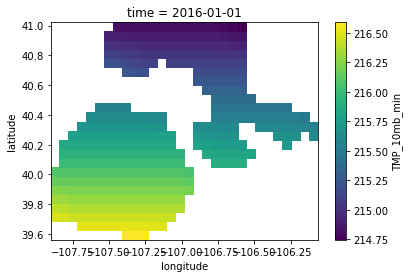

In [14]:
#this demonstrates wihtin a region how much data we have versus masked out areas
region_data['Steamboat Zone'].TMP_10mb_min.plot()

In [45]:
#region_data['North San Juan Mountains'].sel(latitude=37.765217, longitude=-107.994413, method="nearest").values

<xarray.Dataset>
Dimensions:                                               (latitude: 14, longitude: 39, time: 1)
Coordinates:
  * time                                                  (time) datetime64[ns] 2016-01-01
  * latitude                                              (latitude) float64 37.58 ... 38.37
  * longitude                                             (longitude) float64 -108.3 ... -106.0
Data variables:
    UGRD_planetaryboundarylayer_min                       (time, latitude, longitude) float64 nan ... nan
    VGRD_planetaryboundarylayer_min                       (time, latitude, longitude) float64 nan ... nan
    VRATE_planetaryboundarylayer_min                      (time, latitude, longitude) float64 nan ... nan
    GUST_surface_min                                      (time, latitude, longitude) float64 nan ... nan
    HGT_10mb_min                                          (time, latitude, longitude) float64 nan ... nan
    TMP_10mb_min                                          (time, latitude, longitude) float64 nan ... nan
    RH_10mb_min                                           (time, latitude, longitude) float64 nan ... nan
    UGRD_10mb_min                                         (time, latitude, longitude) float64 nan ... nan
    VGRD_10mb_min                                         (time, latitude, longitude) float64 nan ... nan
    ABSV_10mb_min                                         (time, latitude, longitude) float64 nan ... nan
    O3MR_10mb_min                                         (time, latitude, longitude) float64 nan ... nan
    HGT_20mb_min                                          (time, latitude, longitude) float64 nan ... nan
    TMP_20mb_min                                          (time, latitude, longitude) float64 nan ... nan
    RH_20mb_min                                           (time, latitude, longitude) float64 nan ... nan
    UGRD_20mb_min                                         (time, latitude, longitude) float64 nan ... nan
    VGRD_20mb_min                                         (time, latitude, longitude) float64 nan ... nan
    ABSV_20mb_min                                         (time, latitude, longitude) float64 nan ... nan
    O3MR_20mb_min                                         (time, latitude, longitude) float64 nan ... nan
    HGT_30mb_min                                          (time, latitude, longitude) float64 nan ... nan
    TMP_30mb_min                                          (time, latitude, longitude) float64 nan ... nan
    RH_30mb_min                                           (time, latitude, longitude) float64 nan ... nan
    UGRD_30mb_min                                         (time, latitude, longitude) float64 nan ... nan
    VGRD_30mb_min                                         (time, latitude, longitude) float64 nan ... nan
    ABSV_30mb_min                                         (time, latitude, longitude) float64 nan ... nan
    O3MR_30mb_min                                         (time, latitude, longitude) float64 nan ... nan
    HGT_50mb_min                                          (time, latitude, longitude) float64 nan ... nan
    TMP_50mb_min                                          (time, latitude, longitude) float64 nan ... nan
    RH_50mb_min                                           (time, latitude, longitude) float64 nan ... nan
    UGRD_50mb_min                                         (time, latitude, longitude) float64 nan ... nan
    VGRD_50mb_min                                         (time, latitude, longitude) float64 nan ... nan
    ABSV_50mb_min                                         (time, latitude, longitude) float64 nan ... nan
    O3MR_50mb_min                                         (time, latitude, longitude) float64 nan ... nan
    HGT_70mb_min                                          (time, latitude, longitude) float64 nan ... nan
    TMP_70mb_min                                          (time, latitude, long

In [80]:
#find union of all lat/lon/region to just grids with values
#the process to filter the lat/lon is expensive but we need to do it here (5 seconds per region)
#as the helps the batch process select relevant data
lat_lon_union = pd.DataFrame()
for r in region_data.keys():
    print(r)
    region_df = region_data[r].stack(lat_lon = ('latitude', 'longitude')).lat_lon.to_dataframe()
    tmp_df = pd.DataFrame.from_records(region_df['lat_lon'], columns=['latitude', 'longitude'])
    indexes_to_drop = []
    for index, row in tmp_df.iterrows():
        #TODO: there might be a more efficient way than doing this one by one?
        if 0 == np.count_nonzero(region_data[r].to_array().sel(latitude=row['latitude'], longitude=row['longitude']).stack(time_var = ('time', 'variable')).dropna(dim='time_var', how='all').values):
            indexes_to_drop.append(index)
    tmp_df.drop(indexes_to_drop, axis=0, inplace=True)
    tmp_df[region_col] = r
    lat_lon_union = pd.concat([lat_lon_union, tmp_df])

Abajos
Logan
Moab
Ogden
Provo
Salt Lake
Skyline
Uintas
Grand Mesa Zone
Sangre de Cristo Range
Steamboat Zone
Front Range Zone
Vail Summit Zone
Sawatch Zone
Aspen Zone
North San Juan Mountains
South San Juan Mountains
Gunnison Zone
Mt Hood
Olympics
Snoqualmie Pass
Stevens Pass
WA Cascades East, Central
WA Cascades East, North
WA Cascades East, South
WA Cascades West, Central
WA Cascades West, Mt Baker
WA Cascades West, South


In [81]:
lat_lon_union.head()

latitude   longitude UnifiedRegion
1  37.704348 -109.776536        Abajos
2  37.704348 -109.715084        Abajos
7  37.765217 -109.837989        Abajos
8  37.765217 -109.776536        Abajos
9  37.765217 -109.715084        Abajos

In [19]:
#cache the data
lat_lon_union.to_csv(processed_path + 'lat_lon_union.csv')

In [17]:
lat_lon_union = pd.read_csv(processed_path + 'lat_lon_union.csv',float_precision='round_trip')

In [18]:
lat_lon_union.shape

(3991, 4)

In [19]:
lat_lon_union = lat_lon_union.set_index(region_col, drop=False).join(labels.set_index(region_col, drop=False), how='left', lsuffix='left', rsuffix='right')

In [85]:
lat_lon_union.shape

(1746317, 302)

In [168]:
#del labels

In [169]:
#earliest_data, season = date_to_season(np.datetime64('2015-12-11'))

In [170]:
#remove unnecessary dimensions (like region)
#for k in region_data.keys():
#    region_data[k] = region_data[k].squeeze()

In [20]:
def get_state_for_region(region):
    for k in regions.keys():
        #print('on k ' + k)
        #print('with regions: ' + regions[k])
        if region in regions[k]:
            return k
    
    raise Exception('No region with name ' + region)

In [21]:
def create_filename_list(region, end_date, lookback_days):
    earliest_data, season = date_to_season(end_date)
    if earliest_data == -1:
        return None
    state = get_state_for_region(region)
    filenames = []
    reg = region
    for i in range(lookback_days):
        d = np.datetime64(end_date) - np.timedelta64(i, 'D')
        if d < earliest_data:
            break #no more data
        filenames.insert(0,processed_path + '/' + season + '/' + state + '/Region_' + reg + '_' + pd.to_datetime(d).strftime('%Y%m%d') + '.nc')
    return filenames
        
        

In [22]:
def get_data_zarr(region, lat, lon, lookback_days, date):
    #print(region + ' ' + str(lat) + ', ' + str(lon) + ' ' + str(date))
    state = get_state_for_region(region)
    earliest_data, season = date_to_season(date)
    path = processed_path + '/' + season + '/' + state + '/Region_' + region + '.zarr'
    tmp_ds = xr.open_zarr(path, consolidated=True)
    start_day = date - np.timedelta64(lookback_days-1, 'D')
    #print('start day ' + str(start_day))
    tmp_ds = tmp_ds.sel(latitude=lat, longitude=lon, method='nearest').sel(time=slice(start_day, date))
    
    date_values_pd = pd.date_range(start_day, periods=lookback_days, freq='D')
    #reindex should fill missing values with NA
    tmp_ds = tmp_ds.reindex({'time': date_values_pd})
    
    tmp_ds = tmp_ds.reset_index(dims_or_levels='time', drop=True).load()
    return tmp_ds

In [40]:
#['North San Juan Mountains'].sel(latitude=37.765217, longitude=-107.994413, method="nearest").values
get_data_zarr('South San Juan Mountains', 37.5217391, -107.994413, 180, np.datetime64('2015-11-17')).sel(variable='SNOD_surface_avg').vars.values

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [41]:
#['North San Juan Mountains'].sel(latitude=37.765217, longitude=-107.994413, method="nearest").values
for i in range(0,978):
    print(str(i) + ': ' + str(get_data_zarr('South San Juan Mountains', 37.5217391, -107.994413, 180, np.datetime64('2015-11-17')).vars.isel(variable=i).values[-1]))

0: -1.9181442800470327
1: -20.873743624776385
2: 1086.9565217391255
3: 4.8973768099668264
4: 30783.28947997632
5: 222.78261201278022
6: 0.20000000298023227
7: 7.19261360782311
8: -15.746550454599983
9: 8.280342323717712e-05
10: 1.0356416959953293e-05
11: 26283.01855018065
12: 217.5062670815417
13: 0.699999988079071
14: -4.94427236932732
15: -11.162457987090642
16: 7.871666508402157e-05
17: 8.618483448226684e-06
18: 23730.980838311425
19: 212.79553384621053
20: 1.4086956304052596
21: -0.04006315189290976
22: -6.722324529202608
23: 7.969166588432723e-05
24: 8.16723547927253e-06
25: 20545.07218355295
26: 211.8064631642084
27: 2.508695643881093
28: 1.3735365932764303
29: -1.806606799646407
30: 6.702854175475523e-05
31: 4.88210520228699e-06
32: 18438.643442016335
33: 213.60000610351565
34: 2.391304430754289
35: 4.664605179138775
36: 0.37740649017628836
37: 8.89909639613125e-05
38: 2.4548747182834934e-06
39: 16187.206266746494
40: 215.88279718561662
41: 1.6020403449501213
42: -0.046924184503

371: 0.00013464863305139577
372: 0.0
373: 1.7668324603593709e-06
374: 13654.73442433811
375: 223.6935368357916
376: 3.3944862746543776
377: 0.30242408433092616
378: 13.58864737194026
379: 5.62498674561801
380: 0.00020069317474376758
381: 0.0
382: 9.31952525795787e-07
383: 11837.227791683115
384: 226.96949279948234
385: 36.536459890592084
386: 0.045931795250488704
387: 6.730872168829358
388: 3.7337624808958583
389: 0.00023425295777695907
390: 9.79596805229537e-08
391: 4.0236713868684474e-07
392: 10404.81120155377
393: 228.46162214040586
394: 66.84661039658644
395: -0.0923093782087747
396: 3.233058001307705
397: 2.8187514695549187
398: 0.0002643851536005001
399: 0.0
400: 3.357432583113329e-07
401: 9200.622434892672
402: 229.79776827849489
403: 99.1820527976191
404: 0.05151773743441695
405: 1.9366285291681233
406: 0.2619626004323957
407: 0.00034315253247315557
408: 7.530240214273767e-05
409: 2.305462120559435e-07
410: 8145.711787396389
411: 237.88051448263298
412: 100.00000000000001
413: 

732: -26.308794488135472
733: 0.00018031999861298648
734: 1.496301004165226e-05
735: 1.4515616162921245e-07
736: 8047.10661740288
737: 232.9818799415201
738: 57.563916064362694
739: -0.23780546234393682
740: -8.546605265832564
741: -23.57649100542009
742: 0.00015422513826089364
743: 2.5772892084696837e-05
744: 9.57145483326824e-08
745: 7121.893660242592
746: 240.47094221766028
747: 47.60829505429326
748: 0.8083352493318997
749: -6.37144592626599
750: -21.45761004298061
751: 0.0001589094781383438
752: 1.2639023073359508e-05
753: 9.132887999529748e-08
754: 6281.073970517633
755: 247.27138391234848
756: 39.50387421932963
757: 2.0615512921968215
758: -4.304007122868158
759: -22.429572656023133
760: 0.0001745028572598651
761: 2.9758154896712243e-05
762: 5509.239534864965
763: 253.0161310677277
764: 41.93003543986252
765: 3.0867044054711945
766: -3.507893380766681
767: -24.45547744374786
768: 0.0001485250620325252
769: 4.32492809058815e-05
770: 4796.483117233992
771: 257.64598681320405
772: 

In [42]:
get_data_zarr('South San Juan Mountains', 37.5217391, -107.994413, 180, np.datetime64('2015-11-17')).vars.isel(variable=917)

<xarray.DataArray 'vars' (time: 180)>
array([         nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan,          nan, -20.70744088,
         4.50026044,  37.85942777,  48.55607986,  10.43558379,
         7.86376327,  -8.50108613,   5.5983173 ,  12.86078298,
        26.87153917,  11.08419115,   8.73668035,   7.1167943 ,
         3.5682673 ,   9.41681522,  29.15495983, -31.97445385])
Coordinates:
    latitude   float64 37.52
    longitude  float64 -108.0
    variable   <U52 'VGRD_maxwind_avg'
Dimensions without coordinates: time
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

In [28]:
labels[labels[parsed_date_col]==np.datetime64('2018-11-20')][ labels[region_col] == 'Gunnison Zone']['Day1DangerAboveTreeline']

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


18295    Low
Name: Day1DangerAboveTreeline, dtype: object

In [23]:
def get_data_serial(region, lat, lon, lookback_days, date):
    data = []    
    filenames = create_filename_list(region, date, lookback_days) 
    if filenames is None:
        return None, None
    error_files = []
    for f in filenames:      
        if os.path.isfile(f): #sometimes the file is missing
            try:
                data.append(xr.open_dataset(f)) 
            except OSError as err:
                error_files.append(f)
                print('Error file: ' + f)
        else:
            print('Skipped file: ' + f)
    try:
        tmp_ds = xr.concat(data, dim='time')
    except ValueError as err:
        print('Error ' + format(err) + ' On region: ' + region + ' and lat/lon: ' + str(lat) + '/' + str(lon) + ' and date: ' + str(date))
        return None, error_files
    
    tmp2 = tmp_ds.sel(latitude=lat, longitude=lon, method='nearest')
    date_values_pd = pd.date_range(date - np.timedelta64(lookback_days-1, 'D'), periods=lookback_days, freq='D')
    #reindex should fill missing values with NA
    tmp2 = tmp2.reindex({'time': date_values_pd})
    tmp2 = tmp2.reset_index(dims_or_levels='time', drop=True).load()
    #print("loaded data")
    return tmp2, error_files

In [24]:
#TODO: need to try removing the oversampling as its overfitting
#just create a training set which is balanced but without oversampling
#also reexaming perf of the .parquet files

In [25]:
def process_sample(iter_tuple, lookback_days):
    row = iter_tuple[1]
    d = row[parsed_date_col] 
    
    lat = row['latitude']
    lon = row['longitude']
    reg = row[region_col]            
    #print('region: ' + reg + ' date ' + str(d))
    ds = get_data_zarr(reg, lat, lon, lookback_days, d)
    
    #print("actual data")
    if ds.time.shape[0] != lookback_days:    
        print(ds)
        print('Need to drop! Error, incorrect shape ' + str(ds.time.shape[0]) + ' on time ' + str(d))
    return (ds)



def get_xr_batch(labels, lookback_days=14, batch_size=64, y_column='Day1DangerAboveTreeline', label_values=['Low', 'Moderate', 'Considerable', 'High'], oversample={'Low':True, 'Moderate':False, 'Considerable':False, 'High':True}, random_state=1, n_jobs=-1):
    labels_data = labels
    
    X = None     
    y = None 

    first = True   
    first_y = True
    num_in_place = 0
    error_files = []
    while num_in_place < batch_size:
        if not first:
            #if we didn't meet the full batch size 
            #continue appending until its full
            #if num_in_place % 5 == 0:
            print('Filling remaining have ' + str(num_in_place))
            sample_size = batch_size-num_in_place
            if sample_size < len(label_values):
                sample_size = len(label_values)
        else: 
            sample_size = batch_size
        
        batch_lookups = []
        for l in label_values:
            print('on label: ' + l + ' with samplesize: ' + str(int(sample_size/len(label_values))))
            print('len: ' + str(len(labels_data[labels_data[y_column]==l])))
            batch_lookups.append(labels_data[labels_data[y_column]==l].sample(int(sample_size/len(label_values)), random_state=random_state))
            if not oversample[l]:
                labels_data = labels_data.drop(batch_lookups[-1].index, axis=0)
        #get 1/4 of the data from 'High' and 1/4 from low
        #this is basically a naive oversampling strategy since Low/High 
        #populations are much smaller that moderate/considerable
        #TODO: add Extreme in (or possibly make it high)        
        #batch_lookup_low = labels_data[labels_data[y_column]=='Low'].sample(int(sample_size/4), random_state=random_state)
        #batch_lookup_moderate = labels_data[labels_data[y_column]=='Moderate'].sample(int(sample_size/4), random_state=random_state)
        #batch_lookup_considerable = labels_data[labels_data[y_column]=='Considerable'].sample(int(sample_size/4), random_state=random_state)
        #batch_lookup_high = labels_data[labels_data[y_column]=='High'].sample(int(sample_size/4), random_state=random_state)
        
        #remove moderate and considerable, 
        #labels_data = labels_data.drop(batch_lookup_moderate.index, axis=0)
        #labels_data = labels_data.drop(batch_lookup_considerable.index, axis=0)
        #keeping high and low if set to oversample
        #if not oversample:    
        #    labels_data = labels_data.drop(batch_lookup_high.index, axis=0)
        #    labels_data = labels_data.drop(batch_lookup_low.index, axis=0)
                            
        #sample frac=1 causes the data to be shuffled
        batch_lookup = pd.concat(batch_lookups).sample(frac=1)
        #print('lookup shape: ' + str(batch_lookup.shape))
        batch_lookup.reset_index(inplace=True, drop=True)
        
        func = partial(process_sample, lookback_days=lookback_days)        
        data = Parallel(n_jobs=n_jobs)(map(delayed(func), batch_lookup.iterrows()))
        

        #print('data has len: ' + str(len(data)))
        to_delete = []
        #delete backwards so we can delete by index
        for i in reversed(range(len(data))):
            #print('on i: ' + str(i))
            if data[i] is None:
                print('deleting ' + str(i))
                del data[i]
                batch_lookup = batch_lookup.drop(i, axis=0)
                
        
        for d in sorted(to_delete, reverse=True):
            print('deleting ' + str(d))
            del data[d]
            
        for f in data:
            if f is None:
                print('Still have none in data')
            
        if first and len(data) > 0:                            
            X = xr.concat(data, dim='sample') 
            y = batch_lookup
            first = False            
        elif not first and len(data) > 0:    
            X_t = xr.concat(data, dim='sample')
            X = xr.concat([X, X_t], dim='sample')#, coords='all', compat='override') 
            y = pd.concat([y, batch_lookup], axis=0)
        #if first_y:
        #    y = batch_lookup
        #else:                
        #    y = pd.concat([y, batch_lookup], axis=0)
            
        num_in_place = y.shape[0]
        #print('Num: ' + str(num_in_place))
                
    y = y.reset_index(drop=True)
    X = X.reindex({'sample': y.apply(lambda r: str(r[parsed_date_col]) + ': ' + r[region_col], axis=1)})
    return X, y, labels_data







In [26]:
date_min = np.datetime64('2015-11-01')
date_max = np.datetime64('2019-04-30')
train_date_cutoff = np.datetime64('2018-11-01')


In [27]:
labels_data_union = lat_lon_union[lat_lon_union[parsed_date_col] >= date_min]
labels_data_union = labels_data_union[labels_data_union[parsed_date_col] <= date_max]
#copy so we can delete the overall data and only keep the filtered
labels_data_train = labels_data_union[labels_data_union[parsed_date_col] <= train_date_cutoff].copy()
labels_data_test = labels_data_union[labels_data_union[parsed_date_col] > train_date_cutoff].copy()


In [28]:
labels_data_train.reset_index(inplace=True)
labels_data_test.reset_index(inplace=True)

In [29]:
len(labels_data_train)

1617734

In [30]:
labels_data_train.head()

UnifiedRegion  Unnamed: 0   latitude   longitude UnifiedRegionleft  \
0        Abajos           1  37.704348 -109.776536            Abajos   
1        Abajos           1  37.704348 -109.776536            Abajos   
2        Abajos           1  37.704348 -109.776536            Abajos   
3        Abajos           1  37.704348 -109.776536            Abajos   
4        Abajos           1  37.704348 -109.776536            Abajos   

  Cornices_Likelihood Cornices_MaximumSize Cornices_MinimumSize  \
0             no-data              no-data              no-data   
1             no-data              no-data              no-data   
2             no-data              no-data              no-data   
3             no-data              no-data              no-data   
4             no-data              no-data              no-data   

  Cornices_OctagonAboveTreelineEast Cornices_OctagonAboveTreelineNorth  ...  \
0                           no-data                            no-data  ...   
1                           no-data                            no-data  ...   
2                           no-data                            no-data  ...   
3                           no-data                            no-data  ...   
4                           no-data                            no-data  ...   

                        image_types  \
0  Forecast,WindSlab,PersistentSlab   
1                         Forecast,   
2                 Forecast,WindSlab   
3                         Forecast,   
4                 Forecast,WindSlab   

                                          image_urls rose_url  \
0  https://utahavalanchecenter.org/sites/default/...  no-data   
1  https://utahavalanchecenter.org/sites/default/...  no-data   
2  https://utahavalanchecenter.org/sites/default/...  no-data   
3  https://utahavalanchecenter.org/sites/default/...  no-data   
4  https://utahavalanchecenter.org/sites/default/...  no-data   

  BottomLineSummary Day1WarningText Day2WarningText parsed_date season  \
0           no-data         no-data         no-data  2015-11-21  15-16   
1           no-data         no-data         no-data  2015-11-23  15-16   
2           no-data         no-data         no-data  2015-11-28  15-16   
3           no-data         no-data         no-data  2015-11-30  15-16   
4           no-data         no-data         no-data  2015-12-05  15-16   

  Day1DangerAboveTreelineValue Day1DangerAboveTreelineWithTrend  
0                          1.0                 Moderate_Initial  
1                          NaN                  no-data_Unknown  
2                          1.0                 Moderate_Unknown  
3                          NaN                  no-data_Unknown  
4                          1.0                 Moderate_Unknown  

[5 rows x 303 columns]

In [167]:
labels_data_train['Day1DangerAboveTreelineWithTrend'].value_counts()

Moderate_Flat           610672
Considerable_Flat       272384
Low_Flat                156981
Moderate_Falling        127131
Considerable_Rising     105751
no-data_Unknown          84107
High_Rising              56399
Considerable_Falling     53750
Low_Falling              53467
Moderate_Rising          45286
High_Flat                31809
Moderate_Initial          4363
Moderate_Unknown          3920
no-data_Initial           2844
Considerable_Initial      2721
Considerable_Unknown      2405
Low_Initial               1363
Extreme_Unknown           1095
Low_Unknown                908
High_Unknown               378
Name: Day1DangerAboveTreelineWithTrend, dtype: int64

In [168]:
labels_data_test['Day1DangerAboveTreelineWithTrend'].value_counts()

Moderate_Flat           56067
Considerable_Flat       16069
no-data_Unknown         13053
Considerable_Rising      9901
Moderate_Falling         9844
Low_Flat                 8498
Low_Falling              3954
Moderate_Rising          3006
High_Rising              1650
Considerable_Falling     1593
Moderate_Initial          926
Low_Initial               905
High_Flat                 738
no-data_Initial           694
Considerable_Initial      571
High_Initial              397
Considerable_Unknown      363
Moderate_Unknown          250
Low_Unknown               104
Name: Day1DangerAboveTreelineWithTrend, dtype: int64

In [96]:
labels_data_train[region_col].value_counts()

North San Juan Mountains      130410
WA Cascades West, South       128920
WA Cascades East, Central     113960
WA Cascades East, North       112200
South San Juan Mountains      104408
Front Range Zone              102680
Steamboat Zone                 98154
WA Cascades West, Central      84480
WA Cascades East, South        71720
Gunnison Zone                  65709
Sangre de Cristo Range         64386
WA Cascades West, Mt Baker     62338
Grand Mesa Zone                56448
Vail Summit Zone               52680
Aspen Zone                     48168
Sawatch Zone                   46935
Skyline                        46138
Olympics                       45760
Uintas                         43290
Ogden                          30360
Logan                          30330
Salt Lake                      15504
Mt Hood                        14080
Snoqualmie Pass                12760
Provo                          12236
Stevens Pass                   11000
Moab                            8120
A

In [97]:
labels_data_test[region_col].value_counts()

Steamboat Zone                15048
Front Range Zone              14960
North San Juan Mountains      13860
WA Cascades West, South       11134
South San Juan Mountains      10912
Sangre de Cristo Range         6570
Gunnison Zone                  6556
WA Cascades East, Central      6475
WA Cascades East, North        5865
Grand Mesa Zone                5544
Vail Summit Zone               5280
WA Cascades West, Central      4992
WA Cascades West, Mt Baker     4828
Sawatch Zone                   4620
Aspen Zone                     4536
WA Cascades East, South        3097
Olympics                       2080
Snoqualmie Pass                 986
Mt Hood                         640
Stevens Pass                    600
Name: UnifiedRegion, dtype: int64

In [111]:
labels_data_train.apply(lambda x: x[region_col] + ': ' + str(x[parsed_date_col]), axis=1)

0                           Abajos: 2015-11-21 00:00:00
1                           Abajos: 2015-11-23 00:00:00
2                           Abajos: 2015-11-28 00:00:00
3                           Abajos: 2015-11-30 00:00:00
4                           Abajos: 2015-12-05 00:00:00
                               ...                     
1617729    WA Cascades West, South: 2018-04-25 00:00:00
1617730    WA Cascades West, South: 2018-04-26 00:00:00
1617731    WA Cascades West, South: 2018-04-27 00:00:00
1617732    WA Cascades West, South: 2018-04-28 00:00:00
1617733    WA Cascades West, South: 2018-04-29 00:00:00
Length: 1617734, dtype: object

In [113]:
#8 core 1 min
#fastest is use multiprocessing but no dask
%time X_train, y_train, remaining_labels_train = get_xr_batch(labels_data_train, lookback_days=7, batch_size=10, n_jobs=14)

data has len: 8
Filling remaining have 8
data has len: 4
CPU times: user 40.3 s, sys: 12.2 s, total: 52.4 s
Wall time: 54.5 s


In [115]:
X_train.sample.values

array(['Salt Lake: 2018-02-14 00:00:00',
       'WA Cascades West, Mt Baker: 2018-02-17 00:00:00',
       'Sangre de Cristo Range: 2017-03-28 00:00:00',
       'North San Juan Mountains: 2018-02-15 00:00:00',
       'South San Juan Mountains: 2017-02-26 00:00:00',
       'WA Cascades East, Central: 2017-03-29 00:00:00',
       'Aspen Zone: 2016-04-14 00:00:00',
       'WA Cascades West, South: 2015-12-19 00:00:00',
       'WA Cascades West, South: 2015-12-10 00:00:00',
       'Snoqualmie Pass: 2016-03-14 00:00:00',
       'Aspen Zone: 2016-04-15 00:00:00',
       'North San Juan Mountains: 2016-03-09 00:00:00'], dtype=object)

In [14]:
temp_path

'/media/scottcha/Data/Temp/'

In [31]:
label_filters = ['Moderate_Flat', 
                 'Considerable_Flat', 
                 'Low_Flat', 
                 'Moderate_Falling',
                 'Considerable_Rising',
                 'High_Rising',
                 'Considerable_Falling',
                 'Low_Falling',
                 'Moderate_Rising',
                 'High_Flat',
                 'Moderate_Initial',
                 'Considerable_Initial',
                 'Low_Initial']
label_oversample = {'Moderate_Flat':False, 
                 'Considerable_Flat':False, 
                 'Low_Flat':False, 
                 'Moderate_Falling':False,
                 'Considerable_Rising':False,
                 'High_Rising':True,
                 'Considerable_Falling':True,
                 'Low_Falling':True,
                 'Moderate_Rising':True,
                 'High_Flat':True,
                 'Moderate_Initial':False,
                 'Considerable_Initial':False,
                 'Low_Initial':False}

In [172]:
X, y, remaining_labels_train = get_xr_batch(remaining_labels_train, lookback_days=180, batch_size=64, y_column='Day1DangerAboveTreelineWithTrend', label_values=label_filters, oversample=label_oversample, n_jobs=14)

on label: Moderate_Flat with samplesize: 4
len: 610672
on label: Considerable_Flat with samplesize: 4
len: 272384
on label: Low_Flat with samplesize: 4
len: 156981
on label: Moderate_Falling with samplesize: 4
len: 127131
on label: Considerable_Rising with samplesize: 4
len: 105751
on label: High_Rising with samplesize: 4
len: 56399
on label: Considerable_Falling with samplesize: 4
len: 53750
on label: Low_Falling with samplesize: 4
len: 53467
on label: Moderate_Rising with samplesize: 4
len: 45286
on label: High_Flat with samplesize: 4
len: 31809
on label: Moderate_Initial with samplesize: 4
len: 4363
on label: Considerable_Initial with samplesize: 4
len: 2721
on label: Low_Initial with samplesize: 4
len: 1363
Filling remaining have 52
on label: Moderate_Flat with samplesize: 1
len: 610668
on label: Considerable_Flat with samplesize: 1
len: 272380
on label: Low_Flat with samplesize: 1
len: 156977
on label: Moderate_Falling with samplesize: 1
len: 127127
on label: Considerable_Rising w

In [173]:
y['Day1DangerAboveTreelineWithTrend'].value_counts()

Moderate_Falling        5
Moderate_Initial        5
Moderate_Flat           5
Moderate_Rising         5
Considerable_Rising     5
Considerable_Flat       5
Considerable_Initial    5
Considerable_Falling    5
High_Flat               5
High_Rising             5
Low_Initial             5
Low_Flat                5
Low_Falling             5
Name: Day1DangerAboveTreelineWithTrend, dtype: int64

In [32]:
remaining_labels_train = labels_data_train

In [45]:
remaining_labels_test = labels_data_test

In [34]:
def prepare_batch_simple(X, y):#, offset=0, compute_tsfresh=False, known_relevant_features=None, n_jobs=14):
    #ensure, X and y indexes are aligned
    X = X.sortby(['sample', 'latitude', 'longitude'])
    #X = xr_batch.reset_index('sample', drop=True)
    sample = y.apply(lambda row: '{}: {}'.format(row['parsed_date'], row['UnifiedRegion']), axis=1)
    y['sample'] = sample
    y = y.set_index(['sample', 'latitude', 'longitude'])
    y.sort_index(inplace=True)    
    y.reset_index(drop=False, inplace=True)
    return X, y

In [35]:
def cache_batches(labels, batch_size=50, total_rows=10000, train_or_test='train', lookback_days=180, n_jobs=14):
    remaining_labels = labels
    for i in range(0, total_rows, batch_size):
        print(str(datetime.datetime.now()) + ' On ' + str(i) + ' of ' + str(total_rows))
        X, y, remaining_labels = get_xr_batch(remaining_labels, lookback_days=lookback_days, batch_size=batch_size, n_jobs=n_jobs)
        X.to_zarr(temp_path + 'X_' + train_or_test + '_' + str(i/batch_size) + '.zarr')
        y.to_parquet(temp_path + 'y_' + train_or_test + '_' + str(i/batch_size) + '.parquet')
    return remaining_labels

In [36]:
def cache_batches_np(labels, batch_size=50, total_rows=10000, train_or_test='train', lookback_days=180, y_column='Day1DangerAboveTreelineWithTrend', label_values=label_filters, oversample=label_oversample, n_jobs=14):
    remaining_labels = labels
    for i in range(0, total_rows, batch_size):
        print(str(datetime.datetime.now()) + ' *On ' + str(i) + ' of ' + str(total_rows))
        X, y, remaining_labels = get_xr_batch(remaining_labels, lookback_days=lookback_days, batch_size=batch_size, y_column=y_column, label_values=label_values, oversample=oversample, n_jobs=n_jobs)         
        #X.to_zarr(temp_path + 'X_' + train_or_test + '_' + str(i/batch_size) + '.zarr')
        #y.to_parquet(temp_path + 'y_' + train_or_test + '_' + str(i/batch_size) + '.parquet')
    return prepare_batch_simple(X, y), remaining_labels

In [61]:
vals, remaining_labels_train = cache_batches_np(remaining_labels_train, batch_size=500, total_rows=500)

2020-09-11 17:25:31.987530 *On 0 of 500
data has len: 500


In [74]:
vals1, remaining_labels_test =  cache_batches_np(remaining_labels_test, batch_size=500, total_rows=500, train_or_test='test')

2020-09-11 18:19:19.854166 *On 0 of 500
data has len: 500


In [79]:
vals[0].variable.values

array(['ABSV_1000mb_avg', 'ABSV_1000mb_max', 'ABSV_1000mb_min', ...,
       'WILT_surface_avg', 'WILT_surface_max', 'WILT_surface_min'],
      dtype=object)

In [85]:
vals1[0].variable.values.index('ABSV_1000mb_avg')

1015

In [90]:
(vals[0].variable.values==vals1[0].sortby('variable').variable.values).all()

True

In [89]:
vals1[0].sortby('variable')

<xarray.Dataset>
Dimensions:    (sample: 500, time: 180, variable: 1131)
Coordinates:
  * sample     (sample) object '2018-11-15 00:00:00: North San Juan Mountains' ... '2019-04-13 00:00:00: WA Cascades East, Central'
  * variable   (variable) <U52 'ABSV_1000mb_avg' ... 'WILT_surface_min'
    latitude   (sample) float64 37.95 38.19 37.16 37.7 ... 47.83 47.23 47.65
    longitude  (sample) float64 -107.7 -107.1 -104.9 ... -121.0 -121.0 -120.5
Dimensions without coordinates: time
Data variables:
    vars       (sample, variable, time) float64 nan nan nan ... 0.05303 0.05303

In [70]:
prev = vals
for i in range(0,20):
    nxt, remaining_labels_train =  cache_batches_np(remaining_labels_train, batch_size=500, total_rows=500)
    assert (nxt[0].variable.values==prev[0].variable.values).all()
    prev = nxt

2020-09-11 17:31:12.854636 *On 0 of 500
data has len: 500
2020-09-11 17:32:16.241684 *On 0 of 500
data has len: 500
2020-09-11 17:33:19.591837 *On 0 of 500
data has len: 500
2020-09-11 17:34:20.807373 *On 0 of 500
data has len: 500
2020-09-11 17:35:23.585461 *On 0 of 500
data has len: 500
2020-09-11 17:36:25.591193 *On 0 of 500
data has len: 500
2020-09-11 17:37:26.497193 *On 0 of 500
data has len: 500
2020-09-11 17:38:27.458268 *On 0 of 500
data has len: 500
2020-09-11 17:39:29.165812 *On 0 of 500
data has len: 500
2020-09-11 17:40:29.122102 *On 0 of 500
data has len: 500
2020-09-11 17:41:31.185545 *On 0 of 500
data has len: 500
2020-09-11 17:42:31.871256 *On 0 of 500
data has len: 500
2020-09-11 17:43:32.025122 *On 0 of 500
data has len: 500
2020-09-11 17:44:33.127377 *On 0 of 500
data has len: 500
2020-09-11 17:45:34.346952 *On 0 of 500
data has len: 500
2020-09-11 17:46:35.992559 *On 0 of 500
data has len: 500
2020-09-11 17:47:37.879311 *On 0 of 500
data has len: 500
2020-09-11 17:

In [37]:
def create_memmapped(remaining_labels, train_or_test = 'train', num_rows = 100000, batch=0, batch_size=500):
    # Save a small empty array
    X_temp_fn = temp_path + '/data/temp_X.npy'
    np.save(X_temp_fn, np.empty(1))
    
    # Create a np.memmap with desired dtypes and shape of the large array you want to save.
    # It's just a placeholder that doesn't contain any data
    X_fn = temp_path + '/data/X' + train_or_test + '_batch_' + str(batch) + '_on_disk.npy'
    X = np.memmap(X_temp_fn, dtype='float32', shape=(num_rows, 1131, 180))

    # We are going to create a loop to fill in the np.memmap
    start = 0
    for i in range(0, num_rows, batch_size):
        print('On ' + str(i) + ' of ' + str(num_rows))
        # You now grab a chunk of your data that fits in memory
        # This could come from a pandas dataframe for example        
        dfs, remaining_labels = cache_batches_np(remaining_labels, batch_size=batch_size, total_rows=500)
        #need to make sure all the variables are in the same order (there was an issue that they weren't between train and test sets)
        X_df = dfs[0].sortby('variable')
        y_df = dfs[1]
        end = start + batch_size

        # I now fill a slice of the np.memmap         
        X[start:end] = X_df.vars.values[:batch_size] #sometimes the process will add a few extras, filter them
  
        #just save y as parquet
        y_df[:batch_size].to_parquet(temp_path + '/data/y_' + train_or_test + '_batch_' + str(batch) + '_' + str(i/batch_size) + '.parquet')
        start = end
        del X_df, y_df

    #I can now remove the temp file I created
    os.remove(X_temp_fn)

    # Once the data is loaded on the np.memmap, I save it as a normal np.array
    np.save(X_fn, X)
    return remaining_labels



In [92]:
temp_path

'/media/scottcha/Data/Temp/'

In [ ]:
import pickle
pickle.op

In [38]:
remaining_labels_train = labels_data_train

In [39]:
remaining_labels_test = labels_data_test

In [40]:
%time remaining_labels_train = create_memmapped(remaining_labels_train, train_or_test = 'train', num_rows=50000, batch=0)

On 0 of 50000
2020-10-07 13:03:42.292208 *On 0 of 500
on label: Moderate_Flat with samplesize: 38
len: 610672
on label: Considerable_Flat with samplesize: 38
len: 272384
on label: Low_Flat with samplesize: 38
len: 156981
on label: Moderate_Falling with samplesize: 38
len: 127131
on label: Considerable_Rising with samplesize: 38
len: 105751
on label: High_Rising with samplesize: 38
len: 56399
on label: Considerable_Falling with samplesize: 38
len: 53750
on label: Low_Falling with samplesize: 38
len: 53467
on label: Moderate_Rising with samplesize: 38
len: 45286
on label: High_Flat with samplesize: 38
len: 31809
on label: Moderate_Initial with samplesize: 38
len: 4363
on label: Considerable_Initial with samplesize: 38
len: 2721
on label: Low_Initial with samplesize: 38
len: 1363
Filling remaining have 494
on label: Moderate_Flat with samplesize: 1
len: 610634
on label: Considerable_Flat with samplesize: 1
len: 272346
on label: Low_Flat with samplesize: 1
len: 156943
on label: Moderate_Fa

len: 53467
on label: Moderate_Rising with samplesize: 38
len: 45286
on label: High_Flat with samplesize: 38
len: 31809
on label: Moderate_Initial with samplesize: 38
len: 4363
on label: Considerable_Initial with samplesize: 38
len: 2721
on label: Low_Initial with samplesize: 38
len: 1363
Filling remaining have 494
on label: Moderate_Flat with samplesize: 1
len: 610439
on label: Considerable_Flat with samplesize: 1
len: 272151
on label: Low_Flat with samplesize: 1
len: 156748
on label: Moderate_Falling with samplesize: 1
len: 126898
on label: Considerable_Rising with samplesize: 1
len: 105518
on label: High_Rising with samplesize: 1
len: 56399
on label: Considerable_Falling with samplesize: 1
len: 53750
on label: Low_Falling with samplesize: 1
len: 53467
on label: Moderate_Rising with samplesize: 1
len: 45286
on label: High_Flat with samplesize: 1
len: 31809
on label: Moderate_Initial with samplesize: 1
len: 4363
on label: Considerable_Initial with samplesize: 1
len: 2721
on label: Low_

len: 126703
on label: Considerable_Rising with samplesize: 1
len: 105323
on label: High_Rising with samplesize: 1
len: 56399
on label: Considerable_Falling with samplesize: 1
len: 53750
on label: Low_Falling with samplesize: 1
len: 53467
on label: Moderate_Rising with samplesize: 1
len: 45286
on label: High_Flat with samplesize: 1
len: 31809
on label: Moderate_Initial with samplesize: 1
len: 4363
on label: Considerable_Initial with samplesize: 1
len: 2721
on label: Low_Initial with samplesize: 1
len: 1363
On 5500 of 50000
2020-10-07 13:27:52.977490 *On 0 of 500
on label: Moderate_Flat with samplesize: 38
len: 610243
on label: Considerable_Flat with samplesize: 38
len: 271955
on label: Low_Flat with samplesize: 38
len: 156552
on label: Moderate_Falling with samplesize: 38
len: 126702
on label: Considerable_Rising with samplesize: 38
len: 105322
on label: High_Rising with samplesize: 38
len: 56399
on label: Considerable_Falling with samplesize: 38
len: 53750
on label: Low_Falling with sa

len: 1363
On 8000 of 50000
2020-10-07 13:38:38.144991 *On 0 of 500
on label: Moderate_Flat with samplesize: 38
len: 610048
on label: Considerable_Flat with samplesize: 38
len: 271760
on label: Low_Flat with samplesize: 38
len: 156357
on label: Moderate_Falling with samplesize: 38
len: 126507
on label: Considerable_Rising with samplesize: 38
len: 105127
on label: High_Rising with samplesize: 38
len: 56399
on label: Considerable_Falling with samplesize: 38
len: 53750
on label: Low_Falling with samplesize: 38
len: 53467
on label: Moderate_Rising with samplesize: 38
len: 45286
on label: High_Flat with samplesize: 38
len: 31809
on label: Moderate_Initial with samplesize: 38
len: 4363
on label: Considerable_Initial with samplesize: 38
len: 2721
on label: Low_Initial with samplesize: 38
len: 1363
Filling remaining have 494
on label: Moderate_Flat with samplesize: 1
len: 610010
on label: Considerable_Flat with samplesize: 1
len: 271722
on label: Low_Flat with samplesize: 1
len: 156319
on label

len: 53467
on label: Moderate_Rising with samplesize: 38
len: 45286
on label: High_Flat with samplesize: 38
len: 31809
on label: Moderate_Initial with samplesize: 38
len: 4363
on label: Considerable_Initial with samplesize: 38
len: 2721
on label: Low_Initial with samplesize: 38
len: 1363
Filling remaining have 494
on label: Moderate_Flat with samplesize: 1
len: 609815
on label: Considerable_Flat with samplesize: 1
len: 271527
on label: Low_Flat with samplesize: 1
len: 156124
on label: Moderate_Falling with samplesize: 1
len: 126274
on label: Considerable_Rising with samplesize: 1
len: 104894
on label: High_Rising with samplesize: 1
len: 56399
on label: Considerable_Falling with samplesize: 1
len: 53750
on label: Low_Falling with samplesize: 1
len: 53467
on label: Moderate_Rising with samplesize: 1
len: 45286
on label: High_Flat with samplesize: 1
len: 31809
on label: Moderate_Initial with samplesize: 1
len: 4363
on label: Considerable_Initial with samplesize: 1
len: 2721
on label: Low_

len: 126079
on label: Considerable_Rising with samplesize: 1
len: 104699
on label: High_Rising with samplesize: 1
len: 56399
on label: Considerable_Falling with samplesize: 1
len: 53750
on label: Low_Falling with samplesize: 1
len: 53467
on label: Moderate_Rising with samplesize: 1
len: 45286
on label: High_Flat with samplesize: 1
len: 31809
on label: Moderate_Initial with samplesize: 1
len: 4363
on label: Considerable_Initial with samplesize: 1
len: 2721
on label: Low_Initial with samplesize: 1
len: 1363
On 13500 of 50000
2020-10-07 14:02:48.438641 *On 0 of 500
on label: Moderate_Flat with samplesize: 38
len: 609619
on label: Considerable_Flat with samplesize: 38
len: 271331
on label: Low_Flat with samplesize: 38
len: 155928
on label: Moderate_Falling with samplesize: 38
len: 126078
on label: Considerable_Rising with samplesize: 38
len: 104698
on label: High_Rising with samplesize: 38
len: 56399
on label: Considerable_Falling with samplesize: 38
len: 53750
on label: Low_Falling with s

len: 1363
On 16000 of 50000
2020-10-07 14:13:50.123171 *On 0 of 500
on label: Moderate_Flat with samplesize: 38
len: 609424
on label: Considerable_Flat with samplesize: 38
len: 271136
on label: Low_Flat with samplesize: 38
len: 155733
on label: Moderate_Falling with samplesize: 38
len: 125883
on label: Considerable_Rising with samplesize: 38
len: 104503
on label: High_Rising with samplesize: 38
len: 56399
on label: Considerable_Falling with samplesize: 38
len: 53750
on label: Low_Falling with samplesize: 38
len: 53467
on label: Moderate_Rising with samplesize: 38
len: 45286
on label: High_Flat with samplesize: 38
len: 31809
on label: Moderate_Initial with samplesize: 38
len: 4363
on label: Considerable_Initial with samplesize: 38
len: 2721
on label: Low_Initial with samplesize: 38
len: 1363
Filling remaining have 494
on label: Moderate_Flat with samplesize: 1
len: 609386
on label: Considerable_Flat with samplesize: 1
len: 271098
on label: Low_Flat with samplesize: 1
len: 155695
on labe

len: 53467
on label: Moderate_Rising with samplesize: 38
len: 45286
on label: High_Flat with samplesize: 38
len: 31809
on label: Moderate_Initial with samplesize: 38
len: 4363
on label: Considerable_Initial with samplesize: 38
len: 2721
on label: Low_Initial with samplesize: 38
len: 1363
Filling remaining have 494
on label: Moderate_Flat with samplesize: 1
len: 609191
on label: Considerable_Flat with samplesize: 1
len: 270903
on label: Low_Flat with samplesize: 1
len: 155500
on label: Moderate_Falling with samplesize: 1
len: 125650
on label: Considerable_Rising with samplesize: 1
len: 104270
on label: High_Rising with samplesize: 1
len: 56399
on label: Considerable_Falling with samplesize: 1
len: 53750
on label: Low_Falling with samplesize: 1
len: 53467
on label: Moderate_Rising with samplesize: 1
len: 45286
on label: High_Flat with samplesize: 1
len: 31809
on label: Moderate_Initial with samplesize: 1
len: 4363
on label: Considerable_Initial with samplesize: 1
len: 2721
on label: Low_

len: 125455
on label: Considerable_Rising with samplesize: 1
len: 104075
on label: High_Rising with samplesize: 1
len: 56399
on label: Considerable_Falling with samplesize: 1
len: 53750
on label: Low_Falling with samplesize: 1
len: 53467
on label: Moderate_Rising with samplesize: 1
len: 45286
on label: High_Flat with samplesize: 1
len: 31809
on label: Moderate_Initial with samplesize: 1
len: 4363
on label: Considerable_Initial with samplesize: 1
len: 2721
on label: Low_Initial with samplesize: 1
len: 1363
On 21500 of 50000
2020-10-07 14:38:08.306105 *On 0 of 500
on label: Moderate_Flat with samplesize: 38
len: 608995
on label: Considerable_Flat with samplesize: 38
len: 270707
on label: Low_Flat with samplesize: 38
len: 155304
on label: Moderate_Falling with samplesize: 38
len: 125454
on label: Considerable_Rising with samplesize: 38
len: 104074
on label: High_Rising with samplesize: 38
len: 56399
on label: Considerable_Falling with samplesize: 38
len: 53750
on label: Low_Falling with s

len: 1363
On 24000 of 50000
2020-10-07 14:49:13.188418 *On 0 of 500
on label: Moderate_Flat with samplesize: 38
len: 608800
on label: Considerable_Flat with samplesize: 38
len: 270512
on label: Low_Flat with samplesize: 38
len: 155109
on label: Moderate_Falling with samplesize: 38
len: 125259
on label: Considerable_Rising with samplesize: 38
len: 103879
on label: High_Rising with samplesize: 38
len: 56399
on label: Considerable_Falling with samplesize: 38
len: 53750
on label: Low_Falling with samplesize: 38
len: 53467
on label: Moderate_Rising with samplesize: 38
len: 45286
on label: High_Flat with samplesize: 38
len: 31809
on label: Moderate_Initial with samplesize: 38
len: 4363
on label: Considerable_Initial with samplesize: 38
len: 2721
on label: Low_Initial with samplesize: 38
len: 1363
Filling remaining have 494
on label: Moderate_Flat with samplesize: 1
len: 608762
on label: Considerable_Flat with samplesize: 1
len: 270474
on label: Low_Flat with samplesize: 1
len: 155071
on labe

len: 53467
on label: Moderate_Rising with samplesize: 38
len: 45286
on label: High_Flat with samplesize: 38
len: 31809
on label: Moderate_Initial with samplesize: 38
len: 4363
on label: Considerable_Initial with samplesize: 38
len: 2721
on label: Low_Initial with samplesize: 38
len: 1363
Filling remaining have 494
on label: Moderate_Flat with samplesize: 1
len: 608567
on label: Considerable_Flat with samplesize: 1
len: 270279
on label: Low_Flat with samplesize: 1
len: 154876
on label: Moderate_Falling with samplesize: 1
len: 125026
on label: Considerable_Rising with samplesize: 1
len: 103646
on label: High_Rising with samplesize: 1
len: 56399
on label: Considerable_Falling with samplesize: 1
len: 53750
on label: Low_Falling with samplesize: 1
len: 53467
on label: Moderate_Rising with samplesize: 1
len: 45286
on label: High_Flat with samplesize: 1
len: 31809
on label: Moderate_Initial with samplesize: 1
len: 4363
on label: Considerable_Initial with samplesize: 1
len: 2721
on label: Low_

len: 124831
on label: Considerable_Rising with samplesize: 1
len: 103451
on label: High_Rising with samplesize: 1
len: 56399
on label: Considerable_Falling with samplesize: 1
len: 53750
on label: Low_Falling with samplesize: 1
len: 53467
on label: Moderate_Rising with samplesize: 1
len: 45286
on label: High_Flat with samplesize: 1
len: 31809
on label: Moderate_Initial with samplesize: 1
len: 4363
on label: Considerable_Initial with samplesize: 1
len: 2721
on label: Low_Initial with samplesize: 1
len: 1363
On 29500 of 50000
2020-10-07 15:13:51.103149 *On 0 of 500
on label: Moderate_Flat with samplesize: 38
len: 608371
on label: Considerable_Flat with samplesize: 38
len: 270083
on label: Low_Flat with samplesize: 38
len: 154680
on label: Moderate_Falling with samplesize: 38
len: 124830
on label: Considerable_Rising with samplesize: 38
len: 103450
on label: High_Rising with samplesize: 38
len: 56399
on label: Considerable_Falling with samplesize: 38
len: 53750
on label: Low_Falling with s

len: 1363
On 32000 of 50000
2020-10-07 15:25:06.200620 *On 0 of 500
on label: Moderate_Flat with samplesize: 38
len: 608176
on label: Considerable_Flat with samplesize: 38
len: 269888
on label: Low_Flat with samplesize: 38
len: 154485
on label: Moderate_Falling with samplesize: 38
len: 124635
on label: Considerable_Rising with samplesize: 38
len: 103255
on label: High_Rising with samplesize: 38
len: 56399
on label: Considerable_Falling with samplesize: 38
len: 53750
on label: Low_Falling with samplesize: 38
len: 53467
on label: Moderate_Rising with samplesize: 38
len: 45286
on label: High_Flat with samplesize: 38
len: 31809
on label: Moderate_Initial with samplesize: 38
len: 4363
on label: Considerable_Initial with samplesize: 38
len: 2721
on label: Low_Initial with samplesize: 38
len: 1363
Filling remaining have 494
on label: Moderate_Flat with samplesize: 1
len: 608138
on label: Considerable_Flat with samplesize: 1
len: 269850
on label: Low_Flat with samplesize: 1
len: 154447
on labe

len: 53467
on label: Moderate_Rising with samplesize: 38
len: 45286
on label: High_Flat with samplesize: 38
len: 31809
on label: Moderate_Initial with samplesize: 38
len: 4363
on label: Considerable_Initial with samplesize: 38
len: 2721
on label: Low_Initial with samplesize: 38
len: 1363
Filling remaining have 494
on label: Moderate_Flat with samplesize: 1
len: 607943
on label: Considerable_Flat with samplesize: 1
len: 269655
on label: Low_Flat with samplesize: 1
len: 154252
on label: Moderate_Falling with samplesize: 1
len: 124402
on label: Considerable_Rising with samplesize: 1
len: 103022
on label: High_Rising with samplesize: 1
len: 56399
on label: Considerable_Falling with samplesize: 1
len: 53750
on label: Low_Falling with samplesize: 1
len: 53467
on label: Moderate_Rising with samplesize: 1
len: 45286
on label: High_Flat with samplesize: 1
len: 31809
on label: Moderate_Initial with samplesize: 1
len: 4363
on label: Considerable_Initial with samplesize: 1
len: 2721
on label: Low_

len: 124207
on label: Considerable_Rising with samplesize: 1
len: 102827
on label: High_Rising with samplesize: 1
len: 56399
on label: Considerable_Falling with samplesize: 1
len: 53750
on label: Low_Falling with samplesize: 1
len: 53467
on label: Moderate_Rising with samplesize: 1
len: 45286
on label: High_Flat with samplesize: 1
len: 31809
on label: Moderate_Initial with samplesize: 1
len: 4363
on label: Considerable_Initial with samplesize: 1
len: 2721
on label: Low_Initial with samplesize: 1
len: 1363
On 37500 of 50000
2020-10-07 15:50:00.222210 *On 0 of 500
on label: Moderate_Flat with samplesize: 38
len: 607747
on label: Considerable_Flat with samplesize: 38
len: 269459
on label: Low_Flat with samplesize: 38
len: 154056
on label: Moderate_Falling with samplesize: 38
len: 124206
on label: Considerable_Rising with samplesize: 38
len: 102826
on label: High_Rising with samplesize: 38
len: 56399
on label: Considerable_Falling with samplesize: 38
len: 53750
on label: Low_Falling with s

len: 1363
On 40000 of 50000
2020-10-07 16:01:23.638817 *On 0 of 500
on label: Moderate_Flat with samplesize: 38
len: 607552
on label: Considerable_Flat with samplesize: 38
len: 269264
on label: Low_Flat with samplesize: 38
len: 153861
on label: Moderate_Falling with samplesize: 38
len: 124011
on label: Considerable_Rising with samplesize: 38
len: 102631
on label: High_Rising with samplesize: 38
len: 56399
on label: Considerable_Falling with samplesize: 38
len: 53750
on label: Low_Falling with samplesize: 38
len: 53467
on label: Moderate_Rising with samplesize: 38
len: 45286
on label: High_Flat with samplesize: 38
len: 31809
on label: Moderate_Initial with samplesize: 38
len: 4363
on label: Considerable_Initial with samplesize: 38
len: 2721
on label: Low_Initial with samplesize: 38
len: 1363
Filling remaining have 494
on label: Moderate_Flat with samplesize: 1
len: 607514
on label: Considerable_Flat with samplesize: 1
len: 269226
on label: Low_Flat with samplesize: 1
len: 153823
on labe

len: 53467
on label: Moderate_Rising with samplesize: 38
len: 45286
on label: High_Flat with samplesize: 38
len: 31809
on label: Moderate_Initial with samplesize: 38
len: 4363
on label: Considerable_Initial with samplesize: 38
len: 2721
on label: Low_Initial with samplesize: 38
len: 1363
Filling remaining have 494
on label: Moderate_Flat with samplesize: 1
len: 607319
on label: Considerable_Flat with samplesize: 1
len: 269031
on label: Low_Flat with samplesize: 1
len: 153628
on label: Moderate_Falling with samplesize: 1
len: 123778
on label: Considerable_Rising with samplesize: 1
len: 102398
on label: High_Rising with samplesize: 1
len: 56399
on label: Considerable_Falling with samplesize: 1
len: 53750
on label: Low_Falling with samplesize: 1
len: 53467
on label: Moderate_Rising with samplesize: 1
len: 45286
on label: High_Flat with samplesize: 1
len: 31809
on label: Moderate_Initial with samplesize: 1
len: 4363
on label: Considerable_Initial with samplesize: 1
len: 2721
on label: Low_

len: 123583
on label: Considerable_Rising with samplesize: 1
len: 102203
on label: High_Rising with samplesize: 1
len: 56399
on label: Considerable_Falling with samplesize: 1
len: 53750
on label: Low_Falling with samplesize: 1
len: 53467
on label: Moderate_Rising with samplesize: 1
len: 45286
on label: High_Flat with samplesize: 1
len: 31809
on label: Moderate_Initial with samplesize: 1
len: 4363
on label: Considerable_Initial with samplesize: 1
len: 2721
on label: Low_Initial with samplesize: 1
len: 1363
On 45500 of 50000
2020-10-07 16:26:36.260456 *On 0 of 500
on label: Moderate_Flat with samplesize: 38
len: 607123
on label: Considerable_Flat with samplesize: 38
len: 268835
on label: Low_Flat with samplesize: 38
len: 153432
on label: Moderate_Falling with samplesize: 38
len: 123582
on label: Considerable_Rising with samplesize: 38
len: 102202
on label: High_Rising with samplesize: 38
len: 56399
on label: Considerable_Falling with samplesize: 38
len: 53750
on label: Low_Falling with s

len: 1363
On 48000 of 50000
2020-10-07 16:37:56.801364 *On 0 of 500
on label: Moderate_Flat with samplesize: 38
len: 606928
on label: Considerable_Flat with samplesize: 38
len: 268640
on label: Low_Flat with samplesize: 38
len: 153237
on label: Moderate_Falling with samplesize: 38
len: 123387
on label: Considerable_Rising with samplesize: 38
len: 102007
on label: High_Rising with samplesize: 38
len: 56399
on label: Considerable_Falling with samplesize: 38
len: 53750
on label: Low_Falling with samplesize: 38
len: 53467
on label: Moderate_Rising with samplesize: 38
len: 45286
on label: High_Flat with samplesize: 38
len: 31809
on label: Moderate_Initial with samplesize: 38
len: 4363
on label: Considerable_Initial with samplesize: 38
len: 2721
on label: Low_Initial with samplesize: 38
len: 1363
Filling remaining have 494
on label: Moderate_Flat with samplesize: 1
len: 606890
on label: Considerable_Flat with samplesize: 1
len: 268602
on label: Low_Flat with samplesize: 1
len: 153199
on labe

In [46]:
for i in range(3, 7):
    print('On ' + str(i))
    remaining_labels_train = create_memmapped(remaining_labels_train, train_or_test = 'train', num_rows=50000, batch=i)
    
    with open(temp_path + 'remaining_labels_train.p', 'wb' ) as file:
        pickle.dump(remaining_labels_train, file)
    print(str(len(remaining_labels_train)))

On 3
On 0 of 50000
2020-09-21 19:54:21.965066 *On 0 of 500
data has len: 500
On 500 of 50000
2020-09-21 19:55:47.445798 *On 0 of 500
data has len: 500
On 1000 of 50000
2020-09-21 19:57:08.174319 *On 0 of 500
data has len: 500
On 1500 of 50000
2020-09-21 19:58:26.428457 *On 0 of 500
data has len: 500
On 2000 of 50000
2020-09-21 19:59:43.378711 *On 0 of 500
data has len: 500
On 2500 of 50000
2020-09-21 20:01:01.193312 *On 0 of 500
data has len: 500
On 3000 of 50000
2020-09-21 20:02:17.416732 *On 0 of 500
data has len: 500
On 3500 of 50000
2020-09-21 20:03:34.166300 *On 0 of 500
data has len: 500
On 4000 of 50000
2020-09-21 20:04:51.048458 *On 0 of 500
data has len: 500
On 4500 of 50000
2020-09-21 20:06:08.336469 *On 0 of 500
data has len: 500
On 5000 of 50000
2020-09-21 20:07:25.677111 *On 0 of 500
data has len: 500
On 5500 of 50000
2020-09-21 20:08:42.043586 *On 0 of 500
data has len: 500
On 6000 of 50000
2020-09-21 20:09:59.349174 *On 0 of 500
data has len: 500
On 6500 of 50000
2020-09

data has len: 500
On 4500 of 50000
2020-09-21 22:27:42.406438 *On 0 of 500
data has len: 500
On 5000 of 50000
2020-09-21 22:29:00.980784 *On 0 of 500
data has len: 500
On 5500 of 50000
2020-09-21 22:30:19.400271 *On 0 of 500
data has len: 500
On 6000 of 50000
2020-09-21 22:31:37.417667 *On 0 of 500
data has len: 500
On 6500 of 50000
2020-09-21 22:32:54.229509 *On 0 of 500
data has len: 500
On 7000 of 50000
2020-09-21 22:34:10.966297 *On 0 of 500
data has len: 500
On 7500 of 50000
2020-09-21 22:35:29.212445 *On 0 of 500
data has len: 500
On 8000 of 50000
2020-09-21 22:36:49.508908 *On 0 of 500
data has len: 500
On 8500 of 50000
2020-09-21 22:38:09.523332 *On 0 of 500
data has len: 500
On 9000 of 50000
2020-09-21 22:39:28.063893 *On 0 of 500
data has len: 500
On 9500 of 50000
2020-09-21 22:40:46.071492 *On 0 of 500
data has len: 500
On 10000 of 50000
2020-09-21 22:42:05.835182 *On 0 of 500
data has len: 500
On 10500 of 50000
2020-09-21 22:43:23.485107 *On 0 of 500
data has len: 500
On 11

OSError: [Errno 107] Transport endpoint is not connected

In [48]:
print(str(len(remaining_labels_test)))

78583


In [46]:
for i in range(0, 1):
    print('On ' + str(i))
    remaining_labels_test = create_memmapped(remaining_labels_test, train_or_test = 'test', num_rows=10000, batch=i)
    
    with open(temp_path + 'remaining_labels_test.p', 'wb' ) as file:
        pickle.dump(remaining_labels_test, file)
    print(str(len(remaining_labels_test)))

On 0
On 0 of 10000
2020-10-07 20:31:32.961509 *On 0 of 500
on label: Moderate_Flat with samplesize: 38
len: 56067
on label: Considerable_Flat with samplesize: 38
len: 16069
on label: Low_Flat with samplesize: 38
len: 8498
on label: Moderate_Falling with samplesize: 38
len: 9844
on label: Considerable_Rising with samplesize: 38
len: 9901
on label: High_Rising with samplesize: 38
len: 1650
on label: Considerable_Falling with samplesize: 38
len: 1593
on label: Low_Falling with samplesize: 38
len: 3954
on label: Moderate_Rising with samplesize: 38
len: 3006
on label: High_Flat with samplesize: 38
len: 738
on label: Moderate_Initial with samplesize: 38
len: 926
on label: Considerable_Initial with samplesize: 38
len: 571
on label: Low_Initial with samplesize: 38
len: 905
Filling remaining have 494
on label: Moderate_Flat with samplesize: 1
len: 56029
on label: Considerable_Flat with samplesize: 1
len: 16031
on label: Low_Flat with samplesize: 1
len: 8460
on label: Moderate_Falling with sampl

Filling remaining have 494
on label: Moderate_Flat with samplesize: 1
len: 55834
on label: Considerable_Flat with samplesize: 1
len: 15836
on label: Low_Flat with samplesize: 1
len: 8265
on label: Moderate_Falling with samplesize: 1
len: 9611
on label: Considerable_Rising with samplesize: 1
len: 9668
on label: High_Rising with samplesize: 1
len: 1650
on label: Considerable_Falling with samplesize: 1
len: 1593
on label: Low_Falling with samplesize: 1
len: 3954
on label: Moderate_Rising with samplesize: 1
len: 3006
on label: High_Flat with samplesize: 1
len: 738
on label: Moderate_Initial with samplesize: 1
len: 926
on label: Considerable_Initial with samplesize: 1
len: 571
on label: Low_Initial with samplesize: 1
len: 905
On 3000 of 10000
2020-10-07 20:36:21.275378 *On 0 of 500
on label: Moderate_Flat with samplesize: 38
len: 55833
on label: Considerable_Flat with samplesize: 38
len: 15835
on label: Low_Flat with samplesize: 38
len: 8264
on label: Moderate_Falling with samplesize: 38
le

On 5500 of 10000
2020-10-07 20:39:53.184645 *On 0 of 500
on label: Moderate_Flat with samplesize: 38
len: 55638
on label: Considerable_Flat with samplesize: 38
len: 15640
on label: Low_Flat with samplesize: 38
len: 8069
on label: Moderate_Falling with samplesize: 38
len: 9415
on label: Considerable_Rising with samplesize: 38
len: 9472
on label: High_Rising with samplesize: 38
len: 1650
on label: Considerable_Falling with samplesize: 38
len: 1593
on label: Low_Falling with samplesize: 38
len: 3954
on label: Moderate_Rising with samplesize: 38
len: 3006
on label: High_Flat with samplesize: 38
len: 738
on label: Moderate_Initial with samplesize: 38
len: 926
on label: Considerable_Initial with samplesize: 38
len: 571
on label: Low_Initial with samplesize: 38
len: 905
Filling remaining have 494
on label: Moderate_Flat with samplesize: 1
len: 55600
on label: Considerable_Flat with samplesize: 1
len: 15602
on label: Low_Flat with samplesize: 1
len: 8031
on label: Moderate_Falling with samples

Filling remaining have 494
on label: Moderate_Flat with samplesize: 1
len: 55405
on label: Considerable_Flat with samplesize: 1
len: 15407
on label: Low_Flat with samplesize: 1
len: 7836
on label: Moderate_Falling with samplesize: 1
len: 9182
on label: Considerable_Rising with samplesize: 1
len: 9239
on label: High_Rising with samplesize: 1
len: 1650
on label: Considerable_Falling with samplesize: 1
len: 1593
on label: Low_Falling with samplesize: 1
len: 3954
on label: Moderate_Rising with samplesize: 1
len: 3006
on label: High_Flat with samplesize: 1
len: 738
on label: Moderate_Initial with samplesize: 1
len: 926
on label: Considerable_Initial with samplesize: 1
len: 571
on label: Low_Initial with samplesize: 1
len: 905
On 8500 of 10000
2020-10-07 20:44:01.766787 *On 0 of 500
on label: Moderate_Flat with samplesize: 38
len: 55404
on label: Considerable_Flat with samplesize: 38
len: 15406
on label: Low_Flat with samplesize: 38
len: 7835
on label: Moderate_Falling with samplesize: 38
le

In [47]:
print(str(len(labels_data_train)))
print(str(len(remaining_labels_train)))

1617734
1517734


In [5]:
import pickle
with open( temp_path + 'remaining_labels_train.p', 'rb' ) as file:
    remaining_labels_train = pickle.load(file)

In [44]:

with open(temp_path + 'remaining_labels_train.p', 'wb' ) as file:
    pickle.dump(remaining_labels_train, file)

In [9]:
remaining_labels_train['parsed_date'].value_counts().sort_index(ascending=False)

2018-04-30      34
2018-04-29    1394
2018-04-28    1584
2018-04-27    1369
2018-04-26    1494
              ... 
2015-11-07      28
2015-11-06      90
2015-11-04     319
2015-11-03     131
2015-11-01     131
Name: parsed_date, Length: 505, dtype: int64

In [95]:
create_memmapped(remaining_labels_test, train_or_test = 'test', num_rows=20000)

On 0 of 500
2020-09-11 18:41:13.399880 *On 0 of 500
data has len: 500
On 500 of 500
2020-09-11 18:41:59.255300 *On 0 of 500
data has len: 500
On 1000 of 500
2020-09-11 18:42:44.762543 *On 0 of 500
data has len: 500
On 1500 of 500
2020-09-11 18:43:30.075925 *On 0 of 500
data has len: 500
On 2000 of 500
2020-09-11 18:44:14.144173 *On 0 of 500
data has len: 500
On 2500 of 500
2020-09-11 18:44:58.135322 *On 0 of 500
data has len: 500
On 3000 of 500
2020-09-11 18:45:44.736670 *On 0 of 500
data has len: 500
On 3500 of 500
2020-09-11 18:46:28.287866 *On 0 of 500
data has len: 500
On 4000 of 500
2020-09-11 18:47:13.928944 *On 0 of 500
data has len: 500
On 4500 of 500
2020-09-11 18:47:58.853033 *On 0 of 500
data has len: 500
On 5000 of 500
2020-09-11 18:48:43.704555 *On 0 of 500
data has len: 500
On 5500 of 500
2020-09-11 18:49:29.227995 *On 0 of 500
data has len: 500
On 6000 of 500
2020-09-11 18:50:14.043266 *On 0 of 500
data has len: 500
On 6500 of 500
2020-09-11 18:51:00.567094 *On 0 of 500


In [36]:
X_tmp = np.load(temp_path + '/data/X_on_disk.npy', mmap_mode='r')

In [31]:
y.head()

sample   latitude   longitude  \
0  2015-11-15 00:00:00: North San Juan Mountains  38.008696 -106.273743   
1  2015-11-16 00:00:00: South San Juan Mountains  37.704348 -106.703911   
2  2015-11-17 00:00:00: North San Juan Mountains  37.886957 -107.318436   
3  2015-11-17 00:00:00: South San Juan Mountains  37.521739 -107.994413   
4  2015-11-22 00:00:00: North San Juan Mountains  38.069565 -106.826816   

              UnifiedRegion  Unnamed: 0         UnifiedRegionleft  \
0  North San Juan Mountains         306  North San Juan Mountains   
1  South San Juan Mountains         409  South San Juan Mountains   
2  North San Juan Mountains         211  North San Juan Mountains   
3  South San Juan Mountains         283  South San Juan Mountains   
4  North San Juan Mountains         336  North San Juan Mountains   

  Cornices_Likelihood Cornices_MaximumSize Cornices_MinimumSize  \
0             no-data              no-data              no-data   
1             no-data              no-data              no-data   
2             no-data              no-data              no-data   
3             no-data              no-data              no-data   
4             no-data              no-data              no-data   

  Cornices_OctagonAboveTreelineEast  ... WindSlab_OctagonNearTreelineWest  \
0                           no-data  ...                          no-data   
1                           no-data  ...                          no-data   
2                           no-data  ...                                0   
3                           no-data  ...                                1   
4                           no-data  ...                          no-data   

  image_paths image_types image_urls rose_url BottomLineSummary  \
0     no-data     no-data    no-data  no-data           no-data   
1     no-data     no-data    no-data  no-data           no-data   
2     no-data     no-data    no-data  no-data           no-data   
3     no-data     no-data    no-data  no-data           no-data   
4     no-data     no-data    no-data  no-data           no-data   

  Day1WarningText Day2WarningText parsed_date season  
0         no-data         no-data  2015-11-15  15-16  
1         no-data         no-data  2015-11-16  15-16  
2         no-data         no-data  2015-11-17  15-16  
3         no-data         no-data  2015-11-17  15-16  
4         no-data         no-data  2015-11-22  15-16  

[5 rows x 302 columns]

In [76]:
batch_size = 50
for i in range(0, 10000, batch_size):
    print(str(datetime.datetime.now()) + ' On ' + str(i) + ' of 10000')
    X_train, y_train, remaining_labels_train = get_xr_batch(remaining_labels_train, lookback_days=180, batch_size=batch_size, n_jobs=14)
    X_train.to_zarr(temp_path + 'X_train_' + str(i/batch_size) + '.zarr')
    y_train.to_parquet(temp_path + 'y_train_' + str(i/batch_size) + '.parquet')

2020-07-03 21:23:21.989566 On 0 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 21:24:30.823405 On 50 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 21:25:28.411885 On 100 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 21:26:27.532235 On 150 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 21:27:26.431584 On 200 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 21:28:24.971179 On 250 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 21:29:22.917986 On 300 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 21:30:21.313613 On 350 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 21:31:20.038766 On 400 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 21:32:18.176384 On 450 of 10000
data has len: 48
Filling remaining have 48

data has len: 4
2020-07-03 22:40:16.104874 On 4000 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 22:41:12.608353 On 4050 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 22:42:10.346151 On 4100 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 22:43:07.754752 On 4150 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 22:44:04.607763 On 4200 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 22:45:01.995602 On 4250 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 22:45:58.633350 On 4300 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 22:46:55.820077 On 4350 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 22:47:53.612721 On 4400 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 22:48:50.645909 On 4450 of 10000
data has len:

data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 23:56:11.214925 On 8000 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 23:57:08.153375 On 8050 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 23:58:04.885054 On 8100 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 23:59:02.308410 On 8150 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-03 23:59:59.206488 On 8200 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-04 00:00:56.440759 On 8250 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-04 00:01:52.888450 On 8300 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-04 00:02:50.189769 On 8350 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-04 00:03:47.479119 On 8400 of 10000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-04 00:

In [47]:
labels_data_test.shape

(128583, 301)

In [34]:
remaining_labels_test = cache_batches(remaining_labels_test, train_or_test='test', total_rows=5000)

2020-07-07 18:51:06.153030 On 0 of 5000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-07 18:51:13.751403 On 50 of 5000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-07 18:51:22.772554 On 100 of 5000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-07 18:51:31.447764 On 150 of 5000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-07 18:51:40.302469 On 200 of 5000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-07 18:51:49.308620 On 250 of 5000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-07 18:51:58.110155 On 300 of 5000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-07 18:52:06.897995 On 350 of 5000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-07 18:52:15.952922 On 400 of 5000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-07 18:52:24.773560 On 450 of 5000
data has len: 48
Filling remaining have 48
data has 

data has len: 4
2020-07-07 19:02:22.009369 On 4050 of 5000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-07 19:02:30.185307 On 4100 of 5000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-07 19:02:38.083768 On 4150 of 5000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-07 19:02:46.325457 On 4200 of 5000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-07 19:02:54.206109 On 4250 of 5000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-07 19:03:02.170509 On 4300 of 5000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-07 19:03:10.073861 On 4350 of 5000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-07 19:03:17.648325 On 4400 of 5000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-07 19:03:25.312746 On 4450 of 5000
data has len: 48
Filling remaining have 48
data has len: 4
2020-07-07 19:03:33.290999 On 4500 of 5000
data has len: 48
Fillin

In [4]:
X_train = np.load(temp_path + 'data/Xtrain_on_disk.npy', mmap_mode='r')
X_test = np.load(temp_path + 'data/Xtest_on_disk.npy', mmap_mode='r')

In [5]:
X_train.shape

(100000, 1131, 180)

In [6]:
X_test.shape

(20000, 1131, 180)

In [41]:
filenames = []
for i in range(1):
    filenames.append(temp_path + 'data/Xtrain_batch_' + str(i) + '_on_disk.npy')

filenames.append(temp_path + 'data/Xtest_batch_0_on_disk.npy')
#filenames.append(temp_path + 'data/Xtest_batch_1_on_disk.npy')


In [42]:
filenames

['/media/scottcha/Data/Temp/data/Xtrain_batch_0_on_disk.npy',
 '/media/scottcha/Data/Temp/data/Xtest_batch_0_on_disk.npy']

In [6]:
def concat_memapped_test(to_concat_filenames, dim_1_size=1131, dim_2_size=180):
    to_concat = []
    for i in range(len(to_concat_filenames)):
        to_concat.append(np.load(to_concat_filenames[i], mmap_mode='r'))
    
    dim_0_size = 0
    
    for i in range(len(to_concat)):
        dim_0_size += to_concat[i].shape[0]
        assert(to_concat[i].shape[1] == dim_1_size)
        assert(to_concat[i].shape[2] == dim_2_size)
    print('Total rows' + str(dim_0_size))
    
    dim_0_start = 0
    for i in range(len(to_concat)):
        print('On file ' + str(i) + ' of ' + str(len(to_concat)))
        dim_0 = to_concat[i].shape[0]
        print(str(dim_0))

In [7]:
concat_memapped_test(filenames)

Total rows300000
On file 0 of 6
50000
On file 1 of 6
50000
On file 2 of 6
50000
On file 3 of 6
50000
On file 4 of 6
50000
On file 5 of 6
50000


In [43]:
def concat_memapped(to_concat_filenames, dim_1_size=1131, dim_2_size=180):
    to_concat = []
    for i in range(len(to_concat_filenames)):
        to_concat.append(np.load(to_concat_filenames[i], mmap_mode='r'))
    
    dim_0_size = 0
    
    for i in range(len(to_concat)):
        dim_0_size += to_concat[i].shape[0]
        assert(to_concat[i].shape[1] == dim_1_size)
        assert(to_concat[i].shape[2] == dim_2_size)
    
    X_temp_fn = temp_path + '/data/temp_X.npy'
    np.save(X_temp_fn, np.empty(1))
    X_fn = temp_path + '/data/X_all2.npy'
    X = np.memmap(X_temp_fn, dtype='float32', shape=(dim_0_size, dim_1_size, dim_2_size))
    dim_0_start = 0
    for i in range(len(to_concat)):
        print('On file ' + str(i) + ' of ' + str(len(to_concat)))
        dim_0 = to_concat[i].shape[0]
        X[dim_0_start:dim_0_start+dim_0] = to_concat[i]
        dim_0_start += dim_0
        

    #I can now remove the temp file I created
    os.remove(X_temp_fn)

    # Once the data is loaded on the np.memmap, I save it as a normal np.array
    np.save(X_fn, X)
    del to_concat
    
        

In [47]:
concat_memapped(filenames)

On file 0 of 2
On file 1 of 2


In [7]:
X_temp_fn = temp_path + '/data/temp_X.npy'
np.save(X_temp_fn, np.empty(1))
# Create a np.memmap with desired dtypes and shape of the large array you want to save.
# It's just a placeholder that doesn't contain any data
X_fn = temp_path + '/data/X.npy'
X = np.memmap(X_temp_fn, dtype='float32', shape=(120000, 1131, 180))
X[0:100000] = X_train
X[100000:120000] = X_test

In [8]:
np.save(X_fn, X)

In [ ]:
#featurization for training with tsfresh moved to a seperate script

In [6]:
def clean_double_space(X_to_clean):
    print('On clean_double_space')
    rename_dict = {}
    for v in X_to_clean.variable.values:
        #if '__' in v:
            #print('have ds:  ' + v)
        rename_dict[v] = v.replace('__', '_')
    X_to_clean = X_to_clean.assign_coords({'variable':list(rename_dict.values()) })
    return X_to_clean

In [7]:
def xr_batch_to_tsfresh_df(xr_batch):
    print('On xr_batch_to_tsfresh_df')
    
    xr_batch = xr_batch.reset_index('sample', drop=True)
    stacked = xr_batch.stack(tsdata=('sample', 'time', 'variable')).to_dataframe()[['vars']]
    stacked.columns = ['value']
    stacked.reset_index(inplace=True)
    stacked.columns = ['id', 'time', 'kind', 'value']
    #stacked.dropna(how='any', inplace=True)
    return stacked

In [8]:
def prepare_batch(X, y, offset=0, compute_tsfresh=False, known_relevant_features=None, n_jobs=14):
    #ensure, X and y indexes are aligned
    X = X.sortby(['sample', 'latitude', 'longitude'])
    #X = xr_batch.reset_index('sample', drop=True)
    sample = y.apply(lambda row: '{}: {}'.format(row['parsed_date'], row['UnifiedRegion']), axis=1)
    y['sample'] = sample
    y = y.set_index(['sample', 'latitude', 'longitude'])
    y.sort_index(inplace=True)    
    y.reset_index(drop=False, inplace=True)
    #X_nosample = X.reset_index('sample', drop=True)
    
    X = clean_double_space(X)
    print('On interpolate_na')
    X = X.chunk({'time': -1}).interpolate_na('time')
    X_tsfresh = xr_batch_to_tsfresh_df(X)
    
    X_tsfresh = X_tsfresh[['id', 'time', 'kind', 'value']]
    X_tsfresh.dropna(how='any', inplace=True)
    assert(np.isnan(X_tsfresh['value']).any()==False)
    
    index_after_dropped_for_na = X_tsfresh['id'].unique()
    #index_after_dropped_for_na.sort()
    
    #num_ids = X_tsfresh['id'].max() + 1
    #X_tsfresh['id'] = X_tsfresh['id'] + offset * num_ids
    
    #y['id'] = range(offset * num_ids, num_ids)
    
    feature_parameters = None
    if known_relevant_features is not None:       
        feature_parameters = feature_extraction.settings.from_columns(known_relevant_features)
    
    if not compute_tsfresh:
        return X_tsfresh
    
    relevant_features =[]
    #40 mins with stride 75
    #33 mins with stride 150
    #41 mins wiht stride 600
    #36 mins with stride 1200
    stride = 1200 
    #break this in to batches of variables to help is scale better in memory
    unique_kind = X_tsfresh['kind'].unique()
            
    for i in range(0,len(unique_kind),stride):
    #for i in range(0,75,stride):
        print('On i: ' + str(i) + ' of ' + str(len(unique_kind)))
        #not every variable has a sample data so map labels to the data which does exist for that variable
        subset = X_tsfresh[X_tsfresh['kind'].isin(unique_kind[i:i+stride])]
        #return subset, unique_kind
        if feature_parameters is None:
            #filter y: y[y['id'].isin(subset.id.unique())][y_column]
            relevant_features.append( extract_features(subset, column_id='id', column_sort="time", column_kind="kind", column_value="value", n_jobs=n_jobs))
        else:
            relevant_features.append( extract_features(subset, kind_to_fc_parameters=feature_parameters, column_id='id', column_sort="time", column_kind="kind", column_value="value", n_jobs=n_jobs))
            
    
    relevant_features_df = pd.concat(relevant_features, axis=1)
    
    X_to_concat = X.to_dataframe().set_index(['latitude', 'longitude'], append=True).unstack(level=[1,2])
    X_to_concat.sort_index(inplace=True)
    X_to_concat_after_drop = X_to_concat.iloc[index_after_dropped_for_na]

    y_after_drop = y.iloc[index_after_dropped_for_na]
    
    relevant_features_df = relevant_features_df.set_index(X_to_concat_after_drop.index)
    #return X, X_to_concat, relevant_features_df
    #there was a series entirely of na, need to match wiht index
    return pd.concat([relevant_features_df, X_to_concat_after_drop], axis=1), y_after_drop
    #return relevant_features_df

In [9]:
def generate_prefix(val):
    tmp = val.split('_')
    return tmp[0] + '_' + tmp[1]

In [10]:
def write_partitioned(prefix, offset, df, cols, train_or_test='train'):
    #print('calculating cols: ' + prefix)
    cols_to_use = []
    for c in cols:
        if c.startswith(prefix):
            cols_to_use.append(c)                    
    print('writing prefix: ' + prefix)
    df[cols_to_use].to_parquet(temp_path + 'Features/X_' + train_or_test + '_' + prefix + '_' + str(offset) + '.parquet', engine='pyarrow')
    df[cols_to_use].to_hdf(temp_path + 'Features/X_' + train_or_test + '_' + prefix + '_' + str(offset) + '.h5', '/data')
            

In [10]:
for i in range(141,200):
    X_train = xr.open_zarr(temp_path + '/X_train_' + str(i) + '.0.zarr/')
    y_train = pd.read_parquet(temp_path + '/y_train_' + str(i) + '.0.parquet')
    
    print(str(datetime.datetime.now()) + ' On ' + str(i))
    X_train_tf, y_train_tf = prepare_batch(X_train, y_train, offset=i, compute_tsfresh=True)
    
    
    new_cols = []
    for c in X_train_tf.columns:
        if isinstance(c, tuple):
            val = '{}_{}_{}'.format(*c)
            new_cols.append(val)
        else:
            new_cols.append(c)
    X_train_tf.columns = new_cols
    
    #cols = X_train_tf.columns
    
    prefix = pd.Series(new_cols).apply(generate_prefix).unique()
    offset = i
    print("Writing")
    for p in prefix:
        write_partitioned(p, offset, X_train_tf, new_cols, train_or_test='train')        
    #func = partial(write_partitioned, offset=offset, df=X_train_tf)        
    #data = Parallel(n_jobs=1)(map(delayed(func), prefix))
    
    y_train_tf.to_parquet(temp_path + '/Features/y_train_' + str(offset) + '.parquet', index=False)
    #Parallel(n_jobs=1)(map(delayed(write_partitioned), prefix))
    pd.Series(prefix).to_csv(temp_path + '/Features/prefix_' + str(offset) + '.csv', index=False)
    X_train.close()

2020-07-13 20:46:26.349655 On 141
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 16 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [31:27<00:00, 26.96s/it]  


Writing
2020-07-13 21:25:27.238666 On 142
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [31:03<00:00, 26.62s/it]  


Writing
2020-07-13 22:04:04.958028 On 143
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [30:49<00:00, 26.42s/it]  


Writing
2020-07-13 22:42:33.434586 On 144
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 15 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [30:51<00:00, 26.45s/it]  


Writing
2020-07-13 23:21:04.815007 On 145
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [30:06<00:00, 25.81s/it]  


Writing
2020-07-13 23:58:55.020449 On 146
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 16 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [30:07<00:00, 25.81s/it]  


Writing
2020-07-14 00:36:43.891975 On 147
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [28:24<00:00, 24.36s/it]  


Writing
2020-07-14 01:12:43.726751 On 148
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 13 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 13 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [30:26<00:00, 26.09s/it]  


Writing
2020-07-14 01:50:53.496809 On 149
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [28:24<00:00, 24.35s/it]  


Writing
2020-07-14 02:26:56.141750 On 150
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [29:45<00:00, 25.50s/it]  


Writing
2020-07-14 03:04:23.706986 On 151
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 13 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [28:23<00:00, 24.34s/it]  


Writing
2020-07-14 03:40:28.221011 On 152
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 13 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 14 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [29:30<00:00, 25.29s/it]  


Writing
2020-07-14 04:17:39.709531 On 153
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [29:06<00:00, 24.95s/it]  


Writing
2020-07-14 04:54:30.749964 On 154
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [30:56<00:00, 26.53s/it]  


Writing
2020-07-14 05:33:06.795079 On 155
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [28:51<00:00, 24.74s/it]  


Writing
2020-07-14 06:09:40.101387 On 156
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [26:59<00:00, 23.13s/it]  


Writing
2020-07-14 06:44:18.801650 On 157
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [31:43<00:00, 27.19s/it]  


Writing
2020-07-14 07:23:44.762239 On 158
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 14 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [31:00<00:00, 26.59s/it]  


Writing
2020-07-14 08:02:33.955523 On 159
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [29:04<00:00, 24.92s/it]  


Writing
2020-07-14 08:39:18.737618 On 160
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 13 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [30:52<00:00, 26.47s/it]  


Writing
2020-07-14 09:17:50.017668 On 161
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 15 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [30:43<00:00, 26.33s/it]  


Writing
2020-07-14 09:56:18.421726 On 162
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [31:41<00:00, 27.17s/it]  


Writing
2020-07-14 10:35:47.621898 On 163
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [30:47<00:00, 26.39s/it]  


Writing
2020-07-14 11:14:21.956042 On 164
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 14 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [32:17<00:00, 27.67s/it]  


Writing
2020-07-14 11:54:22.639807 On 165
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 14 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [29:50<00:00, 25.57s/it]  


Writing
2020-07-14 12:31:55.446578 On 166
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


On i: 0 of 1104


Feature Extraction: 100%|██████████| 70/70 [31:46<00:00, 27.23s/it]  


Writing
2020-07-14 13:11:25.914213 On 167
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 13 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 13 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [29:26<00:00, 25.24s/it]  


Writing
2020-07-14 13:48:38.594256 On 168
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [26:38<00:00, 22.84s/it]  


Writing
2020-07-14 14:22:58.938223 On 169
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [30:35<00:00, 26.22s/it]  


Writing
2020-07-14 15:01:19.246689 On 170
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


On i: 0 of 1104


Feature Extraction: 100%|██████████| 70/70 [31:29<00:00, 26.99s/it]  


Writing
2020-07-14 15:40:31.582350 On 171
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 15 times more chunks
  return self.array[key]


On i: 0 of 1128


Feature Extraction: 100%|██████████| 70/70 [30:38<00:00, 26.27s/it]  


Writing
2020-07-14 16:18:53.894160 On 172
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1128


Feature Extraction: 100%|██████████| 70/70 [26:25<00:00, 22.65s/it]  


Writing
2020-07-14 16:52:59.806399 On 173
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [29:05<00:00, 24.94s/it]  


Writing
2020-07-14 17:29:53.462483 On 174
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [29:14<00:00, 25.06s/it]  


Writing
2020-07-14 18:06:51.845810 On 175
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [31:12<00:00, 26.75s/it]  


Writing
2020-07-14 18:45:56.433600 On 176
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 14 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1128


Feature Extraction: 100%|██████████| 70/70 [31:39<00:00, 27.13s/it]  


Writing
2020-07-14 19:25:23.633186 On 177
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [29:19<00:00, 25.13s/it]  


Writing
2020-07-14 20:02:23.678735 On 178
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 13 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [32:49<00:00, 28.13s/it]  


Writing
2020-07-14 20:43:03.653552 On 179
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [30:30<00:00, 26.15s/it]  


Writing
2020-07-14 21:21:26.465722 On 180
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 13 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [32:16<00:00, 27.66s/it]  


Writing
2020-07-14 22:01:34.974450 On 181
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [30:32<00:00, 26.19s/it]  


Writing
2020-07-14 22:40:00.875917 On 182
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 13 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [29:28<00:00, 25.27s/it]  


Writing
2020-07-14 23:17:20.224760 On 183
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [27:13<00:00, 23.34s/it]  


Writing
2020-07-14 23:52:20.017735 On 184
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [31:47<00:00, 27.25s/it]  


Writing
2020-07-15 00:31:57.077990 On 185
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [32:42<00:00, 28.03s/it]  


Writing
2020-07-15 01:12:30.291205 On 186
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [31:11<00:00, 26.74s/it]  


Writing
2020-07-15 01:51:34.277873 On 187
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [26:37<00:00, 22.81s/it]  


Writing
2020-07-15 02:25:59.298171 On 188
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [33:56<00:00, 29.09s/it]  


Writing
2020-07-15 03:07:48.020536 On 189
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1110


Feature Extraction: 100%|██████████| 70/70 [28:01<00:00, 24.02s/it]  


Writing
2020-07-15 03:43:37.653737 On 190
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [32:18<00:00, 27.69s/it]  


Writing
2020-07-15 04:23:50.943184 On 191
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 13 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [28:50<00:00, 24.71s/it]  


Writing
2020-07-15 05:00:35.585795 On 192
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1110


Feature Extraction: 100%|██████████| 70/70 [31:53<00:00, 27.33s/it]  


Writing
2020-07-15 05:40:23.066020 On 193
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [27:32<00:00, 23.61s/it]  


Writing
2020-07-15 06:15:44.521127 On 194
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [33:08<00:00, 28.41s/it]  


Writing
2020-07-15 06:56:47.805996 On 195
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [28:08<00:00, 24.12s/it]  


Writing
2020-07-15 07:32:44.306002 On 196
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 13 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [31:01<00:00, 26.59s/it]  


Writing
2020-07-15 08:11:42.913834 On 197
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On i: 0 of 1110


Feature Extraction: 100%|██████████| 70/70 [30:52<00:00, 26.47s/it]  


Writing
2020-07-15 08:50:34.381389 On 198
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 13 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]


On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [30:42<00:00, 26.33s/it]  


Writing
2020-07-15 09:29:13.449425 On 199
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [31:25<00:00, 26.94s/it]  


Writing


In [19]:
y_train_dfs = []
for y in range(0, 3):
    y_train_dfs.append(pd.read_parquet(temp_path + 'y_train_' + str(y) + '.0.parquet'))

In [66]:
y_train_dfs[0]

UnifiedRegion  Unnamed: 0   latitude   longitude  \
0     South San Juan Mountains         236  37.400000 -106.581006   
1                     Olympics          50  47.686567 -123.578313   
2     North San Juan Mountains         146  37.765217 -106.519553   
3      WA Cascades East, North         261  48.582090 -120.506024   
4      WA Cascades West, South         317  46.910448 -121.650602   
5                     Olympics          57  47.686567 -123.156627   
6             Front Range Zone         508  39.713043 -105.843575   
7     South San Juan Mountains         166  37.278261 -106.581006   
8     North San Juan Mountains         169  37.826087 -107.502793   
9     North San Juan Mountains         184  37.826087 -106.581006   
10            Front Range Zone         512  39.713043 -105.597765   
11                       Ogden          79  41.417391 -111.865922   
12               Gunnison Zone          43  38.556522 -107.379888   
13              Steamboat Zone         398  40.382609 -107.379888   
14  WA Cascades West, Mt Baker          44  48.582090 -121.530120   
15   WA Cascades East, Central         165  47.507463 -120.445783   
16    South San Juan Mountains         246  37.460870 -108.117318   
17                      Uintas         136  40.991304 -110.944134   
18               Gunnison Zone         195  38.982609 -106.642458   
19    North San Juan Mountains         445  38.252174 -107.318436   
20    North San Juan Mountains         180  37.826087 -106.826816   
21      Sangre de Cristo Range         510  38.434783 -105.843575   
22                       Provo          33  40.382609 -111.558659   
23    North San Juan Mountains         119  37.765217 -108.178771   
24            Front Range Zone         855  40.565217 -106.027933   
25      Sangre de Cristo Range         361  38.008696 -105.536313   
26     WA Cascades East, North          97  48.104478 -120.265060   
27    North San Juan Mountains         481  38.313043 -107.502793   
28     WA Cascades East, North         327  48.761194 -120.325301   
29    South San Juan Mountains         429  37.765217 -107.625698   
30    South San Juan Mountains         132  37.217391 -106.519553   
31  WA Cascades West, Mt Baker          33  48.522388 -121.108434   
32  WA Cascades West, Mt Baker         105  48.761194 -121.108434   
33   WA Cascades East, Central         221  47.686567 -120.506024   
34    South San Juan Mountains         375  37.643478 -106.642458   
35                       Ogden          27  41.113043 -111.681564   
36              Steamboat Zone         342  40.260870 -107.134078   
37    North San Juan Mountains         173  37.826087 -107.256983   
38   WA Cascades West, Central          61  47.686567 -121.650602   
39     WA Cascades West, South          24  45.895522 -121.891566   
40             Snoqualmie Pass          15  47.268657 -121.228916   
41                       Ogden          65  41.295652 -111.374302   
42     WA Cascades East, South           0  45.955224 -121.469880   
43     WA Cascades West, South         383  47.149254 -121.771084   
44    North San Juan Mountains         287  38.008696 -107.441341   
45                      Uintas          66  40.565217 -110.944134   
46    South San Juan Mountains         318  37.582609 -107.994413   
47              Steamboat Zone         638  40.869565 -107.379888   
48                       Provo          21  40.260870 -111.558659   
49            Vail Summit Zone          78  39.713043 -106.519553   
50     WA Cascades West, South         146  46.313433 -121.710843   
51              Steamboat Zone         274  40.139130 -107.625698   

             UnifiedRegionleft Cornices_Likelihood Cornices_MaximumSize  \
0     South San Juan Mountains             no-data              no-data   
1                     Olympics             no-data              no-data   
2     North San Juan Mountains             no-data              no-data   
3      WA Cascades East, North             no-data         

In [20]:
y_train = pd.concat(y_train_dfs).reset_index(drop=True)

In [131]:
features_path

'/media/scottcha/Data/Temp/Features/'

In [143]:
prefixes['0'].values[0]

'ABSV_1000mb'

In [150]:
pd.read_hdf(features_path + 'X_train_' + prefixes['0'].values[0] + '_' + str(0) + '.h5', key = '/data').head()

variable  ABSV_1000mb_avg__abs_energy  \
id                                      
0                        1.174603e-06   
1                        7.714855e-07   
2                        2.012760e-06   
3                        7.823822e-07   
4                        9.781019e-07   

variable  ABSV_1000mb_avg__absolute_sum_of_changes  \
id                                                   
0                                         0.001695   
1                                         0.000822   
2                                         0.003028   
3                                         0.001711   
4                                         0.002212   

variable  ABSV_1000mb_avg__agg_autocorrelation__f_agg_"mean"__maxlag_40  \
id                                                                        
0                                                 -0.012254               
1                                                  0.053361               
2                                                 -0.010529               
3                                                  0.023885               
4                                                  0.008234               

variable  ABSV_1000mb_avg__agg_autocorrelation__f_agg_"median"__maxlag_40  \
id                                                                          
0                                                 -0.024721                 
1                                                  0.089247                 
2                                                 -0.007825                 
3                                                  0.045250                 
4                                                  0.012710                 

variable  ABSV_1000mb_avg__agg_autocorrelation__f_agg_"var"__maxlag_40  \
id                                                                       
0                                                  0.006252              
1                                                  0.029200              
2                                                  0.007012              
3                                                  0.012072              
4                                                  0.015164              

variable  ABSV_1000mb_avg__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"  \
id                                                                                         
0                                                  0.000132                                
1                                                  0.000117                                
2                                                  0.000136                                
3                                                  0.000100                                
4                                                  0.000122                                

variable  ABSV_1000mb_avg__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"  \
id                                                                                          
0                                                  0.000103                                 
1                                                  0.000108                                 
2                                                  0.000110                                 
3                                                  0.000072                                 
4                                                  0.000090                                 

variable  ABSV_1000mb_avg__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"  \
id                                                                                         
0                                                  0.000078                                
1                                                  0.000096                                
2                                                  0.000062                        

In [180]:
pd.read_hdf(features_path + 'X_train_' + prefixes['0'].values[0] + '_' + str(0) + '.h5', key = '/data').head()

ABSV_1000mb_avg__abs_energy  \
sample                                         latitude  longitude                                  
2015-11-17 00:00:00: South San Juan Mountains  37.521739 -107.994413                          NaN   
2015-11-27 00:00:00: Ogden                     41.295652 -111.865922                          NaN   
2015-12-11 00:00:00: WA Cascades West, Central 48.343284 -121.048193                          NaN   
2015-12-19 00:00:00: WA Cascades West, South   46.432836 -122.192771                          NaN   
2015-12-20 00:00:00: WA Cascades West, Central 47.626866 -121.710843                          NaN   

                                                                      ABSV_1000mb_avg__absolute_sum_of_changes  \
sample                                         latitude  longitude                                               
2015-11-17 00:00:00: South San Juan Mountains  37.521739 -107.994413                                       NaN   
2015-11-27 00:00:00: Ogden                     41.295652 -111.865922                                       NaN   
2015-12-11 00:00:00: WA Cascades West, Central 48.343284 -121.048193                                       NaN   
2015-12-19 00:00:00: WA Cascades West, South   46.432836 -122.192771                                       NaN   
2015-12-20 00:00:00: WA Cascades West, Central 47.626866 -121.710843                                       NaN   

                                                                      ABSV_1000mb_avg__agg_autocorrelation__f_agg_"mean"__maxlag_40  \
sample                                         latitude  longitude                                                                    
2015-11-17 00:00:00: South San Juan Mountains  37.521739 -107.994413                                                NaN               
2015-11-27 00:00:00: Ogden                     41.295652 -111.865922                                                NaN               
2015-12-11 00:00:00: WA Cascades West, Central 48.343284 -121.048193                                                NaN               
2015-12-19 00:00:00: WA Cascades West, South   46.432836 -122.192771                                                NaN               
2015-12-20 00:00:00: WA Cascades West, Central 47.626866 -121.710843                                                NaN               

                                                                      ABSV_1000mb_avg__agg_autocorrelation__f_agg_"median"__maxlag_40  \
sample                                         latitude  longitude                                                                      
2015-11-17 00:00:00: South San Juan Mountains  37.521739 -107.994413                                                NaN                 
2015-11-27 00:00:00: Ogden                     41.295652 -111.865922                                                NaN                 
2015-12-11 00:00:00: WA Cascades West, Central 48.343284 -121.048193                                                NaN                 
2015-12-19 00:00:00: WA Cascades West, South   46.432836 -122.192771                                                NaN                 
2015-12-20 00:00:00: WA Cascades West, Central 47.626866 -121.710843                                                NaN                 

                                                                      ABSV_1000mb_avg__agg_autocorrelation__f_agg_"var"__maxlag_40  \
sample                                         latitude  longitude                                                                   
2015-11-17 00:00:00: South San Juan Mountains  37.521739 -107.994413                                                NaN              
2015-11-27 00:00:00: Ogden                     41.295652 -111.865922                                                NaN              
2015-12-11 00:00:00: WA Cascades West, Central 48.343284 -121.048193                                                NaN  

In [159]:
y_train['Day1DangerAboveTreeline'].head()

0    Moderate
1        High
2         Low
3    Moderate
4    Moderate
Name: Day1DangerAboveTreeline, dtype: object

In [199]:
X_train_dfs[1].shape

(51, 2289)

In [200]:
list(y_train_dfs[1].columns)

['UnifiedRegion',
 'Unnamed: 0',
 'latitude',
 'longitude',
 'UnifiedRegionleft',
 'Cornices_Likelihood',
 'Cornices_MaximumSize',
 'Cornices_MinimumSize',
 'Cornices_OctagonAboveTreelineEast',
 'Cornices_OctagonAboveTreelineNorth',
 'Cornices_OctagonAboveTreelineNorthEast',
 'Cornices_OctagonAboveTreelineNorthWest',
 'Cornices_OctagonAboveTreelineSouth',
 'Cornices_OctagonAboveTreelineSouthEast',
 'Cornices_OctagonAboveTreelineSouthWest',
 'Cornices_OctagonAboveTreelineWest',
 'Cornices_OctagonBelowTreelineEast',
 'Cornices_OctagonBelowTreelineNorth',
 'Cornices_OctagonBelowTreelineNorthEast',
 'Cornices_OctagonBelowTreelineNorthWest',
 'Cornices_OctagonBelowTreelineSouth',
 'Cornices_OctagonBelowTreelineSouthEast',
 'Cornices_OctagonBelowTreelineSouthWest',
 'Cornices_OctagonBelowTreelineWest',
 'Cornices_OctagonNearTreelineEast',
 'Cornices_OctagonNearTreelineNorth',
 'Cornices_OctagonNearTreelineNorthEast',
 'Cornices_OctagonNearTreelineNorthWest',
 'Cornices_OctagonNearTreelineSou

In [150]:
t_y = pd.read_parquet(temp_path + 'y_train_' + str(0) + '.0.parquet')

In [152]:
t_y[t_y['UnifiedRegion']=='Provo']

Empty DataFrame
Columns: [UnifiedRegion, Unnamed: 0, latitude, longitude, UnifiedRegionleft, Cornices_Likelihood, Cornices_MaximumSize, Cornices_MinimumSize, Cornices_OctagonAboveTreelineEast, Cornices_OctagonAboveTreelineNorth, Cornices_OctagonAboveTreelineNorthEast, Cornices_OctagonAboveTreelineNorthWest, Cornices_OctagonAboveTreelineSouth, Cornices_OctagonAboveTreelineSouthEast, Cornices_OctagonAboveTreelineSouthWest, Cornices_OctagonAboveTreelineWest, Cornices_OctagonBelowTreelineEast, Cornices_OctagonBelowTreelineNorth, Cornices_OctagonBelowTreelineNorthEast, Cornices_OctagonBelowTreelineNorthWest, Cornices_OctagonBelowTreelineSouth, Cornices_OctagonBelowTreelineSouthEast, Cornices_OctagonBelowTreelineSouthWest, Cornices_OctagonBelowTreelineWest, Cornices_OctagonNearTreelineEast, Cornices_OctagonNearTreelineNorth, Cornices_OctagonNearTreelineNorthEast, Cornices_OctagonNearTreelineNorthWest, Cornices_OctagonNearTreelineSouth, Cornices_OctagonNearTreelineSouthEast, Cornices_OctagonNearTreelineSouthWest, Cornices_OctagonNearTreelineWest, Day1DangerAboveTreeline, Day1DangerBelowTreeline, Day1DangerNearTreeline, Day1Danger_OctagonAboveTreelineEast, Day1Danger_OctagonAboveTreelineNorth, Day1Danger_OctagonAboveTreelineNorthEast, Day1Danger_OctagonAboveTreelineNorthWest, Day1Danger_OctagonAboveTreelineSouth, Day1Danger_OctagonAboveTreelineSouthEast, Day1Danger_OctagonAboveTreelineSouthWest, Day1Danger_OctagonAboveTreelineWest, Day1Danger_OctagonBelowTreelineEast, Day1Danger_OctagonBelowTreelineNorth, Day1Danger_OctagonBelowTreelineNorthEast, Day1Danger_OctagonBelowTreelineNorthWest, Day1Danger_OctagonBelowTreelineSouth, Day1Danger_OctagonBelowTreelineSouthEast, Day1Danger_OctagonBelowTreelineSouthWest, Day1Danger_OctagonBelowTreelineWest, Day1Danger_OctagonNearTreelineEast, Day1Danger_OctagonNearTreelineNorth, Day1Danger_OctagonNearTreelineNorthEast, Day1Danger_OctagonNearTreelineNorthWest, Day1Danger_OctagonNearTreelineSouth, Day1Danger_OctagonNearTreelineSouthEast, Day1Danger_OctagonNearTreelineSouthWest, Day1Danger_OctagonNearTreelineWest, Day1Date, Day1DetailedForecast, Day1Warning, Day1WarningEnd, Day2DangerAboveTreeline, Day2DangerBelowTreeline, Day2DangerNearTreeline, Day2DetailedForecast, Day2Warning, Day2WarningEnd, DeepPersistentSlab_Likelihood, DeepPersistentSlab_MaximumSize, DeepPersistentSlab_MinimumSize, DeepPersistentSlab_OctagonAboveTreelineEast, DeepPersistentSlab_OctagonAboveTreelineNorth, DeepPersistentSlab_OctagonAboveTreelineNorthEast, DeepPersistentSlab_OctagonAboveTreelineNorthWest, DeepPersistentSlab_OctagonAboveTreelineSouth, DeepPersistentSlab_OctagonAboveTreelineSouthEast, DeepPersistentSlab_OctagonAboveTreelineSouthWest, DeepPersistentSlab_OctagonAboveTreelineWest, DeepPersistentSlab_OctagonBelowTreelineEast, DeepPersistentSlab_OctagonBelowTreelineNorth, DeepPersistentSlab_OctagonBelowTreelineNorthEast, DeepPersistentSlab_OctagonBelowTreelineNorthWest, DeepPersistentSlab_OctagonBelowTreelineSouth, DeepPersistentSlab_OctagonBelowTreelineSouthEast, DeepPersistentSlab_OctagonBelowTreelineSouthWest, DeepPersistentSlab_OctagonBelowTreelineWest, DeepPersistentSlab_OctagonNearTreelineEast, DeepPersistentSlab_OctagonNearTreelineNorth, DeepPersistentSlab_OctagonNearTreelineNorthEast, DeepPersistentSlab_OctagonNearTreelineNorthWest, DeepPersistentSlab_OctagonNearTreelineSouth, DeepPersistentSlab_OctagonNearTreelineSouthEast, DeepPersistentSlab_OctagonNearTreelineSouthWest, DeepPersistentSlab_OctagonNearTreelineWest, ForecastUrl, Glide_Likelihood, Glide_MaximumSize, Glide_MinimumSize, ...]
Index: []

[0 rows x 301 columns]

In [4]:
X_selected = []
y_train_dfs = []
num_batches = 200
prefixes = pd.read_csv(features_path + 'prefix_0.csv')

for y in range(0, num_batches):
    t_y = pd.read_parquet(features_path + 'y_train_' + str(y) + '.parquet')
    sample = t_y.apply(lambda row: '{}: {}'.format(row['parsed_date'], row['UnifiedRegion']), axis=1)
    t_y['sample'] = sample
    t_y = t_y.set_index(['sample', 'latitude', 'longitude'])
    y_train_dfs.append(t_y)
y_train = pd.concat(y_train_dfs)
y_train.reset_index(inplace=True)

#TODO: can probably do this in parallel
#num_prefixes = len(prefixes['0'].values)
#for p in prefixes['0'].values:

def process_prefix(p):
    print('on ' + p)
    
    X_train_dfs = []
    num_missing=0
    for x in range(0, num_batches):
        try:
            #indexes need to be sorted then reindexed since the precision on the float lat/lon isn't perfect but sortable
            t_x = pd.read_hdf(features_path + 'X_train_' + p + '_' + str(x) + '.h5', key = '/data')
    
            X_train_dfs.append(t_x)
            assert X_train_dfs[x-num_missing].shape[0] == y_train_dfs[x].shape[0], 'for ' + str(x) + ' X: ' + str(X_train_dfs[x-num_missing].shape) + ' and y: ' + str(y_train_dfs[x].shape)
            #print('for ' + str(x) + ' X: ' + str(X_train_dfs[x].shape) + ' and y: ' + str(y_train_dfs[x].shape))
        except FileNotFoundError:
            num_missing += 1
            #sometimes not all columns exist, just skip
            continue
        
    X_train = pd.concat(X_train_dfs)
    
    X_train.reset_index(inplace=True, drop=True)
    
    if X_train.shape[0] != y_train.shape[0]:
        #missed some columns, return none for this
        return None
    
    #print('before' + str(X_train.shape))
    #X_selected.append(select_features(X_train.dropna(how='any', axis=1), y_train['Day1DangerAboveTreeline']))
    return select_features(X_train.dropna(how='any', axis=1), y_train['Day1DangerAboveTreeline'])
    #print('after' + str(X_selected[-1].shape))

X_selected = Parallel(n_jobs=4)(map(delayed(process_prefix), prefixes['0'].values))

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [5]:
X_train.tail()

NameError: name 'X_train' is not defined

In [35]:
y_train.head()

sample   latitude   longitude  \
0   2015-11-17 00:00:00: South San Juan Mountains  37.521739 -107.994413   
1                      2015-11-27 00:00:00: Ogden  41.295652 -111.865922   
2  2015-12-11 00:00:00: WA Cascades West, Central  48.343284 -121.048193   
3    2015-12-19 00:00:00: WA Cascades West, South  46.432836 -122.192771   
4  2015-12-20 00:00:00: WA Cascades West, Central  47.626866 -121.710843   

               UnifiedRegion  Unnamed: 0          UnifiedRegionleft  \
0   South San Juan Mountains         283   South San Juan Mountains   
1                      Ogden          57                      Ogden   
2  WA Cascades West, Central         280  WA Cascades West, Central   
3    WA Cascades West, South         172    WA Cascades West, South   
4  WA Cascades West, Central          41  WA Cascades West, Central   

  Cornices_Likelihood Cornices_MaximumSize Cornices_MinimumSize  \
0             no-data              no-data              no-data   
1             no-data              no-data              no-data   
2             no-data              no-data              no-data   
3             no-data              no-data              no-data   
4             no-data              no-data              no-data   

  Cornices_OctagonAboveTreelineEast  ... WindSlab_OctagonNearTreelineWest  \
0                           no-data  ...                                1   
1                           no-data  ...                                0   
2                           no-data  ...                                0   
3                           no-data  ...                                1   
4                           no-data  ...                                0   

                                         image_paths        image_types  \
0                                            no-data            no-data   
1  full/efc8f789fdf343cee8a81b1dbb9a8356115d6036....  Forecast,WindSlab   
2                                            no-data            no-data   
3                                            no-data            no-data   
4                                            no-data            no-data   

                                          image_urls rose_url  \
0                                            no-data  no-data   
1  https://utahavalanchecenter.org/sites/default/...  no-data   
2                                            no-data  no-data   
3                                            no-data  no-data   
4                                            no-data  no-data   

  BottomLineSummary Day1WarningText Day2WarningText parsed_date season  
0           no-data         no-data         no-data  2015-11-17  15-16  
1           no-data         no-data         no-data  2015-11-27  15-16  
2           no-data         no-data         no-data  2015-12-11  15-16  
3           no-data         no-data         no-data  2015-12-19  15-16  
4           no-data         no-data         no-data  2015-12-20  15-16  

[5 rows x 302 columns]

In [20]:
1952-1746

206

In [6]:
X_final = pd.concat(X_selected, axis=1)
#Not sure why some cols get duplicated but they ahve the same values so just drop for now
X_final = X_final.loc[:,~X_final.columns.duplicated()]

In [7]:
X_final.to_hdf(temp_path + 'Final/X_train.h5', '/data')

In [31]:
X_stride = 50
for i in range(0,X_final.shape[0], X_stride):
    print('on ' + str(i) + ' of ' + str(X_final.shape[0]))
    #X_final.iloc[i:i+X_stride].to_hdf(final_path + 'X_train_' + str(i/X_stride) + '.hdf', '/data2', format='table')
    X_final.iloc[i:i+X_stride].to_csv(final_path + 'X_train_' + str(i/X_stride) + '.csv')

on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 10269
on 50 of 1

In [9]:
y_train.to_parquet(temp_path + 'Final/y_train.parquet')

In [24]:
for i in range(0, y_train.shape[0], X_stride):
    y_train.iloc[i:i+X_stride].to_hdf(final_path + 'y_train_' + str(i/X_stride) + '.hdf', '/data', format='table')

In [30]:
X_final.shape

(1952, 201918)

In [31]:
y_train.shape

(1952, 302)

In [4]:
X_final = pd.read_hdf(final_path + 'X_train.h5', '/data')

In [5]:
X_final.shape

(10269, 229335)

In [ ]:
#TODO: redo data removing infs and nan and rewrite and reupload for spark

In [15]:
def prep_svmlite(X):
    X = X.apply(pd.to_numeric, downcast='float', axis=1)
    infs = np.where(X.values >= np.finfo(np.float32).max)
    nans = np.where(X.values == np.nan)
    for i in range(0,len(nans[0])):
        X.iloc[nans[0][i],nans[1][i]] = 0
        #print(str(X_final_2.iloc[nans[0][i],nans[1][i]]))
    for i in range(0,len(infs[0])):
        #print(str(X_final_2.iloc[infs[0][i],infs[1][i]]) + str(type(X_final_2.iloc[infs[0][i],infs[1][i]])))
        X.iloc[infs[0][i],infs[1][i]] = np.finfo(np.float32).max
    nonfinite = np.where(~np.isfinite(X))
    for i in range(0,len(nonfinite[0])):
        #print(str(X_final_2.iloc[nonfinite[0][i],nonfinite[1][i]]) + str(type(X_final_2.iloc[nonfinite[0][i],nonfinite[1][i]])))
        #remaining are -inf
        X.iloc[nonfinite[0][i],nonfinite[1][i]] = np.finfo(np.float32).min
    return X

In [5]:
y_train = pd.read_parquet(final_path + 'y_train.parquet')

In [6]:
y_train_above = dd.from_pandas(y_train, npartitions=1).categorize()['Day1DangerAboveTreeline'].cat.codes.compute()

In [45]:
y_train_above

0        0
1        1
2        2
3        2
4        2
        ..
10264    0
10265    3
10266    2
10267    3
10268    3
Length: 10269, dtype: int8

In [30]:
y_train_above.shape

(10269,)

In [20]:
from sklearn.datasets import dump_svmlight_file

def df_to_libsvm(X, y, train_or_test='train'):
    
    dump_svmlight_file(X=X, y=y, f=final_path + train_or_test + '.dat', zero_based=True)

In [8]:
cache_path = os.path.join(final_path, 'dtrain.cache')

In [11]:
final_path

'/media/scottcha/E1/Temp/Final/'

In [13]:
os.path.join(final_path, 'train.dat')

'/media/scottcha/E1/Temp/Final/train.dat'

In [10]:
only_tsfresh_cols = [x for x in X_final.columns if 'vars' not in x]

In [11]:
#generate test features
for i in range(47,100):
    X_test = xr.open_zarr(temp_path + '/X_test_' + str(i) + '.0.zarr/')
    y_test = pd.read_parquet(temp_path + '/y_test_' + str(i) + '.0.parquet')
    
    print(str(datetime.datetime.now()) + ' On ' + str(i))
    
    X_test_tf, y_test_tf = prepare_batch(X_test, y_test, offset=i, compute_tsfresh=True, known_relevant_features=X_final[only_tsfresh_cols])
    
    
    new_cols = []
    for c in X_test_tf.columns:
        if isinstance(c, tuple):
            val = '{}_{}_{}'.format(*c)
            new_cols.append(val)
        else:
            new_cols.append(c)
    X_test_tf.columns = new_cols
    
    #cols = X_test_tf.columns
    
    prefix = pd.Series(new_cols).apply(generate_prefix).unique()
    offset = i
    #for p in prefix:
    #    write_partitioned(p, offset, X_test_tf, new_cols, train_or_test='test') 
    
    #Parallel(n_jobs=1)(map(delayed(write_partitioned), prefix))
    #def write_partitioned(prefix, offset, df, cols, train_or_test='train'):
    func = partial(write_partitioned, offset=offset, df=X_test_tf, cols=new_cols, train_or_test='test')        
    data = Parallel(n_jobs=8, prefer="threads")(map(delayed(func), prefix))
    y_test_tf.to_parquet(temp_path + '/Features/y_test_' + str(offset) + '.parquet', index=False)
    pd.Series(prefix).to_csv(temp_path + '/Features/test_prefix_' + str(offset) + '.csv', index=False)
    X_test.close()

2020-07-15 22:03:22.662628 On 18


/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [10:17<00:00,  8.83s/it]


writing prefix: ABSV_100mb
writing prefix: ABSV_300mb
writing prefix: ABSV_1000mb
writing prefix: ABSV_150mb
writing prefix: ABSV_20mb
writing prefix: ABSV_200mb
writing prefix: ABSV_10mb
writing prefix: ABSV_250mb
writing prefix: ABSV_30mb
writing prefix: ABSV_400mb
writing prefix: ABSV_350mb
writing prefix: ABSV_500mb
writing prefix: ABSV_450mb
writing prefix: ABSV_50mb
writing prefix: ABSV_550mb
writing prefix: ABSV_600mb
writing prefix: ABSV_750mbwriting prefix: ABSV_700mb

writing prefix: ABSV_800mb
writing prefix: ABSV_650mb
writing prefix: ABSV_900mb
writing prefix: ABSV_850mb
writing prefix: ABSV_70mbwriting prefix: ABSV_925mb

writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: APTMP_2maboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_500mb
writing prefix: VVEL_550mbwriting prefix: VVEL_600mb

writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
writing prefix: vars_25
writin

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 14 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [08:59<00:00,  7.70s/it]


writing prefix: ABSV_100mb
writing prefix: ABSV_10mb
writing prefix: ABSV_1000mb
writing prefix: ABSV_200mb
writing prefix: ABSV_150mb
writing prefix: ABSV_20mb
writing prefix: ABSV_250mb
writing prefix: ABSV_300mb
writing prefix: ABSV_30mb
writing prefix: ABSV_350mb
writing prefix: ABSV_400mb
writing prefix: ABSV_450mb
writing prefix: ABSV_500mb
writing prefix: ABSV_50mb
writing prefix: ABSV_550mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_700mb
writing prefix: ABSV_70mb
writing prefix: ABSV_750mb
writing prefix: ABSV_800mb
writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_850mb
writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: APTMP_2maboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_500mb
writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_3writing prefix: vars_2

writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_12
writing prefix: vars_11
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
writing prefix: vars_25
writin

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [10:00<00:00,  8.58s/it]


writing prefix: ABSV_20mbwriting prefix: ABSV_300mb

writing prefix: ABSV_10mb
writing prefix: ABSV_200mb
writing prefix: ABSV_1000mb
writing prefix: ABSV_100mb
writing prefix: ABSV_150mb
writing prefix: ABSV_250mb
writing prefix: ABSV_30mb
writing prefix: ABSV_350mb
writing prefix: ABSV_450mb
writing prefix: ABSV_400mb
writing prefix: ABSV_500mb
writing prefix: ABSV_50mb
writing prefix: ABSV_550mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_700mb
writing prefix: ABSV_70mb
writing prefix: ABSV_750mb
writing prefix: ABSV_800mb
writing prefix: ABSV_850mb
writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: APTMP_2maboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_500mb
writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_23
writing prefix: vars_22
writing prefix: vars_24
writing prefix: vars_25
writin

Feature Extraction: 100%|██████████| 70/70 [08:00<00:00,  6.87s/it]


writing prefix: ABSV_20mbwriting prefix: ABSV_150mb

writing prefix: ABSV_100mb
writing prefix: ABSV_200mb
writing prefix: ABSV_10mb
writing prefix: ABSV_1000mb
writing prefix: ABSV_250mb
writing prefix: ABSV_300mb
writing prefix: ABSV_30mb
writing prefix: ABSV_350mb
writing prefix: ABSV_400mb
writing prefix: ABSV_450mb
writing prefix: ABSV_500mb
writing prefix: ABSV_50mb
writing prefix: ABSV_550mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_700mb
writing prefix: ABSV_70mb
writing prefix: ABSV_750mb
writing prefix: ABSV_800mb
writing prefix: ABSV_850mb
writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: APTMP_2maboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_450mb
writing prefix: VVEL_500mb
writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12writing prefix: vars_13

writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
wri

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [08:28<00:00,  7.27s/it]


writing prefix: ABSV_1000mbwriting prefix: ABSV_10mb

writing prefix: ABSV_100mb
writing prefix: ABSV_200mb
writing prefix: ABSV_150mb
writing prefix: ABSV_20mb
writing prefix: ABSV_250mb
writing prefix: ABSV_300mb
writing prefix: ABSV_30mb
writing prefix: ABSV_350mb
writing prefix: ABSV_400mb
writing prefix: ABSV_500mb
writing prefix: ABSV_50mb
writing prefix: ABSV_450mb
writing prefix: ABSV_550mb
writing prefix: ABSV_600mb
writing prefix: ABSV_70mbwriting prefix: ABSV_750mb

writing prefix: ABSV_650mb
writing prefix: ABSV_850mb
writing prefix: ABSV_700mb
writing prefix: ABSV_900mb
writing prefix: ABSV_800mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: APTMP_2maboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: ABSV_975mb
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_150mb
writing prefix: CLWMR_2

writing prefix: VVEL_450mb
writing prefix: VVEL_550mb
writing prefix: VVEL_500mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_18
writing prefix: vars_17
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
wri

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 13 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [06:40<00:00,  5.72s/it]


writing prefix: ABSV_300mbwriting prefix: ABSV_10mb

writing prefix: ABSV_250mb
writing prefix: ABSV_20mb
writing prefix: ABSV_100mb
writing prefix: ABSV_150mb
writing prefix: ABSV_200mb
writing prefix: ABSV_1000mb
writing prefix: ABSV_30mb
writing prefix: ABSV_400mb
writing prefix: ABSV_550mb
writing prefix: ABSV_450mbwriting prefix: ABSV_350mb

writing prefix: ABSV_500mb
writing prefix: ABSV_50mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_750mb
writing prefix: ABSV_700mb
writing prefix: ABSV_70mb
writing prefix: ABSV_800mb
writing prefix: ABSV_900mbwriting prefix: ABSV_850mb

writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: CAPE_180M0mbaboveground
writing prefix: APTMP_2maboveground
writing prefix: CAPE_surface
writing prefix: CAPE_255M0mbaboveground
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mbwriting prefix: CLWMR_1

writing prefix: VVEL_450mb
writing prefix: VVEL_500mb
writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_925mb
writing prefix: VVEL_900mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_2
writing prefix: vars_1
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
wri

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 13 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [11:41<00:00, 10.02s/it]


writing prefix: ABSV_10mb
writing prefix: ABSV_150mb
writing prefix: ABSV_1000mb
writing prefix: ABSV_200mb
writing prefix: ABSV_100mb
writing prefix: ABSV_300mb
writing prefix: ABSV_250mb
writing prefix: ABSV_20mb
writing prefix: ABSV_350mb
writing prefix: ABSV_400mb
writing prefix: ABSV_30mb
writing prefix: ABSV_450mb
writing prefix: ABSV_50mb
writing prefix: ABSV_500mb
writing prefix: ABSV_550mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_700mb
writing prefix: ABSV_70mb
writing prefix: ABSV_750mb
writing prefix: ABSV_800mb
writing prefix: ABSV_850mb
writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: APTMP_2maboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_450mb
writing prefix: VVEL_500mb
writing prefix: VVEL_600mb
writing prefix: VVEL_550mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_950mb
writing prefix: VVEL_925mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: vars_0
writing prefix: VWSH_tropopause
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_5
writing prefix: vars_4
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_10
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
wri

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 17 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [09:15<00:00,  7.94s/it]


writing prefix: ABSV_1000mbwriting prefix: ABSV_10mb

writing prefix: ABSV_100mb
writing prefix: ABSV_300mb
writing prefix: ABSV_20mb
writing prefix: ABSV_250mb
writing prefix: ABSV_200mb
writing prefix: ABSV_150mb
writing prefix: ABSV_500mb
writing prefix: ABSV_30mb
writing prefix: ABSV_450mb
writing prefix: ABSV_400mb
writing prefix: ABSV_350mb
writing prefix: ABSV_550mbwriting prefix: ABSV_50mb

writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_750mbwriting prefix: ABSV_700mb

writing prefix: ABSV_70mb
writing prefix: ABSV_800mb
writing prefix: ABSV_850mb
writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: APTMP_2maboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_450mb
writing prefix: VVEL_500mb
writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
wri

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 13 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [10:35<00:00,  9.07s/it]


writing prefix: ABSV_100mbwriting prefix: ABSV_200mb
writing prefix: ABSV_300mb
writing prefix: ABSV_150mb

writing prefix: ABSV_1000mb
writing prefix: ABSV_10mb
writing prefix: ABSV_250mbwriting prefix: ABSV_20mb

writing prefix: ABSV_350mb
writing prefix: ABSV_30mb
writing prefix: ABSV_400mb
writing prefix: ABSV_450mb
writing prefix: ABSV_500mb
writing prefix: ABSV_50mb
writing prefix: ABSV_550mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_750mb
writing prefix: ABSV_70mb
writing prefix: ABSV_700mb
writing prefix: ABSV_800mb
writing prefix: ABSV_850mb
writing prefix: ABSV_925mb
writing prefix: ABSV_900mb
writing prefix: ABSV_950mb
writing prefix: APTMP_2maboveground
writing prefix: ABSV_975mb
writing prefix: CAPE_180M0mbabovegroundwriting prefix: CAPE_255M0mbaboveground

writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_100mbwriting prefix: CLWMR_10

writing prefix: VVEL_450mb
writing prefix: VVEL_500mb
writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
wri

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [07:57<00:00,  6.83s/it]


writing prefix: ABSV_100mb
writing prefix: ABSV_20mb
writing prefix: ABSV_150mb
writing prefix: ABSV_1000mb
writing prefix: ABSV_300mb
writing prefix: ABSV_250mb
writing prefix: ABSV_200mb
writing prefix: ABSV_10mb
writing prefix: ABSV_30mb
writing prefix: ABSV_350mb
writing prefix: ABSV_400mb
writing prefix: ABSV_450mb
writing prefix: ABSV_500mb
writing prefix: ABSV_50mb
writing prefix: ABSV_550mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_700mb
writing prefix: ABSV_70mb
writing prefix: ABSV_750mb
writing prefix: ABSV_800mb
writing prefix: ABSV_850mb
writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: APTMP_2maboveground
writing prefix: ABSV_975mb
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbabovegroundwriting prefix: CAPE_180M0mbaboveground

writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_450mb
writing prefix: VVEL_500mb
writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
wri

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [08:17<00:00,  7.11s/it]


writing prefix: ABSV_1000mbwriting prefix: ABSV_150mbwriting prefix: ABSV_10mbwriting prefix: ABSV_300mbwriting prefix: ABSV_100mb




writing prefix: ABSV_250mb
writing prefix: ABSV_20mb
writing prefix: ABSV_200mb
writing prefix: ABSV_30mb
writing prefix: ABSV_350mb
writing prefix: ABSV_450mb
writing prefix: ABSV_500mb
writing prefix: ABSV_400mb
writing prefix: ABSV_50mb
writing prefix: ABSV_550mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_700mb
writing prefix: ABSV_70mb
writing prefix: ABSV_750mb
writing prefix: ABSV_850mbwriting prefix: ABSV_800mb

writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: APTMP_2maboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surfacewriting prefix: CIN_180M0mbaboveground

writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_550mb
writing prefix: VVEL_500mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_19
writing prefix: vars_18
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
writing prefix: vars_25
writin

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [07:13<00:00,  6.19s/it]


writing prefix: ABSV_150mb
writing prefix: ABSV_20mb
writing prefix: ABSV_200mb
writing prefix: ABSV_100mb
writing prefix: ABSV_10mb
writing prefix: ABSV_300mb
writing prefix: ABSV_1000mb
writing prefix: ABSV_250mb
writing prefix: ABSV_450mb
writing prefix: ABSV_500mb
writing prefix: ABSV_350mb
writing prefix: ABSV_400mb
writing prefix: ABSV_30mb
writing prefix: ABSV_50mb
writing prefix: ABSV_550mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_700mb
writing prefix: ABSV_800mb
writing prefix: ABSV_750mb
writing prefix: ABSV_850mb
writing prefix: ABSV_70mb
writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: APTMP_2maboveground
writing prefix: ABSV_975mb
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_450mb
writing prefix: VVEL_500mb
writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_18
writing prefix: vars_17
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
wri

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 14 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [09:08<00:00,  7.84s/it]


writing prefix: ABSV_250mbwriting prefix: ABSV_200mb

writing prefix: ABSV_100mb
writing prefix: ABSV_10mb
writing prefix: ABSV_1000mb
writing prefix: ABSV_20mb
writing prefix: ABSV_300mb
writing prefix: ABSV_150mb
writing prefix: ABSV_30mb
writing prefix: ABSV_350mb
writing prefix: ABSV_400mb
writing prefix: ABSV_450mb
writing prefix: ABSV_500mb
writing prefix: ABSV_50mb
writing prefix: ABSV_550mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_700mb
writing prefix: ABSV_70mb
writing prefix: ABSV_800mb
writing prefix: ABSV_750mb
writing prefix: ABSV_850mb
writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: APTMP_2maboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_450mb
writing prefix: VVEL_500mb
writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
wri

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 13 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [08:45<00:00,  7.51s/it]


writing prefix: ABSV_1000mb
writing prefix: ABSV_150mb
writing prefix: ABSV_20mb
writing prefix: ABSV_100mb
writing prefix: ABSV_300mb
writing prefix: ABSV_200mb
writing prefix: ABSV_10mb
writing prefix: ABSV_250mb
writing prefix: ABSV_400mb
writing prefix: ABSV_450mb
writing prefix: ABSV_350mb
writing prefix: ABSV_500mb
writing prefix: ABSV_50mb
writing prefix: ABSV_30mb
writing prefix: ABSV_550mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_700mb
writing prefix: ABSV_800mb
writing prefix: ABSV_850mb
writing prefix: ABSV_70mb
writing prefix: ABSV_750mb
writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: APTMP_2maboveground
writing prefix: ABSV_975mb
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_500mb
writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_925mb
writing prefix: VVEL_900mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
writing prefix: vars_25
writin

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [07:59<00:00,  6.85s/it]


writing prefix: ABSV_100mb
writing prefix: ABSV_200mb
writing prefix: ABSV_150mb
writing prefix: ABSV_1000mb
writing prefix: ABSV_250mb
writing prefix: ABSV_20mb
writing prefix: ABSV_300mb
writing prefix: ABSV_10mb
writing prefix: ABSV_30mb
writing prefix: ABSV_400mb
writing prefix: ABSV_450mb
writing prefix: ABSV_500mb
writing prefix: ABSV_550mb
writing prefix: ABSV_50mb
writing prefix: ABSV_350mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_70mb
writing prefix: ABSV_700mb
writing prefix: ABSV_800mbwriting prefix: ABSV_750mb

writing prefix: ABSV_850mb
writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: APTMP_2maboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_500mb
writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_900mb
writing prefix: VVEL_850mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
writing prefix: vars_25
writin

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 13 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1110


Feature Extraction: 100%|██████████| 70/70 [06:47<00:00,  5.82s/it]


writing prefix: ABSV_100mbwriting prefix: ABSV_250mb

writing prefix: ABSV_300mb
writing prefix: ABSV_1000mb
writing prefix: ABSV_200mb
writing prefix: ABSV_10mb
writing prefix: ABSV_20mb
writing prefix: ABSV_150mb
writing prefix: ABSV_30mb
writing prefix: ABSV_350mb
writing prefix: ABSV_400mb
writing prefix: ABSV_450mb
writing prefix: ABSV_500mb
writing prefix: ABSV_50mb
writing prefix: ABSV_550mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_700mb
writing prefix: ABSV_70mb
writing prefix: ABSV_750mb
writing prefix: ABSV_800mb
writing prefix: ABSV_850mb
writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: APTMP_2maboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_450mb
writing prefix: VVEL_500mb
writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
wri

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [08:15<00:00,  7.08s/it]


writing prefix: ABSV_100mbwriting prefix: ABSV_1000mb
writing prefix: ABSV_150mb

writing prefix: ABSV_250mb
writing prefix: ABSV_10mb
writing prefix: ABSV_300mb
writing prefix: ABSV_200mb
writing prefix: ABSV_20mb
writing prefix: ABSV_30mb
writing prefix: ABSV_350mb
writing prefix: ABSV_400mb
writing prefix: ABSV_450mb
writing prefix: ABSV_500mb
writing prefix: ABSV_50mb
writing prefix: ABSV_550mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_700mb
writing prefix: ABSV_70mb
writing prefix: ABSV_750mb
writing prefix: ABSV_800mb
writing prefix: ABSV_850mb
writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: APTMP_2maboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_500mb
writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_925mb
writing prefix: VVEL_900mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_5
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
writing prefix: vars_25
writin

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [08:45<00:00,  7.51s/it]


writing prefix: ABSV_100mb
writing prefix: ABSV_1000mb
writing prefix: ABSV_20mb
writing prefix: ABSV_300mb
writing prefix: ABSV_200mb
writing prefix: ABSV_150mb
writing prefix: ABSV_250mb
writing prefix: ABSV_10mb
writing prefix: ABSV_30mb
writing prefix: ABSV_350mb
writing prefix: ABSV_50mb
writing prefix: ABSV_450mb
writing prefix: ABSV_400mb
writing prefix: ABSV_500mb
writing prefix: ABSV_550mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_700mb
writing prefix: ABSV_750mb
writing prefix: ABSV_70mb
writing prefix: ABSV_850mb
writing prefix: ABSV_800mb
writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mbwriting prefix: ABSV_975mb

writing prefix: APTMP_2maboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_450mb
writing prefix: VVEL_500mb
writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
wri

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [08:12<00:00,  7.04s/it]


writing prefix: ABSV_1000mb
writing prefix: ABSV_100mb
writing prefix: ABSV_10mb
writing prefix: ABSV_250mb
writing prefix: ABSV_20mb
writing prefix: ABSV_200mb
writing prefix: ABSV_300mb
writing prefix: ABSV_150mb
writing prefix: ABSV_30mb
writing prefix: ABSV_350mb
writing prefix: ABSV_450mb
writing prefix: ABSV_500mb
writing prefix: ABSV_50mb
writing prefix: ABSV_550mb
writing prefix: ABSV_400mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_70mbwriting prefix: ABSV_700mb

writing prefix: ABSV_900mb
writing prefix: ABSV_800mb
writing prefix: ABSV_750mb
writing prefix: ABSV_850mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: APTMP_2maboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_450mb
writing prefix: VVEL_500mb
writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_12
writing prefix: vars_11
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
wri

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [10:53<00:00,  9.34s/it]


writing prefix: ABSV_100mb
writing prefix: ABSV_10mb
writing prefix: ABSV_300mb
writing prefix: ABSV_150mb
writing prefix: ABSV_250mb
writing prefix: ABSV_20mb
writing prefix: ABSV_1000mb
writing prefix: ABSV_200mb
writing prefix: ABSV_450mbwriting prefix: ABSV_400mb

writing prefix: ABSV_350mb
writing prefix: ABSV_30mb
writing prefix: ABSV_550mb
writing prefix: ABSV_500mb
writing prefix: ABSV_50mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_700mb
writing prefix: ABSV_800mb
writing prefix: ABSV_750mb
writing prefix: ABSV_70mb
writing prefix: ABSV_850mb
writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: CAPE_180M0mbaboveground
writing prefix: APTMP_2maboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_450mb
writing prefix: VVEL_550mbwriting prefix: VVEL_500mb

writing prefix: VVEL_650mb
writing prefix: VVEL_600mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
wri

Feature Extraction: 100%|██████████| 70/70 [12:52<00:00, 11.03s/it]


writing prefix: ABSV_1000mbwriting prefix: ABSV_100mb
writing prefix: ABSV_10mb

writing prefix: ABSV_200mb
writing prefix: ABSV_250mb
writing prefix: ABSV_300mb
writing prefix: ABSV_20mb
writing prefix: ABSV_150mb
writing prefix: ABSV_30mb
writing prefix: ABSV_350mb
writing prefix: ABSV_400mb
writing prefix: ABSV_450mb
writing prefix: ABSV_500mb
writing prefix: ABSV_550mb
writing prefix: ABSV_50mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_750mb
writing prefix: ABSV_70mb
writing prefix: ABSV_700mb
writing prefix: ABSV_900mb
writing prefix: ABSV_850mb
writing prefix: ABSV_800mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: APTMP_2maboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_450mb
writing prefix: VVEL_500mb
writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
wri

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1110


Feature Extraction: 100%|██████████| 70/70 [07:21<00:00,  6.31s/it]


writing prefix: ABSV_250mbwriting prefix: ABSV_100mb
writing prefix: ABSV_150mb

writing prefix: ABSV_200mb
writing prefix: ABSV_20mbwriting prefix: ABSV_1000mb

writing prefix: ABSV_10mb
writing prefix: ABSV_300mb
writing prefix: ABSV_450mb
writing prefix: ABSV_350mb
writing prefix: ABSV_400mb
writing prefix: ABSV_30mb
writing prefix: ABSV_500mb
writing prefix: ABSV_50mb
writing prefix: ABSV_550mbwriting prefix: ABSV_600mb

writing prefix: ABSV_650mb
writing prefix: ABSV_700mb
writing prefix: ABSV_70mb
writing prefix: ABSV_750mb
writing prefix: ABSV_800mb
writing prefix: ABSV_850mb
writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: APTMP_2maboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_450mb
writing prefix: VVEL_500mb
writing prefix: VVEL_600mb
writing prefix: VVEL_550mb
writing prefix: VVEL_700mb
writing prefix: VVEL_650mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PVwriting prefix: VVEL_925mb
writing prefix: VVEL_950mb

writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
wri

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [12:00<00:00, 10.30s/it]


writing prefix: ABSV_1000mbwriting prefix: ABSV_100mb
writing prefix: ABSV_10mb

writing prefix: ABSV_200mb
writing prefix: ABSV_150mb
writing prefix: ABSV_300mb
writing prefix: ABSV_250mbwriting prefix: ABSV_20mb

writing prefix: ABSV_30mb
writing prefix: ABSV_350mb
writing prefix: ABSV_400mb
writing prefix: ABSV_450mb
writing prefix: ABSV_500mb
writing prefix: ABSV_50mb
writing prefix: ABSV_550mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_700mb
writing prefix: ABSV_70mb
writing prefix: ABSV_750mb
writing prefix: ABSV_800mb
writing prefix: ABSV_850mb
writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: APTMP_2maboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_450mb
writing prefix: VVEL_500mb
writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
wri

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1125


Feature Extraction: 100%|██████████| 70/70 [09:50<00:00,  8.44s/it]


writing prefix: ABSV_100mbwriting prefix: ABSV_1000mb

writing prefix: ABSV_250mb
writing prefix: ABSV_150mb
writing prefix: ABSV_300mb
writing prefix: ABSV_20mb
writing prefix: ABSV_10mb
writing prefix: ABSV_200mb
writing prefix: ABSV_450mb
writing prefix: ABSV_350mb
writing prefix: ABSV_500mbwriting prefix: ABSV_400mb

writing prefix: ABSV_30mb
writing prefix: ABSV_550mbwriting prefix: ABSV_50mb

writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_70mb
writing prefix: ABSV_700mb
writing prefix: ABSV_750mbwriting prefix: ABSV_850mb

writing prefix: ABSV_800mb
writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: CAPE_180M0mbaboveground
writing prefix: APTMP_2maboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_450mb
writing prefix: VVEL_500mb
writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
wri

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1128


Feature Extraction: 100%|██████████| 70/70 [07:59<00:00,  6.85s/it]


writing prefix: ABSV_10mb
writing prefix: ABSV_250mb
writing prefix: ABSV_1000mb
writing prefix: ABSV_100mb
writing prefix: ABSV_300mb
writing prefix: ABSV_200mb
writing prefix: ABSV_20mb
writing prefix: ABSV_150mb
writing prefix: ABSV_30mb
writing prefix: ABSV_350mb
writing prefix: ABSV_400mb
writing prefix: ABSV_500mb
writing prefix: ABSV_50mb
writing prefix: ABSV_450mb
writing prefix: ABSV_550mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_700mb
writing prefix: ABSV_750mb
writing prefix: ABSV_70mb
writing prefix: ABSV_800mb
writing prefix: ABSV_850mb
writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: APTMP_2maboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CAPE_255M0mbaboveground
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_450mb
writing prefix: VVEL_500mb
writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
wri

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [06:12<00:00,  5.32s/it]


writing prefix: ABSV_100mbwriting prefix: ABSV_20mb

writing prefix: ABSV_10mbwriting prefix: ABSV_200mb

writing prefix: ABSV_300mb
writing prefix: ABSV_150mb
writing prefix: ABSV_1000mb
writing prefix: ABSV_250mb
writing prefix: ABSV_30mb
writing prefix: ABSV_350mb
writing prefix: ABSV_500mb
writing prefix: ABSV_50mb
writing prefix: ABSV_450mb
writing prefix: ABSV_400mb
writing prefix: ABSV_550mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_750mb
writing prefix: ABSV_800mb
writing prefix: ABSV_70mb
writing prefix: ABSV_700mb
writing prefix: ABSV_850mb
writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: APTMP_2maboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_500mb
writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mbwriting prefix: VVEL_850mb

writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_tropopause
writing prefix: VWSH_PV
writing prefix: vars_0
writing prefix: vars_2
writing prefix: vars_1
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
writing prefix: vars_25
writin

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 13 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [08:26<00:00,  7.23s/it]


writing prefix: ABSV_150mbwriting prefix: ABSV_20mb

writing prefix: ABSV_100mb
writing prefix: ABSV_1000mb
writing prefix: ABSV_200mb
writing prefix: ABSV_10mb
writing prefix: ABSV_300mb
writing prefix: ABSV_250mb
writing prefix: ABSV_30mb
writing prefix: ABSV_400mb
writing prefix: ABSV_350mb
writing prefix: ABSV_450mb
writing prefix: ABSV_500mb
writing prefix: ABSV_50mb
writing prefix: ABSV_550mb
writing prefix: ABSV_600mb
writing prefix: ABSV_700mbwriting prefix: ABSV_70mb

writing prefix: ABSV_800mb
writing prefix: ABSV_850mb
writing prefix: ABSV_650mb
writing prefix: ABSV_750mb
writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_975mb
writing prefix: ABSV_950mb
writing prefix: APTMP_2maboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_100mb
writing prefix: CLWMR_1

writing prefix: VVEL_450mb
writing prefix: VVEL_500mb
writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
wri

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [07:20<00:00,  6.29s/it]


writing prefix: ABSV_100mb
writing prefix: ABSV_1000mb
writing prefix: ABSV_20mb
writing prefix: ABSV_150mb
writing prefix: ABSV_300mb
writing prefix: ABSV_200mb
writing prefix: ABSV_10mb
writing prefix: ABSV_250mb
writing prefix: ABSV_30mb
writing prefix: ABSV_450mb
writing prefix: ABSV_400mb
writing prefix: ABSV_500mb
writing prefix: ABSV_350mb
writing prefix: ABSV_50mb
writing prefix: ABSV_550mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_700mb
writing prefix: ABSV_70mb
writing prefix: ABSV_750mb
writing prefix: ABSV_800mb
writing prefix: ABSV_850mb
writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: APTMP_2maboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_500mb
writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: vars_0
writing prefix: VWSH_tropopause
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
writing prefix: vars_25
writin

Feature Extraction: 100%|██████████| 70/70 [09:25<00:00,  8.08s/it]


writing prefix: ABSV_20mbwriting prefix: ABSV_1000mbwriting prefix: ABSV_300mb
writing prefix: ABSV_100mb


writing prefix: ABSV_10mb
writing prefix: ABSV_200mb
writing prefix: ABSV_250mb
writing prefix: ABSV_150mb
writing prefix: ABSV_30mb
writing prefix: ABSV_400mb
writing prefix: ABSV_350mb
writing prefix: ABSV_450mb
writing prefix: ABSV_500mb
writing prefix: ABSV_50mb
writing prefix: ABSV_550mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_700mb
writing prefix: ABSV_70mb
writing prefix: ABSV_750mb
writing prefix: ABSV_800mb
writing prefix: ABSV_850mb
writing prefix: ABSV_900mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: APTMP_2maboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

writing prefix: VVEL_500mbwriting prefix: VVEL_450mb

writing prefix: VVEL_550mb
writing prefix: VVEL_600mb
writing prefix: VVEL_650mb
writing prefix: VVEL_700mb
writing prefix: VVEL_750mb
writing prefix: VVEL_800mb
writing prefix: VVEL_850mb
writing prefix: VVEL_900mb
writing prefix: VVEL_925mb
writing prefix: VVEL_950mb
writing prefix: VVEL_975mb
writing prefix: VWSH_PV
writing prefix: VWSH_tropopause
writing prefix: vars_0
writing prefix: vars_1
writing prefix: vars_2
writing prefix: vars_3
writing prefix: vars_4
writing prefix: vars_5
writing prefix: vars_6
writing prefix: vars_7
writing prefix: vars_8
writing prefix: vars_9
writing prefix: vars_10
writing prefix: vars_11
writing prefix: vars_12
writing prefix: vars_13
writing prefix: vars_14
writing prefix: vars_15
writing prefix: vars_16
writing prefix: vars_17
writing prefix: vars_18
writing prefix: vars_19
writing prefix: vars_20
writing prefix: vars_21
writing prefix: vars_22
writing prefix: vars_23
writing prefix: vars_24
wri

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 12 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 14 times more chunks
  return self.array[key]
/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 11 times more chunks
  return self.array[key]


On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [08:07<00:00,  6.97s/it]


writing prefix: ABSV_10mbwriting prefix: ABSV_1000mb

writing prefix: ABSV_100mb
writing prefix: ABSV_150mb
writing prefix: ABSV_250mb
writing prefix: ABSV_20mb
writing prefix: ABSV_200mb
writing prefix: ABSV_300mb
writing prefix: ABSV_450mb
writing prefix: ABSV_400mb
writing prefix: ABSV_350mb
writing prefix: ABSV_30mb
writing prefix: ABSV_50mb
writing prefix: ABSV_500mb
writing prefix: ABSV_550mb
writing prefix: ABSV_600mb
writing prefix: ABSV_650mb
writing prefix: ABSV_700mb
writing prefix: ABSV_70mb
writing prefix: ABSV_750mb
writing prefix: ABSV_800mb
writing prefix: ABSV_900mb
writing prefix: ABSV_850mb
writing prefix: ABSV_925mb
writing prefix: ABSV_950mb
writing prefix: ABSV_975mb
writing prefix: APTMP_2maboveground
writing prefix: CAPE_180M0mbaboveground
writing prefix: CAPE_255M0mbaboveground
writing prefix: CAPE_surface
writing prefix: CIN_180M0mbaboveground
writing prefix: CIN_255M0mbaboveground
writing prefix: CIN_surface
writing prefix: CLWMR_1000mb
writing prefix: CLWMR_

OSError: [Errno 28] No space left on device

In [34]:
test_prefixes =  pd.read_csv(features_path + 'test_prefix_0.csv')

In [11]:
X_test_selected = []
y_test_dfs = []
num_batches = 47
test_prefixes = pd.read_csv(features_path + 'test_prefix_0.csv')

for y in range(0, num_batches):
    t_y = pd.read_parquet(features_path + 'y_test_' + str(y) + '.parquet')
    sample = t_y.apply(lambda row: '{}: {}'.format(row['parsed_date'], row['UnifiedRegion']), axis=1)
    t_y['sample'] = sample
    t_y = t_y.set_index(['sample', 'latitude', 'longitude'])
    y_test_dfs.append(t_y)
y_test = pd.concat(y_test_dfs)
y_test.reset_index(inplace=True)


def process_prefix(p):
    print('on ' + p)
    
    X_test_dfs = []
    num_missing=0
    for x in range(0, num_batches):
        try:
            #indexes need to be sorted then reindexed since the precision on the float lat/lon isn't perfect but sortable
            t_x = pd.read_hdf(features_path + 'X_test_' + p + '_' + str(x) + '.h5', key = '/data')
    
            X_test_dfs.append(t_x)
            assert X_test_dfs[x-num_missing].shape[0] == y_test_dfs[x].shape[0], 'for ' + str(x) + ' X: ' + str(X_test_dfs[x-num_missing].shape) + ' and y: ' + str(y_test_dfs[x].shape)
            #print('for ' + str(x) + ' X: ' + str(X_train_dfs[x].shape) + ' and y: ' + str(y_train_dfs[x].shape))
        except FileNotFoundError:
            num_missing += 1
            #sometimes not all columns exist, just skip
            continue
        
    X_test = pd.concat(X_test_dfs)
    
    X_test.reset_index(inplace=True, drop=True)
    
    if X_test.shape[0] != y_test.shape[0]:
        #missed some columns, return none for this
        return None
    
    #print('before' + str(X_train.shape))
    #X_selected.append(select_features(X_train.dropna(how='any', axis=1), y_train['Day1DangerAboveTreeline']))
    return X_test.dropna(how='any', axis=1)
    #print('after' + str(X_selected[-1].shape))
X_test_selected = Parallel(n_jobs=4)(map(delayed(process_prefix), test_prefixes['0'].values))


In [12]:
X_test_final = pd.concat(X_test_selected, axis=1)
#Not sure why some cols get duplicated but they ahve the same values so just drop for now
X_test_final = X_test_final.loc[:,~X_test_final.columns.duplicated()]

In [15]:
X_test_final.to_hdf(final_path + 'X_test.h5', '/data')

In [16]:
y_test.to_parquet(final_path + 'y_test.parquet')

In [45]:

def get_part2(d, partition):
    #print('On part ' + str(partition))
    return d.get_partition(partition).compute()

def get_batch3(p):
    #func = partial(process_sample, lookback_days=lookback_days)        
    #data = Parallel(n_jobs=n_jobs)(map(delayed(func), batch_lookup.iterrows()))
    
    func = partial(get_part2, partition=p)
    data = Parallel(n_jobs=12)(map(delayed(func), dfs))
    tmp = pd.concat(data, axis=1)
    return tmp

In [4]:
dask.config.set({'temporary_directory': '/media/scottcha/E1/Data/Temp/'})
client=Client(n_workers=8, threads_per_worker=1)
client

<Client: 'tcp://127.0.0.1:34363' processes=8 threads=8, memory=50.55 GB>

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
def evaluateSingleClass(y_test, result):
    cm = confusion_matrix(y_test, result)
    print(cm)
    accuracy = accuracy_score(y_test.values, result)
    print("Accuracy: " + str(accuracy))
    print("Classification Report")
    print(classification_report(y_test.values, result))

def evaluateSingleClassShort(y_test, result):
    accuracy = accuracy_score(y_test.values, result)
    print("Accuracy: " + str(accuracy))
    print("Classification Report")
    print(classification_report(y_test.values, result))

#nice confustion matrix plot taken from scikit-learn docs
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
def print_matrix(X, y, result):
    #cnf_matrix = confusion_matrix(y.iloc[X.index], result)
    cnf_matrix = confusion_matrix(y, result)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'], normalize=True,
                          title='Normalized confusion matrix')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'],
                          title='Confusion matrix, without normalization')
    plt.show()

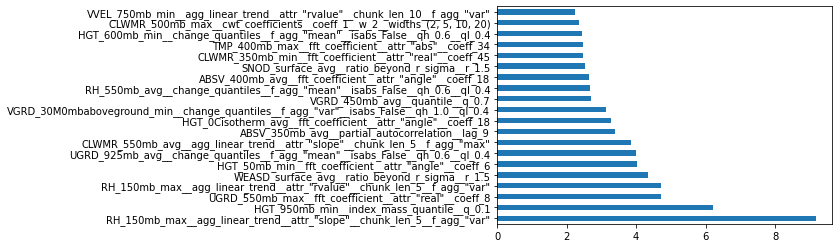

In [92]:
pd.Series(model.get_booster().get_score(importance_type='gain')).sort_values(ascending=False)[:20].plot.barh()

In [48]:


#grid = {'learning_rate': 0.1, 'objective': 'multi:softmax', 'num_class': 4 }

#model = XGBClassifier(nthread=4) 
#model.set_params(**grid)

def batch_learn():
    remaining_labels_test = labels_data_test
    relevant_intersection = None
    val = None
    
    for p in range(18, dfs[0].npartitions):
        print(str(datetime.now()) + ': getting train batch: ' + str(p))
        
        X_train_batch = get_batch3(p)
        y_train_batch = y_train_above.loc[y_train_above.index.isin(X_train_batch.index)].compute()
        print(str(datetime.now()) + ':getting test batch')
        X_test, y_test, remaining_labels_test = get_xr_batch(remaining_labels_test, lookback_days=180, batch_size=50, n_jobs=8)
        if relevant_intersection is None:
            X_test_batch = prepare_batch(X_test, compute_tsfresh=True, known_relevant_features=X_train_batch)
        else:
            X_test_batch = prepare_batch(X_test, compute_tsfresh=True, known_relevant_features=X_train_batch[relevant_intersection])
            
        y_test_above = y_test['Day1DangerAboveTreeline'].astype('category').cat.codes
        y_test_batch = y_test_above.loc[y_test_above.index.isin(X_test_batch.index)]
        
        relevant_intersection = list(set(X_test_batch.columns.values) & set(X_train_batch.columns.values))
        print(str(datetime.now()) + ':caching files')
        #return X_train_batch, y_train_batch
        X_train_small = X_train_batch.apply(lambda x: pd.to_numeric(x, downcast='float'))
        X_test_small = X_test_batch.apply(lambda x: pd.to_numeric(x, downcast='float'))
        
        X_train_small.to_hdf(temp_path + 'batches/X_train_' + str(p) + '.h5', '/data')
        X_train_small.to_csv(temp_path + 'batches/X_train_' + str(p) + '.csv')
        y_train_batch.to_csv(temp_path + 'batches/y_train_' + str(p) + '.csv')
        
        X_test_small.to_hdf(temp_path + 'batches/X_test_' + str(p) + '.h5', '/data')
        X_test_small.to_csv(temp_path + 'batches/X_test_' + str(p) + '.csv')
        y_test_batch.to_csv(temp_path + 'batches/y_test_' + str(p) + '.csv')
        del X_train_small
        del y_train_batch
        del X_test_small
        del y_test_batch
        del X_test
        del y_test
        del X_train_batch
        del X_test_batch
        #if val is None:
        #    print(str(datetime.now()) + ': fitting original model')
        #    val = model.fit(X_train_batch[relevant_intersection], y_train_batch)
        #else:
        #    print(str(datetime.now()) + ': batch fitting model')
        #    val = model.fit(X_train_batch[relevant_intersection], y_train_batch, xgb_model=val)
        
        #print(str(datetime.now()) + ': predicting')
        #result = model.predict(X_test_batch[relevant_intersection])
        #evaluateSingleClassShort(y_test_batch.iloc[X_test_batch.index], result)
        #print_matrix(X_test_batch, y_test_batch, result)

In [49]:
%time  batch_learn()

2020-06-28 22:04:42.134228: getting train batch: 3
2020-06-28 22:15:02.092740:getting test batch
data has len: 48
Filling remaining have 48
data has len: 4
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:27<00:00,  1.25s/it]


On i: 75 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:24<00:00,  1.21s/it]


On i: 150 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:22<00:00,  1.19s/it]


On i: 225 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:18<00:00,  1.12s/it]


On i: 300 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:19<00:00,  1.14s/it]


On i: 375 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:22<00:00,  1.18s/it]


On i: 450 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:18<00:00,  1.13s/it]


On i: 525 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:19<00:00,  1.16s/it]


On i: 600 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:19<00:00,  1.13s/it]


On i: 675 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:20<00:00,  1.16s/it]


On i: 750 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:20<00:00,  1.15s/it]


On i: 825 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:20<00:00,  1.14s/it]


On i: 900 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:17<00:00,  1.12s/it]


On i: 975 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:19<00:00,  1.14s/it]


On i: 1050 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:11<00:00,  1.04s/it]


2020-06-28 22:37:23.871011:caching files
2020-06-28 22:42:30.882249: getting train batch: 4
2020-06-28 22:52:13.752348:getting test batch
data has len: 48
Filling remaining have 48
data has len: 4
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:40<00:00,  1.43s/it]


On i: 75 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.36s/it]


On i: 150 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:37<00:00,  1.40s/it]


On i: 225 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.37s/it]


On i: 300 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:37<00:00,  1.39s/it]


On i: 375 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:38<00:00,  1.40s/it]


On i: 450 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.34s/it]


On i: 525 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:37<00:00,  1.39s/it]


On i: 600 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:37<00:00,  1.39s/it]


On i: 675 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 750 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:37<00:00,  1.40s/it]


On i: 825 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:36<00:00,  1.37s/it]


On i: 900 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:37<00:00,  1.39s/it]


On i: 975 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:36<00:00,  1.38s/it]


On i: 1050 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:22<00:00,  1.20s/it]


2020-06-28 23:18:36.751283:caching files
2020-06-28 23:23:45.916106: getting train batch: 5
2020-06-28 23:33:27.466977:getting test batch
data has len: 48
Filling remaining have 48
data has len: 4
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:36<00:00,  1.37s/it]


On i: 75 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:31<00:00,  1.31s/it]


On i: 150 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:34<00:00,  1.37s/it]


On i: 225 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 300 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 375 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 450 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 525 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.37s/it]


On i: 600 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:33<00:00,  1.36s/it]


On i: 675 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 750 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.37s/it]


On i: 825 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 900 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.34s/it]


On i: 975 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:33<00:00,  1.36s/it]


On i: 1050 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:28<00:00,  1.27s/it]


2020-06-28 23:59:28.510683:caching files
2020-06-29 00:04:36.652330: getting train batch: 6
2020-06-29 00:14:22.495008:getting test batch
data has len: 48
Filling remaining have 48
data has len: 4
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:36<00:00,  1.38s/it]


On i: 75 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 150 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:37<00:00,  1.39s/it]


On i: 225 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.34s/it]


On i: 300 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 375 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:36<00:00,  1.38s/it]


On i: 450 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 525 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 600 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:34<00:00,  1.37s/it]


On i: 675 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:36<00:00,  1.38s/it]


On i: 750 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:36<00:00,  1.38s/it]


On i: 825 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 900 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 975 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:36<00:00,  1.40s/it]


On i: 1050 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:28<00:00,  1.29s/it]


2020-06-29 00:40:40.165878:caching files
2020-06-29 00:45:48.883228: getting train batch: 7
2020-06-29 00:55:33.155088:getting test batch
data has len: 48
Filling remaining have 48
data has len: 4
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:37<00:00,  1.39s/it]


On i: 75 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 150 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:35<00:00,  1.39s/it]


On i: 225 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.34s/it]


On i: 300 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.36s/it]


On i: 375 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:37<00:00,  1.39s/it]


On i: 450 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 525 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:34<00:00,  1.37s/it]


On i: 600 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:36<00:00,  1.37s/it]


On i: 675 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 750 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 825 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.34s/it]


On i: 900 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:34<00:00,  1.37s/it]


On i: 975 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:36<00:00,  1.38s/it]


On i: 1050 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:28<00:00,  1.26s/it]


2020-06-29 01:21:47.680956:caching files
2020-06-29 01:26:58.287150: getting train batch: 8
2020-06-29 01:36:40.587277:getting test batch
data has len: 48
Filling remaining have 48
data has len: 4
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:40<00:00,  1.43s/it]


On i: 75 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.34s/it]


On i: 150 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:35<00:00,  1.38s/it]


On i: 225 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.34s/it]


On i: 300 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:36<00:00,  1.38s/it]


On i: 375 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:38<00:00,  1.41s/it]


On i: 450 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:37<00:00,  1.39s/it]


On i: 525 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:35<00:00,  1.39s/it]


On i: 600 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:38<00:00,  1.41s/it]


On i: 675 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:36<00:00,  1.37s/it]


On i: 750 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:38<00:00,  1.41s/it]


On i: 825 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 900 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:38<00:00,  1.41s/it]


On i: 975 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:36<00:00,  1.38s/it]


On i: 1050 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:25<00:00,  1.24s/it]


2020-06-29 02:03:08.600088:caching files
2020-06-29 02:08:18.764532: getting train batch: 9
2020-06-29 02:18:03.436013:getting test batch
data has len: 48
Filling remaining have 48
data has len: 4
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.34s/it]


On i: 75 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:29<00:00,  1.28s/it]


On i: 150 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:31<00:00,  1.31s/it]


On i: 225 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:32<00:00,  1.33s/it]


On i: 300 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.34s/it]


On i: 375 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:32<00:00,  1.32s/it]


On i: 450 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:30<00:00,  1.29s/it]


On i: 525 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.34s/it]


On i: 600 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:32<00:00,  1.32s/it]


On i: 675 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:31<00:00,  1.31s/it]


On i: 750 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:30<00:00,  1.30s/it]


On i: 825 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.33s/it]


On i: 900 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:32<00:00,  1.32s/it]


On i: 975 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.33s/it]


On i: 1050 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:23<00:00,  1.19s/it]


2020-06-29 02:43:30.851883:caching files
2020-06-29 02:48:42.572587: getting train batch: 10
2020-06-29 02:58:25.006608:getting test batch
data has len: 48
Filling remaining have 48
data has len: 4
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:37<00:00,  1.39s/it]


On i: 75 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:32<00:00,  1.32s/it]


On i: 150 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:32<00:00,  1.32s/it]


On i: 225 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.34s/it]


On i: 300 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.36s/it]


On i: 375 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.34s/it]


On i: 450 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:32<00:00,  1.32s/it]


On i: 525 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 600 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.37s/it]


On i: 675 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 750 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.33s/it]


On i: 825 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 900 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.37s/it]


On i: 975 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 1050 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:24<00:00,  1.20s/it]


2020-06-29 03:24:25.121517:caching files
2020-06-29 03:29:35.966931: getting train batch: 11
2020-06-29 03:39:22.310901:getting test batch
data has len: 48
Filling remaining have 48
data has len: 4
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:39<00:00,  1.42s/it]


On i: 75 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.33s/it]


On i: 150 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:35<00:00,  1.38s/it]


On i: 225 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 300 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:36<00:00,  1.38s/it]


On i: 375 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:36<00:00,  1.38s/it]


On i: 450 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:36<00:00,  1.38s/it]


On i: 525 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:35<00:00,  1.39s/it]


On i: 600 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:36<00:00,  1.38s/it]


On i: 675 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.37s/it]


On i: 750 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:37<00:00,  1.39s/it]


On i: 825 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 900 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:35<00:00,  1.39s/it]


On i: 975 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:38<00:00,  1.40s/it]


On i: 1050 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:29<00:00,  1.28s/it]


2020-06-29 04:05:57.613797:caching files
2020-06-29 04:11:09.375075: getting train batch: 12
2020-06-29 04:20:57.071438:getting test batch
data has len: 48
Filling remaining have 48
data has len: 4
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:36<00:00,  1.38s/it]


On i: 75 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 150 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.34s/it]


On i: 225 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.34s/it]


On i: 300 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 375 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 450 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:32<00:00,  1.32s/it]


On i: 525 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:36<00:00,  1.38s/it]


On i: 600 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 675 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 750 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.34s/it]


On i: 825 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 900 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 975 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 1050 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:24<00:00,  1.21s/it]


2020-06-29 04:47:00.987159:caching files
2020-06-29 04:52:11.215581: getting train batch: 13
2020-06-29 05:01:55.542024:getting test batch
data has len: 48
Filling remaining have 48
data has len: 4
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 75 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.33s/it]


On i: 150 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.34s/it]


On i: 225 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.33s/it]


On i: 300 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:32<00:00,  1.32s/it]


On i: 375 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 450 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.33s/it]


On i: 525 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:35<00:00,  1.38s/it]


On i: 600 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:32<00:00,  1.32s/it]


On i: 675 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.36s/it]


On i: 750 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.33s/it]


On i: 825 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.37s/it]


On i: 900 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:32<00:00,  1.34s/it]


On i: 975 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.36s/it]


On i: 1050 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:24<00:00,  1.23s/it]


2020-06-29 05:27:53.199389:caching files
2020-06-29 05:33:02.490418: getting train batch: 14
2020-06-29 05:42:51.425924:getting test batch
data has len: 48
Filling remaining have 48
data has len: 4
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:36<00:00,  1.38s/it]


On i: 75 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:31<00:00,  1.31s/it]


On i: 150 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 225 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.33s/it]


On i: 300 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.36s/it]


On i: 375 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 450 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.34s/it]


On i: 525 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 600 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:32<00:00,  1.32s/it]


On i: 675 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 750 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.33s/it]


On i: 825 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:32<00:00,  1.33s/it]


On i: 900 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 975 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.37s/it]


On i: 1050 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:22<00:00,  1.20s/it]


2020-06-29 06:08:50.740146:caching files
2020-06-29 06:14:01.657573: getting train batch: 15
2020-06-29 06:23:47.522239:getting test batch
data has len: 48
Filling remaining have 48
data has len: 4
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 75 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:32<00:00,  1.32s/it]


On i: 150 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:32<00:00,  1.33s/it]


On i: 225 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:30<00:00,  1.30s/it]


On i: 300 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:32<00:00,  1.35s/it]


On i: 375 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 450 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:32<00:00,  1.32s/it]


On i: 525 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:32<00:00,  1.33s/it]


On i: 600 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.33s/it]


On i: 675 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:32<00:00,  1.34s/it]


On i: 750 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 825 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:32<00:00,  1.32s/it]


On i: 900 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.34s/it]


On i: 975 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.33s/it]


On i: 1050 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:29<00:00,  1.27s/it]


2020-06-29 06:49:35.770775:caching files
2020-06-29 06:54:45.020225: getting train batch: 16
2020-06-29 07:04:29.979975:getting test batch
data has len: 48
Filling remaining have 48
data has len: 4
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:42<00:00,  1.46s/it]


On i: 75 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:40<00:00,  1.43s/it]


On i: 150 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:41<00:00,  1.45s/it]


On i: 225 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:39<00:00,  1.43s/it]


On i: 300 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:40<00:00,  1.44s/it]


On i: 375 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:40<00:00,  1.43s/it]


On i: 450 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:38<00:00,  1.40s/it]


On i: 525 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:39<00:00,  1.42s/it]


On i: 600 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:40<00:00,  1.44s/it]


On i: 675 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:43<00:00,  1.48s/it]


On i: 750 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:38<00:00,  1.41s/it]


On i: 825 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:41<00:00,  1.45s/it]


On i: 900 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:39<00:00,  1.42s/it]


On i: 975 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:41<00:00,  1.45s/it]


On i: 1050 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:24<00:00,  1.23s/it]


2020-06-29 07:31:57.782788:caching files
2020-06-29 07:37:11.870413: getting train batch: 17
2020-06-29 07:46:56.222658:getting test batch
data has len: 48
Filling remaining have 48
data has len: 4
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.37s/it]


On i: 75 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:31<00:00,  1.31s/it]


On i: 150 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.34s/it]


On i: 225 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.34s/it]


On i: 300 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:33<00:00,  1.36s/it]


On i: 375 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 450 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:31<00:00,  1.31s/it]


On i: 525 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 600 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:32<00:00,  1.33s/it]


On i: 675 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:34<00:00,  1.36s/it]


On i: 750 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 825 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.33s/it]


On i: 900 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.35s/it]


On i: 975 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:34<00:00,  1.34s/it]


On i: 1050 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:24<00:00,  1.23s/it]


2020-06-29 08:12:52.690710:caching files
2020-06-29 08:18:06.526250: getting train batch: 18
2020-06-29 08:27:52.111764:getting test batch
data has len: 48
Filling remaining have 48
data has len: 4
On clean_double_space
On interpolate_na
On xr_batch_to_tsfresh_df
On i: 0 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:37<00:00,  1.39s/it]


On i: 75 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:33<00:00,  1.34s/it]


On i: 150 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:34<00:00,  1.37s/it]


On i: 225 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:37<00:00,  1.39s/it]


On i: 300 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:33<00:00,  1.35s/it]


On i: 375 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:38<00:00,  1.41s/it]


On i: 450 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 525 of 1107


Feature Extraction: 100%|██████████| 69/69 [01:34<00:00,  1.38s/it]


On i: 600 of 1107


Feature Extraction: 100%|██████████| 70/70 [01:35<00:00,  1.36s/it]


On i: 675 of 1107


Feature Extraction:  61%|██████    | 42/69 [01:05<00:26,  1.02it/s]Process ForkPoolWorker-3872:
Process ForkPoolWorker-3870:
Process ForkPoolWorker-3868:
Feature Extraction:  61%|██████    | 42/69 [01:06<00:42,  1.59s/it]Process ForkPoolWorker-3869:
Process ForkPoolWorker-3863:
Process ForkPoolWorker-3871:

Process ForkPoolWorker-3867:
Process ForkPoolWorker-3862:
Process ForkPoolWorker-3861:
Process ForkPoolWorker-3866:
Process ForkPoolWorker-3859:
Process ForkPoolWorker-3860:


KeyboardInterrupt: 

Process ForkPoolWorker-3865:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/multiprocessing/pro

  File "/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/multiprocessing/pool.py", line 127, in worker
    put((job, i, result))
  File "/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
KeyboardInterrupt
  File "/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/scottcha/anaconda3

In [4]:
X_test = pd.read_hdf(final_path + 'X_test.h5', '/data')

In [6]:
X_test.to_csv(final_path + 'X_test.csv')

In [5]:
X_test.shape

(2391, 230492)

In [8]:
y_test_dd = dd.read_parquet(final_path + 'y_test.parquet', npartitions=100)

In [14]:
y_test = y_test_dd.compute()

In [9]:
y_test_above = y_test_dd.categorize()['Day1DangerAboveTreeline'].cat.codes.compute()

In [10]:
relevant_intersection = list(set(X_test.columns.values) & set(X_final.columns.values))

In [13]:
X_final.loc[:100,relevant_intersection].shape

(101, 221868)

In [16]:
X_train_small = prep_svmlite(X_final.loc[:100,relevant_intersection])

In [21]:
df_to_libsvm(X_train_small, y_train_above.loc[:100], 'train_small')

In [32]:
X_train_2 = prep_svmlite(X_final[relevant_intersection])

In [33]:
df_to_libsvm(X_train_2, y_train_above)

In [22]:
X_test_small = prep_svmlite(X_test.loc[:100,relevant_intersection])

In [34]:
X_test_2 = prep_svmlite(X_test[relevant_intersection])

In [23]:
df_to_libsvm(X_test_small, y_test_above.loc[:100], 'test_small')

In [25]:
X_test_2.shape

(2391, 230492)

In [35]:
df_to_libsvm(X_test_2, y_test_above, 'test')

In [25]:
X_train = X_final

In [26]:
X_test = X_test_final

In [29]:
len(relevant_intersection)

221868

In [4]:
dtrain = xgb.DMatrix(os.path.join(final_path, 'train.dat'))# + '#' + os.path.join(final_path, 'dtrain.cache'))

[09:08:45] 10269x221868 matrix with 2161387291 entries loaded from /media/scottcha/E1/Temp/Final/train.dat


In [5]:
dtest = xgb.DMatrix(os.path.join(final_path, 'test.dat'))# + '#' + os.path.join(final_path, 'dtest.cache'))

[09:10:25] 2391x221868 matrix with 495392181 entries loaded from /media/scottcha/E1/Temp/Final/test.dat


In [12]:
grid = {'learning_rate': 0.1, 'objective': 'multi:softmax', 'num_class': 4, 'eval_metric':['merror', 'mlogloss'],  'nthread': 8 }
#'tree_method':'gpu_hist', 'gpu_id':0,
model = xgb.XGBClassifier() 
model.set_params(**grid)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              eval_metric=['merror', 'mlogloss'], gamma=None, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, nthread=8, num_class=4,
              num_parallel_tree=None, objective='multi:softmax',
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [7]:

#external memory
eval_set = [(dtest, 'eval'), (dtrain, 'train')]
evals_result = {}
bst = xgb.train(grid, dtrain,early_stopping_rounds=5, evals=eval_set, evals_result=evals_result, verbose_eval=True )
#val = model.fit(dtrain, early_stopping_rounds=5, eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=True)

[0]	eval-merror:0.73400	eval-mlogloss:1.39578	train-merror:0.18551	train-mlogloss:1.28118
Multiple eval metrics have been passed: 'train-mlogloss' will be used for early stopping.

Will train until train-mlogloss hasn't improved in 5 rounds.
[1]	eval-merror:0.72355	eval-mlogloss:1.39837	train-merror:0.15873	train-mlogloss:1.18961
[2]	eval-merror:0.67503	eval-mlogloss:1.40146	train-merror:0.14344	train-mlogloss:1.10920
[3]	eval-merror:0.69051	eval-mlogloss:1.40752	train-merror:0.13244	train-mlogloss:1.03748
[4]	eval-merror:0.70305	eval-mlogloss:1.41183	train-merror:0.12280	train-mlogloss:0.97258
[5]	eval-merror:0.64199	eval-mlogloss:1.40647	train-merror:0.11588	train-mlogloss:0.91504
[6]	eval-merror:0.65496	eval-mlogloss:1.41865	train-merror:0.10975	train-mlogloss:0.86306
[7]	eval-merror:0.65412	eval-mlogloss:1.42818	train-merror:0.10157	train-mlogloss:0.81311
[8]	eval-merror:0.65663	eval-mlogloss:1.44599	train-merror:0.09641	train-mlogloss:0.77032
[9]	eval-merror:0.66876	eval-mlogloss:

In [ ]:
#dask
eval_set = [(X_test[relevant_intersection], y_test_above)]

val = model.fit(X_train_dd[relevant_intersection], y_train_above, early_stopping_rounds=5, eval_metric=["merror", "mlogloss"], eval_set=eval_set)

/home/scottcha/anaconda3/envs/pangeo_small2/lib/python3.7/site-packages/distributed/worker.py:3390: UserWarning: Large object of size 4.26 GB detected in task graph: 
  {'dmatrix_kwargs': {}, 'num_boost_round': 100, 'ev ... ing_rounds': 5}
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


In [11]:
X_train = X_final

In [ ]:
#nondask
eval_set = [(X_train[relevant_intersection], y_train['Day1DangerAboveTreeline']), (X_test[relevant_intersection], y_test['Day1DangerAboveTreeline'])]
#eval_set = [(X_test[relevant_intersection], y_test['Day1DangerAboveTreeline'])]
val = model.fit(X_train[relevant_intersection], y_train['Day1DangerAboveTreeline'], early_stopping_rounds=5, eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=True)

In [32]:
best_iteration = val.get_booster().best_ntree_limit

In [33]:
result = model.predict(X_test[relevant_intersection], ntree_limit=best_iteration)

In [34]:
result_train = model.predict(X_train[relevant_intersection], ntree_limit=best_iteration)

Accuracy: 0.9863894705354472
Classification Report
              precision    recall  f1-score   support

Considerable       0.99      0.98      0.98      1661
        High       0.98      1.00      0.99      1665
         Low       0.98      1.00      0.99      1685
    Moderate       1.00      0.97      0.98      1675

    accuracy                           0.99      6686
   macro avg       0.99      0.99      0.99      6686
weighted avg       0.99      0.99      0.99      6686

Normalized confusion matrix
Confusion matrix, without normalization


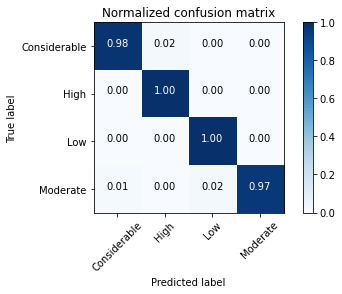

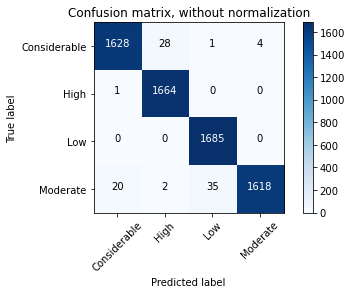

In [35]:
 #train
evaluateSingleClassShort(y_train['Day1DangerAboveTreeline'], result_train)
print_matrix(X_train[relevant_intersection], y_train['Day1DangerAboveTreeline'], result_train)

Accuracy: 0.4666666666666667
Classification Report
              precision    recall  f1-score   support

Considerable       0.43      0.31      0.36        64
        High       0.83      0.32      0.46        63
         Low       0.60      0.54      0.57        65
    Moderate       0.35      0.70      0.46        63

    accuracy                           0.47       255
   macro avg       0.55      0.47      0.46       255
weighted avg       0.55      0.47      0.46       255

Normalized confusion matrix
Confusion matrix, without normalization


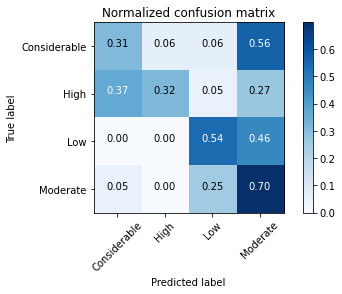

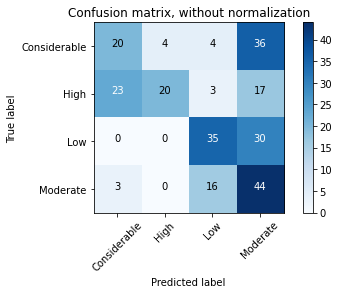

In [109]:
#38 batches overall accuracy.46, Precision: Considerable: .43, High: .83, Low: .6, Moderate: .35
evaluateSingleClassShort(y_test['Day1DangerAboveTreeline'], result)
print_matrix(X_test[relevant_intersection], y_test['Day1DangerAboveTreeline'], result)

Accuracy: 0.5372549019607843
Classification Report
              precision    recall  f1-score   support

Considerable       0.43      0.50      0.46        64
        High       0.72      0.33      0.46        63
         Low       0.65      0.78      0.71        65
    Moderate       0.45      0.52      0.49        63

    accuracy                           0.54       255
   macro avg       0.56      0.54      0.53       255
weighted avg       0.56      0.54      0.53       255

Normalized confusion matrix
Confusion matrix, without normalization


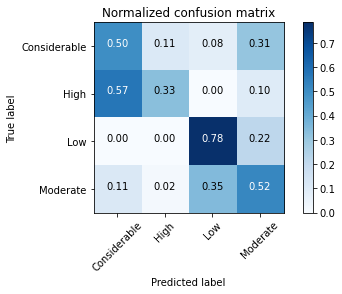

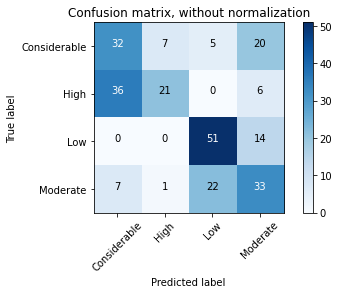

In [36]:
#130 batches
evaluateSingleClassShort(y_test['Day1DangerAboveTreeline'], result)
print_matrix(X_test[relevant_intersection], y_test['Day1DangerAboveTreeline'], result)

In [37]:
results = model.evals_result()

In [38]:
results

{'validation_0': {'merror': [0.161681,
   0.145229,
   0.129824,
   0.115465,
   0.108585,
   0.097966,
   0.093479,
   0.086748,
   0.082261,
   0.076279,
   0.069249,
   0.065809,
   0.062519,
   0.057733,
   0.054143,
   0.050853,
   0.047413,
   0.045169,
   0.043225,
   0.042178,
   0.039186,
   0.037242,
   0.035597,
   0.033353,
   0.031858,
   0.030811,
   0.028418,
   0.02767,
   0.026174,
   0.02423,
   0.022884,
   0.022285,
   0.020191,
   0.019593,
   0.017798,
   0.017499,
   0.015555,
   0.015405,
   0.014209,
   0.013611,
   0.013012,
   0.012564,
   0.011517,
   0.011068],
  'mlogloss': [1.277353,
   1.184609,
   1.102805,
   1.029245,
   0.96224,
   0.901607,
   0.846064,
   0.795519,
   0.750087,
   0.709152,
   0.669571,
   0.632013,
   0.600873,
   0.569316,
   0.541187,
   0.514977,
   0.489304,
   0.468332,
   0.448264,
   0.428948,
   0.411069,
   0.396053,
   0.379821,
   0.363773,
   0.349179,
   0.335883,
   0.323351,
   0.310363,
   0.298783,
   0.288116,
  

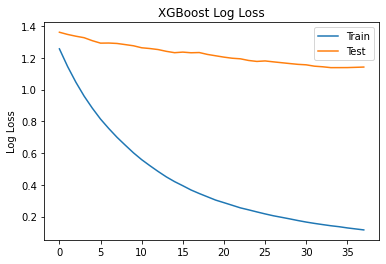

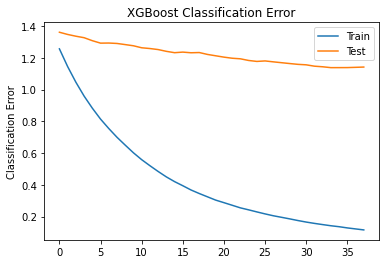

In [112]:
#38 batches
from matplotlib import pyplot
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

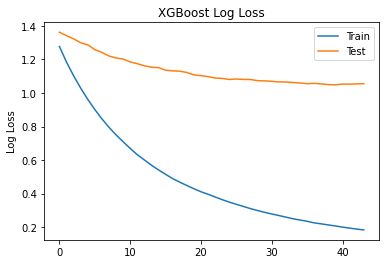

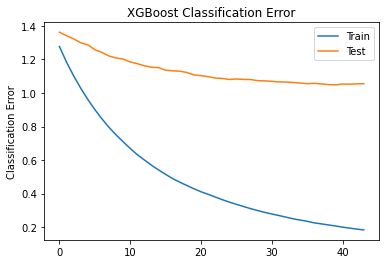

In [39]:
#130 batches
from matplotlib import pyplot
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

Accuracy: 0.5254901960784314
Classification Report
              precision    recall  f1-score   support

Considerable       0.42      0.41      0.41        64
        High       0.67      0.62      0.64        63
         Low       0.58      0.80      0.67        65
    Moderate       0.38      0.27      0.31        63

    accuracy                           0.53       255
   macro avg       0.51      0.52      0.51       255
weighted avg       0.51      0.53      0.51       255

Normalized confusion matrix
Confusion matrix, without normalization


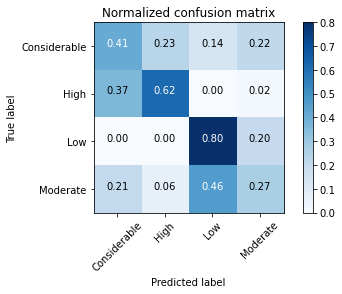

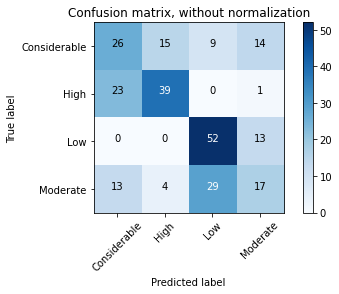

In [61]:
#test 10 batches
evaluateSingleClassShort(y_test['Day1DangerAboveTreeline'], result)
print_matrix(X_test[relevant_intersection], y_test['Day1DangerAboveTreeline'], result)

Accuracy: 0.19230769230769232
Classification Report
              precision    recall  f1-score   support

           0       0.29      0.27      0.28        26
           1       0.17      0.31      0.22        26
           2       0.17      0.08      0.11        26
           3       0.14      0.12      0.12        26

    accuracy                           0.19       104
   macro avg       0.19      0.19      0.18       104
weighted avg       0.19      0.19      0.18       104

Normalized confusion matrix
Confusion matrix, without normalization


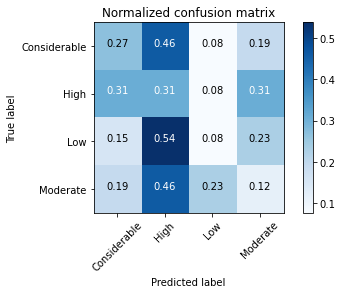

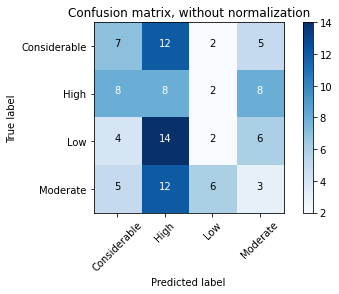

In [99]:
#2 batches
evaluateSingleClassShort(y_test['0'], result)
print_matrix(X_test, y_test['0'], result)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f30aaf68a90>,
      dtype=object)

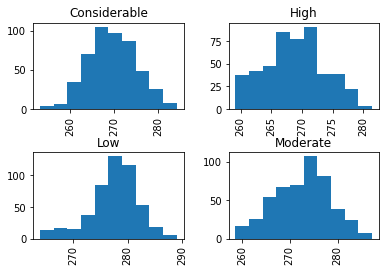

In [88]:
pd.concat([X_train['vars_177_TMP_750mb_max'], y_train['Day1DangerAboveTreeline']], axis=1).hist(by='Day1DangerAboveTreeline')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f30a5454710>,
      dtype=object)

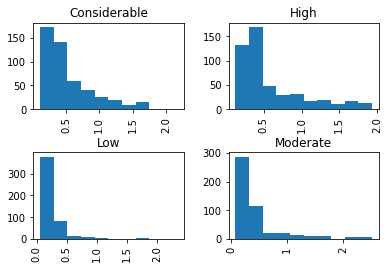

In [87]:
pd.concat([X_train['TMP_10mb_avg__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"'], y_train['Day1DangerAboveTreeline']], axis=1).hist(by='Day1DangerAboveTreeline')

In [ ]:
TMP_10mb_avg__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"

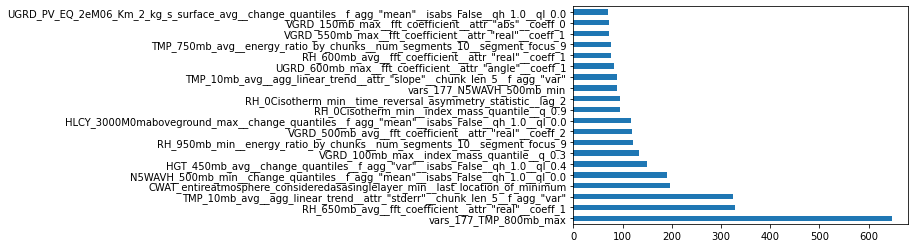

In [46]:
pd.Series(model.get_booster().get_score(importance_type='gain')).sort_values(ascending=False)[:20].plot.barh()

In [26]:
X_test.head(200)

ABSV_10mb_min__absolute_sum_of_changes  \
0                                  0.000711   
1                                  0.000471   
2                                  0.000470   
3                                  0.000408   
4                                  0.000580   
..                                      ...   
195                                0.000571   
196                                0.000249   
197                                0.000276   
198                                0.000964   
199                                0.000574   

     ABSV_10mb_min__agg_autocorrelation__f_agg_"mean"__maxlag_40  \
0                                            -0.003490             
1                                            -0.071789             
2                                            -0.104146             
3                                            -0.063701             
4                                            -0.003081             
..                                                 ...             
195                                          -0.032223             
196                                          -0.135100             
197                                           0.025306             
198                                           0.137526             
199                                          -0.012805             

     ABSV_10mb_min__agg_autocorrelation__f_agg_"median"__maxlag_40  \
0                                            -0.026623               
1                                            -0.035734               
2                                            -0.086835               
3                                            -0.031365               
4                                            -0.004733               
..                                                 ...               
195                                           0.001040               
196                                          -0.173164               
197                                          -0.010676               
198                                           0.122154               
199                                          -0.031990               

     ABSV_10mb_min__agg_autocorrelation__f_agg_"var"__maxlag_40  \
0                                             0.032028            
1                                             0.174281            
2                                             0.184229            
3                                             0.130665            
4                                             0.060145            
..                                                 ...            
195                                           0.063237            
196                                           0.088756            
197                                           0.172521            
198                                           0.015901            
199                                           0.062056            

     ABSV_10mb_min__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"max"  \
0                                             0.000112                              
1                                             0.000117                              
2                                             0.000109                              
3                                             0.000104                              
4                                             0.000106                              
..                                                 ...                              
195                                           0.000118                              
196                                           0.000109                              
197                                           0.000104                              
198                                           0.000105                              
199                                       

In [27]:
y_test

Unnamed: 0  0
0             0  1
1             1  1
2             2  3
3             3  3
4             4  0
..          ... ..
927          47  2
928          48  0
929          49  2
930          50  3
931          51  1

[932 rows x 2 columns]

In [29]:
dupes = X_test.duplicated()

In [31]:
dupes.value_counts()

True     511
False    421
dtype: int64